In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 36
    popular_weeks = 1
    train_weeks = 8
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    ohe_distance_num_items = 32
    ohe_distance_num_weeks = 1
    dynamic_feature_weeks = 8
    volume_feature_weeks = 1

In [5]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            pair_count_threshold: int,
        ) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        try:
            index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        except AttributeError as e:
            print(e)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [6]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 11.007 s


[popular] 0.643 s


[item2item] 9.981 s


[cooccurrence] 16.946 s


[same_product_code] 6.813 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 31.795 s


volume: 15987619


duplicates: 1.0556966552279194


            strategy   volume     ratio
0  same_product_code  6876142  0.430092
1         repurchase  3446562  0.215577
2                pop  2483424  0.155334
3       ohe_distance  1977750  0.123705
4               cooc  1203741  0.075292


create candidates (week: 2)


[repurchase] 11.292 s


[popular] 0.669 s


[item2item] 10.270 s


[cooccurrence] 18.995 s


[same_product_code] 7.008 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 34.067 s


volume: 16954065


duplicates: 1.0593421132050855


            strategy   volume     ratio
0  same_product_code  7228749  0.426373
1         repurchase  3637145  0.214529
2                pop  2592684  0.152924
3       ohe_distance  2077450  0.122534
4               cooc  1418037  0.083640


create candidates (week: 3)


[repurchase] 11.714 s


[popular] 0.695 s


[item2item] 10.731 s


[cooccurrence] 19.301 s


[same_product_code] 7.338 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 36.234 s


volume: 17927187


duplicates: 1.0624744081583812


            strategy   volume     ratio
0  same_product_code  7678831  0.428334
1         repurchase  3742824  0.208779
2                pop  2729592  0.152260
3       ohe_distance  2185255  0.121896
4               cooc  1590685  0.088730


create candidates (week: 4)


[repurchase] 12.333 s


[popular] 0.734 s


[item2item] 11.371 s


[cooccurrence] 19.967 s


[same_product_code] 8.135 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 37.990 s


volume: 19097402


duplicates: 1.0663558440034144


            strategy   volume     ratio
0  same_product_code  8177755  0.428213
1         repurchase  3915353  0.205020
2                pop  2889108  0.151283
3       ohe_distance  2317608  0.121357
4               cooc  1797578  0.094127


create candidates (week: 5)


[repurchase] 11.180 s


[popular] 0.677 s


[item2item] 10.211 s


[cooccurrence] 20.798 s


[same_product_code] 7.494 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 34.916 s


volume: 17406487


duplicates: 1.069576374563204


            strategy   volume     ratio
0  same_product_code  7353615  0.422464
1         repurchase  3548895  0.203883
2                pop  2593260  0.148982
3       ohe_distance  2093464  0.120269
4               cooc  1817253  0.104401


create candidates (week: 6)


[repurchase] 11.397 s


[popular] 0.651 s


[item2item] 10.429 s


[cooccurrence] 21.411 s


[same_product_code] 7.296 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 34.829 s


volume: 17545522


duplicates: 1.0782880846842415


            strategy   volume     ratio
0  same_product_code  7341380  0.418419
1         repurchase  3547521  0.202190
2                pop  2559384  0.145871
3       ohe_distance  2079037  0.118494
4               cooc  2018200  0.115027


create candidates (week: 7)


[repurchase] 11.275 s


[popular] 0.687 s


[item2item] 10.406 s


[cooccurrence] 21.355 s


[same_product_code] 7.871 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 37.234 s


volume: 18172564


duplicates: 1.0772144095184577


            strategy   volume     ratio
0  same_product_code  7640091  0.420419
1         repurchase  3571089  0.196510
2                pop  2693988  0.148245
3       ohe_distance  2168891  0.119350
4               cooc  2098505  0.115477


create candidates (week: 8)


[repurchase] 12.017 s


[popular] 0.746 s


[item2item] 11.172 s


[cooccurrence] 20.894 s


[same_product_code] 8.457 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 41.365 s


volume: 20095835


duplicates: 1.080823814375591


            strategy   volume     ratio
0  same_product_code  8504664  0.423205
1         repurchase  3866183  0.192387
2                pop  2980872  0.148333
3       ohe_distance  2407585  0.119805
4               cooc  2336531  0.116269


create candidates (week: 9)


[repurchase] 11.545 s


[popular] 0.736 s


[item2item] 10.866 s


[cooccurrence] 20.407 s


[same_product_code] 8.043 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 39.685 s


volume: 19523099


duplicates: 1.0808098786285947


            strategy   volume     ratio
0  same_product_code  8280826  0.424155
1         repurchase  3692371  0.189128
2                pop  2901276  0.148607
3       ohe_distance  2346192  0.120175
4               cooc  2302434  0.117934


In [7]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [8]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.13952313220541998


            strategy        y   volume    recall  hit_ratio
0                pop  11811.0  2483424  0.055262   0.004756
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   7888.0  6876142  0.036907   0.001147
3               cooc   5096.0  1203741  0.023843   0.004233
4       ohe_distance   2291.0  1977750  0.010719   0.001158
merge labels (week: 1)


Recall: 0.12946338466938703


            strategy        y   volume    recall  hit_ratio
0                pop  10203.0  2592684  0.044768   0.003935
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   8554.0  7228749  0.037532   0.001183
3               cooc   5210.0  1418037  0.022860   0.003674
4       ohe_distance   2406.0  2077450  0.010557   0.001158
merge labels (week: 2)


Recall: 0.13317707939548207


            strategy        y   volume    recall  hit_ratio
0                pop  11942.0  2729592  0.050161   0.004375
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   8829.0  7678831  0.037085   0.001150
3               cooc   5376.0  1590685  0.022581   0.003380
4       ohe_distance   2466.0  2185255  0.010358   0.001128
merge labels (week: 3)


Recall: 0.13126832097565563


            strategy        y   volume    recall  hit_ratio
0                pop  13485.0  2889108  0.052847   0.004668
1  same_product_code   9328.0  8177755  0.036556   0.001141
2         repurchase   9002.0  3915353  0.035278   0.002299
3               cooc   5609.0  1797578  0.021981   0.003120
4       ohe_distance   2696.0  2317608  0.010565   0.001163
merge labels (week: 4)


Recall: 0.12885086104191487


            strategy       y   volume    recall  hit_ratio
0                pop  9552.0  2593260  0.041382   0.003683
1  same_product_code  9193.0  7353615  0.039827   0.001250
2         repurchase  8945.0  3548895  0.038752   0.002521
3               cooc  6350.0  1817253  0.027510   0.003494
4       ohe_distance  2230.0  2093464  0.009661   0.001065
merge labels (week: 5)


Recall: 0.12119244391971665


            strategy       y   volume    recall  hit_ratio
0         repurchase  9673.0  3547521  0.040787   0.002727
1  same_product_code  9115.0  7341380  0.038434   0.001242
2               cooc  7841.0  2018200  0.033062   0.003885
3                pop  7306.0  2559384  0.030806   0.002855
4       ohe_distance  1804.0  2079037  0.007607   0.000868
merge labels (week: 6)


Recall: 0.11111239557322976


            strategy       y   volume    recall  hit_ratio
0  same_product_code  9582.0  7640091  0.036923   0.001254
1               cooc  9260.0  2098505  0.035682   0.004413
2         repurchase  9107.0  3571089  0.035093   0.002550
3                pop  6975.0  2693988  0.026877   0.002589
4       ohe_distance  1724.0  2168891  0.006643   0.000795
merge labels (week: 7)


Recall: 0.11120611748348974


            strategy        y   volume    recall  hit_ratio
0  same_product_code  10925.0  8504664  0.037974   0.001285
1         repurchase   9930.0  3866183  0.034515   0.002568
2               cooc   9549.0  2336531  0.033191   0.004087
3                pop   8670.0  2980872  0.030136   0.002909
4       ohe_distance   2041.0  2407585  0.007094   0.000848
merge labels (week: 8)


Recall: 0.122604165900245


            strategy        y   volume    recall  hit_ratio
0  same_product_code  11329.0  8280826  0.041677   0.001368
1         repurchase  10216.0  3692371  0.037583   0.002767
2               cooc   9543.0  2302434  0.035107   0.004145
3                pop   9379.0  2901276  0.034504   0.003233
4       ohe_distance   2153.0  2346192  0.007921   0.000918


In [9]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 15987619 -> 5421065


drop trivial queries: 16954065 -> 5678392


drop trivial queries: 17927187 -> 6105920


drop trivial queries: 19097402 -> 6453760


drop trivial queries: 17406487 -> 5771250


drop trivial queries: 17545522 -> 5434894


drop trivial queries: 18172564 -> 5592617


drop trivial queries: 20095835 -> 6191360


drop trivial queries: 19523099 -> 6418021


In [10]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()

    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 4.963 s


[item stacic features] 5.525 s


[user dynamic features (transactions)] 4.197 s


[item dynamic features (transactions)] 3.856 s


[item dynamic features (user features)] 4.525 s


[item freshness features] 6.789 s


[item volume features] 3.887 s


[user freshness features] 8.452 s


[user volume features] 4.555 s


[user-item freshness features] 30.070 s


[user-item volume features] 7.916 s


[item age volume features] 7.077 s


[ohe dot products] 133.567 s


[lfm features] 9.415 s
attach features (week: 1)


[user static fetaures] 1.802 s


[item stacic features] 1.818 s


[user dynamic features (transactions)] 1.695 s


[item dynamic features (transactions)] 1.589 s


[item dynamic features (user features)] 2.151 s


[item freshness features] 4.486 s


[item volume features] 1.437 s


[user freshness features] 5.804 s


[user volume features] 1.580 s


[user-item freshness features] 25.213 s


[user-item volume features] 2.420 s


[item age volume features] 3.148 s


[ohe dot products] 58.630 s


[lfm features] 3.181 s
attach features (week: 2)


[user static fetaures] 1.807 s


[item stacic features] 1.914 s


[user dynamic features (transactions)] 1.849 s


[item dynamic features (transactions)] 1.641 s


[item dynamic features (user features)] 2.182 s


[item freshness features] 4.435 s


[item volume features] 1.486 s


[user freshness features] 5.688 s


[user volume features] 1.634 s


[user-item freshness features] 25.885 s


[user-item volume features] 2.601 s


[item age volume features] 3.368 s


[ohe dot products] 60.171 s


[lfm features] 3.315 s
attach features (week: 3)


[user static fetaures] 1.967 s


[item stacic features] 1.967 s


[user dynamic features (transactions)] 1.907 s


[item dynamic features (transactions)] 1.749 s


[item dynamic features (user features)] 2.296 s


[item freshness features] 4.492 s


[item volume features] 1.604 s


[user freshness features] 5.772 s


[user volume features] 1.821 s


[user-item freshness features] 25.604 s


[user-item volume features] 2.818 s


[item age volume features] 3.541 s


[ohe dot products] 62.155 s


[lfm features] 3.914 s
attach features (week: 4)


[user static fetaures] 2.097 s


[item stacic features] 2.105 s


[user dynamic features (transactions)] 2.116 s


[item dynamic features (transactions)] 1.799 s


[item dynamic features (user features)] 2.374 s


[item freshness features] 4.561 s


[item volume features] 1.667 s


[user freshness features] 5.702 s


[user volume features] 1.859 s


[user-item freshness features] 25.175 s


[user-item volume features] 2.917 s


[item age volume features] 3.595 s


[ohe dot products] 65.503 s


[lfm features] 4.209 s
attach features (week: 5)


[user static fetaures] 1.899 s


[item stacic features] 1.891 s


[user dynamic features (transactions)] 1.867 s


[item dynamic features (transactions)] 1.689 s


[item dynamic features (user features)] 2.354 s


[item freshness features] 4.406 s


[item volume features] 1.505 s


[user freshness features] 5.502 s


[user volume features] 1.650 s


[user-item freshness features] 24.778 s


[user-item volume features] 2.631 s


[item age volume features] 3.377 s


[ohe dot products] 60.672 s


[lfm features] 4.131 s
attach features (week: 6)


[user static fetaures] 1.755 s


[item stacic features] 1.786 s


[user dynamic features (transactions)] 1.804 s


[item dynamic features (transactions)] 1.622 s


[item dynamic features (user features)] 2.319 s


[item freshness features] 4.247 s


[item volume features] 1.389 s


[user freshness features] 5.330 s


[user volume features] 1.568 s


[user-item freshness features] 24.104 s


[user-item volume features] 2.485 s


[item age volume features] 3.193 s


[ohe dot products] 58.333 s


[lfm features] 4.280 s
attach features (week: 7)


[user static fetaures] 1.792 s


[item stacic features] 1.799 s


[user dynamic features (transactions)] 1.875 s


[item dynamic features (transactions)] 1.700 s


[item dynamic features (user features)] 2.319 s


[item freshness features] 4.224 s


[item volume features] 1.445 s


[user freshness features] 5.416 s


[user volume features] 1.623 s


[user-item freshness features] 22.601 s


[user-item volume features] 2.633 s


[item age volume features] 3.360 s


[ohe dot products] 59.003 s


[lfm features] 4.352 s
attach features (week: 8)


[user static fetaures] 1.963 s


[item stacic features] 1.987 s


[user dynamic features (transactions)] 2.048 s


[item dynamic features (transactions)] 1.790 s


[item dynamic features (user features)] 2.551 s


[item freshness features] 4.385 s


[item volume features] 1.623 s


[user freshness features] 5.714 s


[user volume features] 1.811 s


[user-item freshness features] 22.476 s


[user-item volume features] 2.885 s


[item age volume features] 3.578 s


[ohe dot products] 62.082 s


[lfm features] 4.697 s
attach features (week: 9)


[user static fetaures] 2.131 s


[item stacic features] 2.078 s


[user dynamic features (transactions)] 2.076 s


[item dynamic features (transactions)] 1.880 s


[item dynamic features (user features)] 2.575 s


[item freshness features] 4.414 s


[item volume features] 1.674 s


[user freshness features] 5.588 s


[user volume features] 1.862 s


[user-item freshness features] 22.764 s


[user-item volume features] 2.896 s


[item age volume features] 3.621 s


[ohe dot products] 63.462 s


[lfm features] 4.002 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'ohe_distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_ohe_score', 'product_gr

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

In [17]:
# if CFG.model_type == 'LightGBM':
#     group_train = get_query_group(train)
#     group_valid = get_query_group(valid)

#     train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
#     valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

#     params = {
#         'objective': 'xendcg',
#         'boosting_type': 'gbdt',
#         'learning_rate': 1e-6,
#         'num_leaves': 255,
#         'min_data_in_leaf': 100,
#         'metric': 'map',
#         'eval_at': 12,
#     }

#     model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

#     lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

# elif CFG.model_type == 'CatBoost':
#     train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
#     valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

#     params = {
#         'loss_function': 'YetiRank',
#         'use_best_model': True,
#         'one_hot_max_size': 300,
#         'iterations': 5000,
#     }
#     model = catboost.CatBoost(params)
#     model.fit(train_dataset, eval_set=valid_dataset)

#     plt.plot(model.get_evals_result()['validation']['PFound'])

#     feature_importance = model.get_feature_importance(train_dataset)
#     sorted_idx = np.argsort(feature_importance)
#     plt.figure(figsize=(8, 16))
#     plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
#     plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


# del train, valid, train_dataset, valid_dataset
# gc.collect()
# with open('output/model_for_validation.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [18]:
# pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
# pred['pred'] = model.predict(dataset_valid_all[feature_columns])

# pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
# pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

# gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
# merged = gt.merge(pred, on='user', how='left')
# merged['item'] = merged['item'].fillna('').apply(list)

# merged.to_pickle(f'output/merged_{dataset}.pkl')
# dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

# print('mAP@12:', mapk(merged['gt'], merged['item']))

In [19]:
# assert False

submission

In [20]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 1.743 s


[item stacic features] 1.950 s


[user dynamic features (transactions)] 1.711 s


[item dynamic features (transactions)] 1.596 s


[item dynamic features (user features)] 2.155 s


[item freshness features] 4.469 s


[item volume features] 1.440 s


[user freshness features] 5.726 s


[user volume features] 1.580 s


[user-item freshness features] 25.133 s


[user-item volume features] 2.509 s


[item age volume features] 3.226 s


[ohe dot products] 58.142 s


[lfm features] 5.634 s
attach features (week: 2)


[user static fetaures] 1.862 s


[item stacic features] 1.845 s


[user dynamic features (transactions)] 1.801 s


[item dynamic features (transactions)] 1.656 s


[item dynamic features (user features)] 2.191 s


[item freshness features] 4.454 s


[item volume features] 1.504 s


[user freshness features] 6.011 s


[user volume features] 1.645 s


[user-item freshness features] 25.659 s


[user-item volume features] 2.613 s


[item age volume features] 3.331 s


[ohe dot products] 59.867 s


[lfm features] 3.300 s
attach features (week: 3)


[user static fetaures] 1.941 s


[item stacic features] 2.052 s


[user dynamic features (transactions)] 1.918 s


[item dynamic features (transactions)] 1.732 s


[item dynamic features (user features)] 2.302 s


[item freshness features] 4.483 s


[item volume features] 1.599 s


[user freshness features] 5.788 s


[user volume features] 1.816 s


[user-item freshness features] 24.834 s


[user-item volume features] 2.732 s


[item age volume features] 3.491 s


[ohe dot products] 62.060 s


[lfm features] 4.032 s
attach features (week: 4)


[user static fetaures] 2.045 s


[item stacic features] 2.146 s


[user dynamic features (transactions)] 2.000 s


[item dynamic features (transactions)] 1.822 s


[item dynamic features (user features)] 2.446 s


[item freshness features] 4.589 s


[item volume features] 1.667 s


[user freshness features] 5.659 s


[user volume features] 1.855 s


[user-item freshness features] 25.885 s


[user-item volume features] 2.899 s


[item age volume features] 3.618 s


[ohe dot products] 66.624 s


[lfm features] 4.394 s
attach features (week: 5)


[user static fetaures] 1.892 s


[item stacic features] 1.954 s


[user dynamic features (transactions)] 1.905 s


[item dynamic features (transactions)] 1.720 s


[item dynamic features (user features)] 2.476 s


[item freshness features] 4.484 s


[item volume features] 1.535 s


[user freshness features] 5.596 s


[user volume features] 1.708 s


[user-item freshness features] 26.579 s


[user-item volume features] 2.646 s


[item age volume features] 3.447 s


[ohe dot products] 61.431 s


[lfm features] 4.384 s
attach features (week: 6)


[user static fetaures] 1.783 s


[item stacic features] 1.771 s


[user dynamic features (transactions)] 1.942 s


[item dynamic features (transactions)] 1.647 s


[item dynamic features (user features)] 2.330 s


[item freshness features] 4.317 s


[item volume features] 1.408 s


[user freshness features] 5.372 s


[user volume features] 1.549 s


[user-item freshness features] 25.345 s


[user-item volume features] 2.529 s


[item age volume features] 3.245 s


[ohe dot products] 59.191 s


[lfm features] 4.502 s
attach features (week: 7)


[user static fetaures] 1.825 s


[item stacic features] 1.826 s


[user dynamic features (transactions)] 1.951 s


[item dynamic features (transactions)] 1.687 s


[item dynamic features (user features)] 2.445 s


[item freshness features] 4.474 s


[item volume features] 1.462 s


[user freshness features] 5.506 s


[user volume features] 1.637 s


[user-item freshness features] 23.290 s


[user-item volume features] 2.613 s


[item age volume features] 3.389 s


[ohe dot products] 59.736 s


[lfm features] 4.706 s
attach features (week: 8)


[user static fetaures] 2.009 s


[item stacic features] 2.119 s


[user dynamic features (transactions)] 1.987 s


[item dynamic features (transactions)] 1.816 s


[item dynamic features (user features)] 2.491 s


[item freshness features] 4.413 s


[item volume features] 1.579 s


[user freshness features] 5.603 s


[user volume features] 1.733 s


[user-item freshness features] 23.070 s


[user-item volume features] 2.765 s


[item age volume features] 3.583 s


[ohe dot products] 64.022 s


[lfm features] 5.108 s
attach features (week: 9)


[user static fetaures] 2.084 s


[item stacic features] 2.113 s


[user dynamic features (transactions)] 2.050 s


[item dynamic features (transactions)] 1.896 s


[item dynamic features (user features)] 2.627 s


[item freshness features] 4.503 s


[item volume features] 1.669 s


[user freshness features] 5.542 s


[user volume features] 1.889 s


[user-item freshness features] 23.208 s


[user-item volume features] 2.952 s


[item age volume features] 3.665 s


[ohe dot products] 66.186 s


[lfm features] 3.928 s


0:	total: 10.2s	remaining: 14h 7m


1:	total: 19.9s	remaining: 13h 47m


2:	total: 29.6s	remaining: 13h 41m 55s


3:	total: 39.6s	remaining: 13h 43m 53s


4:	total: 49.8s	remaining: 13h 49m 25s


5:	total: 59.8s	remaining: 13h 49m 9s


6:	total: 1m 9s	remaining: 13h 48m 27s


7:	total: 1m 19s	remaining: 13h 47m 56s


8:	total: 1m 29s	remaining: 13h 46m 20s


9:	total: 1m 39s	remaining: 13h 45m 35s


10:	total: 1m 49s	remaining: 13h 45m 56s


11:	total: 1m 59s	remaining: 13h 46m 21s


12:	total: 2m 9s	remaining: 13h 47m 36s


13:	total: 2m 19s	remaining: 13h 46m 55s


14:	total: 2m 29s	remaining: 13h 46m 54s


15:	total: 2m 39s	remaining: 13h 47m 36s


16:	total: 2m 49s	remaining: 13h 48m 26s


17:	total: 2m 59s	remaining: 13h 47m 33s


18:	total: 3m 9s	remaining: 13h 46m 51s


19:	total: 3m 19s	remaining: 13h 47m 13s


20:	total: 3m 29s	remaining: 13h 47m 30s


21:	total: 3m 39s	remaining: 13h 47m 21s


22:	total: 3m 49s	remaining: 13h 47m 9s


23:	total: 3m 59s	remaining: 13h 48m 8s


24:	total: 4m 9s	remaining: 13h 47m 53s


25:	total: 4m 19s	remaining: 13h 48m 23s


26:	total: 4m 30s	remaining: 13h 49m 54s


27:	total: 4m 40s	remaining: 13h 50m


28:	total: 4m 50s	remaining: 13h 50m 6s


29:	total: 5m	remaining: 13h 49m 28s


30:	total: 5m 10s	remaining: 13h 50m 44s


31:	total: 5m 20s	remaining: 13h 50m 28s


32:	total: 5m 31s	remaining: 13h 50m 35s


33:	total: 5m 41s	remaining: 13h 51m 30s


34:	total: 5m 51s	remaining: 13h 51m 25s


35:	total: 6m 1s	remaining: 13h 51m 55s


36:	total: 6m 12s	remaining: 13h 51m 40s


37:	total: 6m 22s	remaining: 13h 51m 43s


38:	total: 6m 32s	remaining: 13h 51m 27s


39:	total: 6m 42s	remaining: 13h 51m 46s


40:	total: 6m 52s	remaining: 13h 51m 56s


41:	total: 7m 3s	remaining: 13h 52m 53s


42:	total: 7m 13s	remaining: 13h 53m 17s


43:	total: 7m 24s	remaining: 13h 53m 37s


44:	total: 7m 34s	remaining: 13h 53m 43s


45:	total: 7m 44s	remaining: 13h 53m 38s


46:	total: 7m 54s	remaining: 13h 53m 8s


47:	total: 8m 4s	remaining: 13h 53m 1s


48:	total: 8m 14s	remaining: 13h 52m 36s


49:	total: 8m 24s	remaining: 13h 52m 21s


50:	total: 8m 34s	remaining: 13h 52m


51:	total: 8m 44s	remaining: 13h 51m 48s


52:	total: 8m 54s	remaining: 13h 51m 28s


53:	total: 9m 4s	remaining: 13h 51m 23s


54:	total: 9m 14s	remaining: 13h 51m 24s


55:	total: 9m 25s	remaining: 13h 51m 36s


56:	total: 9m 35s	remaining: 13h 51m 7s


57:	total: 9m 45s	remaining: 13h 51m 29s


58:	total: 9m 55s	remaining: 13h 51m 23s


59:	total: 10m 5s	remaining: 13h 51m 32s


60:	total: 10m 16s	remaining: 13h 51m 36s


61:	total: 10m 26s	remaining: 13h 51m 17s


62:	total: 10m 36s	remaining: 13h 51m


63:	total: 10m 46s	remaining: 13h 50m 58s


64:	total: 10m 56s	remaining: 13h 50m 44s


65:	total: 11m 6s	remaining: 13h 50m 18s


66:	total: 11m 16s	remaining: 13h 50m 10s


67:	total: 11m 26s	remaining: 13h 50m 6s


68:	total: 11m 36s	remaining: 13h 50m 4s


69:	total: 11m 47s	remaining: 13h 50m 1s


70:	total: 11m 57s	remaining: 13h 49m 59s


71:	total: 12m 7s	remaining: 13h 49m 45s


72:	total: 12m 17s	remaining: 13h 49m 39s


73:	total: 12m 27s	remaining: 13h 49m 25s


74:	total: 12m 37s	remaining: 13h 49m 8s


75:	total: 12m 47s	remaining: 13h 49m 2s


76:	total: 12m 57s	remaining: 13h 49m 1s


77:	total: 13m 8s	remaining: 13h 49m 13s


78:	total: 13m 18s	remaining: 13h 49m 17s


79:	total: 13m 28s	remaining: 13h 49m 12s


80:	total: 13m 39s	remaining: 13h 49m 20s


81:	total: 13m 49s	remaining: 13h 49m 11s


82:	total: 13m 59s	remaining: 13h 48m 53s


83:	total: 14m 9s	remaining: 13h 48m 26s


84:	total: 14m 19s	remaining: 13h 48m 31s


85:	total: 14m 29s	remaining: 13h 48m 9s


86:	total: 14m 40s	remaining: 13h 48m 21s


87:	total: 14m 50s	remaining: 13h 48m 30s


88:	total: 15m	remaining: 13h 48m 22s


89:	total: 15m 11s	remaining: 13h 48m 31s


90:	total: 15m 21s	remaining: 13h 48m 25s


91:	total: 15m 31s	remaining: 13h 48m 18s


92:	total: 15m 41s	remaining: 13h 47m 45s


93:	total: 15m 51s	remaining: 13h 47m 35s


94:	total: 16m 1s	remaining: 13h 47m 13s


95:	total: 16m 11s	remaining: 13h 47m 6s


96:	total: 16m 21s	remaining: 13h 46m 52s


97:	total: 16m 31s	remaining: 13h 46m 48s


98:	total: 16m 41s	remaining: 13h 46m 31s


99:	total: 16m 52s	remaining: 13h 46m 37s


100:	total: 17m 2s	remaining: 13h 46m 36s


101:	total: 17m 12s	remaining: 13h 46m 23s


102:	total: 17m 22s	remaining: 13h 46m 17s


103:	total: 17m 32s	remaining: 13h 46m 11s


104:	total: 17m 43s	remaining: 13h 46m 1s


105:	total: 17m 53s	remaining: 13h 45m 48s


106:	total: 18m 3s	remaining: 13h 45m 41s


107:	total: 18m 13s	remaining: 13h 45m 41s


108:	total: 18m 23s	remaining: 13h 45m 26s


109:	total: 18m 33s	remaining: 13h 45m 15s


110:	total: 18m 43s	remaining: 13h 45m 1s


111:	total: 18m 53s	remaining: 13h 44m 45s


112:	total: 19m 4s	remaining: 13h 44m 47s


113:	total: 19m 14s	remaining: 13h 44m 25s


114:	total: 19m 24s	remaining: 13h 44m 14s


115:	total: 19m 34s	remaining: 13h 44m 5s


116:	total: 19m 44s	remaining: 13h 44m 4s


117:	total: 19m 55s	remaining: 13h 44m 15s


118:	total: 20m 5s	remaining: 13h 44m 19s


119:	total: 20m 15s	remaining: 13h 44m 1s


120:	total: 20m 25s	remaining: 13h 43m 44s


121:	total: 20m 35s	remaining: 13h 43m 33s


122:	total: 20m 45s	remaining: 13h 43m 18s


123:	total: 20m 55s	remaining: 13h 43m 5s


124:	total: 21m 5s	remaining: 13h 42m 41s


125:	total: 21m 15s	remaining: 13h 42m 21s


126:	total: 21m 25s	remaining: 13h 42m 7s


127:	total: 21m 35s	remaining: 13h 41m 55s


128:	total: 21m 45s	remaining: 13h 41m 53s


129:	total: 21m 56s	remaining: 13h 41m 47s


130:	total: 22m 6s	remaining: 13h 41m 48s


131:	total: 22m 16s	remaining: 13h 41m 41s


132:	total: 22m 26s	remaining: 13h 41m 12s


133:	total: 22m 36s	remaining: 13h 41m 4s


134:	total: 22m 46s	remaining: 13h 40m 55s


135:	total: 22m 56s	remaining: 13h 40m 35s


136:	total: 23m 6s	remaining: 13h 40m 30s


137:	total: 23m 17s	remaining: 13h 40m 33s


138:	total: 23m 27s	remaining: 13h 40m 23s


139:	total: 23m 37s	remaining: 13h 40m 20s


140:	total: 23m 48s	remaining: 13h 40m 15s


141:	total: 23m 58s	remaining: 13h 40m 24s


142:	total: 24m 8s	remaining: 13h 40m 14s


143:	total: 24m 19s	remaining: 13h 40m 14s


144:	total: 24m 29s	remaining: 13h 39m 56s


145:	total: 24m 39s	remaining: 13h 39m 43s


146:	total: 24m 49s	remaining: 13h 39m 30s


147:	total: 24m 59s	remaining: 13h 39m 28s


148:	total: 25m 10s	remaining: 13h 39m 36s


149:	total: 25m 20s	remaining: 13h 39m 29s


150:	total: 25m 31s	remaining: 13h 39m 29s


151:	total: 25m 41s	remaining: 13h 39m 31s


152:	total: 25m 51s	remaining: 13h 39m 18s


153:	total: 26m 1s	remaining: 13h 39m 2s


154:	total: 26m 11s	remaining: 13h 38m 51s


155:	total: 26m 21s	remaining: 13h 38m 29s


156:	total: 26m 31s	remaining: 13h 38m 21s


157:	total: 26m 41s	remaining: 13h 38m 9s


158:	total: 26m 51s	remaining: 13h 37m 58s


159:	total: 27m 1s	remaining: 13h 37m 37s


160:	total: 27m 12s	remaining: 13h 37m 39s


161:	total: 27m 22s	remaining: 13h 37m 32s


162:	total: 27m 32s	remaining: 13h 37m 14s


163:	total: 27m 42s	remaining: 13h 36m 55s


164:	total: 27m 52s	remaining: 13h 36m 35s


165:	total: 28m 2s	remaining: 13h 36m 30s


166:	total: 28m 12s	remaining: 13h 36m 25s


167:	total: 28m 22s	remaining: 13h 36m 19s


168:	total: 28m 33s	remaining: 13h 36m 12s


169:	total: 28m 43s	remaining: 13h 35m 55s


170:	total: 28m 53s	remaining: 13h 35m 45s


171:	total: 29m 3s	remaining: 13h 35m 32s


172:	total: 29m 13s	remaining: 13h 35m 26s


173:	total: 29m 23s	remaining: 13h 35m 6s


174:	total: 29m 32s	remaining: 13h 34m 43s


175:	total: 29m 43s	remaining: 13h 34m 36s


176:	total: 29m 53s	remaining: 13h 34m 25s


177:	total: 30m 3s	remaining: 13h 34m 9s


178:	total: 30m 13s	remaining: 13h 34m 4s


179:	total: 30m 23s	remaining: 13h 33m 49s


180:	total: 30m 33s	remaining: 13h 33m 45s


181:	total: 30m 43s	remaining: 13h 33m 31s


182:	total: 30m 53s	remaining: 13h 33m 16s


183:	total: 31m 3s	remaining: 13h 33m 4s


184:	total: 31m 13s	remaining: 13h 32m 42s


185:	total: 31m 23s	remaining: 13h 32m 31s


186:	total: 31m 33s	remaining: 13h 32m 21s


187:	total: 31m 43s	remaining: 13h 32m 9s


188:	total: 31m 53s	remaining: 13h 31m 58s


189:	total: 32m 4s	remaining: 13h 31m 53s


190:	total: 32m 14s	remaining: 13h 31m 42s


191:	total: 32m 24s	remaining: 13h 31m 44s


192:	total: 32m 35s	remaining: 13h 31m 33s


193:	total: 32m 44s	remaining: 13h 31m 15s


194:	total: 32m 54s	remaining: 13h 30m 59s


195:	total: 33m 5s	remaining: 13h 30m 56s


196:	total: 33m 15s	remaining: 13h 30m 39s


197:	total: 33m 25s	remaining: 13h 30m 35s


198:	total: 33m 35s	remaining: 13h 30m 28s


199:	total: 33m 45s	remaining: 13h 30m 14s


200:	total: 33m 55s	remaining: 13h 30m 5s


201:	total: 34m 6s	remaining: 13h 30m 6s


202:	total: 34m 16s	remaining: 13h 30m 2s


203:	total: 34m 26s	remaining: 13h 29m 42s


204:	total: 34m 36s	remaining: 13h 29m 31s


205:	total: 34m 46s	remaining: 13h 29m 14s


206:	total: 34m 56s	remaining: 13h 28m 59s


207:	total: 35m 6s	remaining: 13h 28m 50s


208:	total: 35m 16s	remaining: 13h 28m 34s


209:	total: 35m 27s	remaining: 13h 28m 39s


210:	total: 35m 37s	remaining: 13h 28m 37s


211:	total: 35m 48s	remaining: 13h 28m 37s


212:	total: 35m 57s	remaining: 13h 28m 15s


213:	total: 36m 8s	remaining: 13h 28m 6s


214:	total: 36m 18s	remaining: 13h 27m 56s


215:	total: 36m 27s	remaining: 13h 27m 38s


216:	total: 36m 37s	remaining: 13h 27m 20s


217:	total: 36m 48s	remaining: 13h 27m 16s


218:	total: 36m 57s	remaining: 13h 26m 57s


219:	total: 37m 8s	remaining: 13h 26m 53s


220:	total: 37m 18s	remaining: 13h 26m 48s


221:	total: 37m 28s	remaining: 13h 26m 38s


222:	total: 37m 38s	remaining: 13h 26m 20s


223:	total: 37m 48s	remaining: 13h 26m 8s


224:	total: 37m 58s	remaining: 13h 26m 3s


225:	total: 38m 8s	remaining: 13h 25m 47s


226:	total: 38m 18s	remaining: 13h 25m 37s


227:	total: 38m 29s	remaining: 13h 25m 29s


228:	total: 38m 38s	remaining: 13h 25m 10s


229:	total: 38m 48s	remaining: 13h 24m 51s


230:	total: 38m 58s	remaining: 13h 24m 34s


231:	total: 39m 8s	remaining: 13h 24m 19s


232:	total: 39m 18s	remaining: 13h 24m 20s


233:	total: 39m 28s	remaining: 13h 24m 8s


234:	total: 39m 39s	remaining: 13h 23m 59s


235:	total: 39m 49s	remaining: 13h 23m 49s


236:	total: 39m 59s	remaining: 13h 23m 39s


237:	total: 40m 9s	remaining: 13h 23m 29s


238:	total: 40m 19s	remaining: 13h 23m 17s


239:	total: 40m 29s	remaining: 13h 23m 6s


240:	total: 40m 39s	remaining: 13h 22m 54s


241:	total: 40m 49s	remaining: 13h 22m 43s


242:	total: 40m 59s	remaining: 13h 22m 30s


243:	total: 41m 9s	remaining: 13h 22m 18s


244:	total: 41m 20s	remaining: 13h 22m 13s


245:	total: 41m 30s	remaining: 13h 22m 8s


246:	total: 41m 40s	remaining: 13h 21m 59s


247:	total: 41m 51s	remaining: 13h 21m 54s


248:	total: 42m 1s	remaining: 13h 21m 46s


249:	total: 42m 11s	remaining: 13h 21m 30s


250:	total: 42m 20s	remaining: 13h 21m 15s


251:	total: 42m 31s	remaining: 13h 21m 5s


252:	total: 42m 41s	remaining: 13h 20m 53s


253:	total: 42m 51s	remaining: 13h 20m 44s


254:	total: 43m	remaining: 13h 20m 23s


255:	total: 43m 10s	remaining: 13h 20m 6s


256:	total: 43m 20s	remaining: 13h 19m 59s


257:	total: 43m 31s	remaining: 13h 19m 53s


258:	total: 43m 41s	remaining: 13h 19m 48s


259:	total: 43m 51s	remaining: 13h 19m 36s


260:	total: 44m 1s	remaining: 13h 19m 27s


261:	total: 44m 11s	remaining: 13h 19m 7s


262:	total: 44m 20s	remaining: 13h 18m 44s


263:	total: 44m 30s	remaining: 13h 18m 29s


264:	total: 44m 40s	remaining: 13h 18m 23s


265:	total: 44m 50s	remaining: 13h 18m 8s


266:	total: 45m	remaining: 13h 17m 53s


267:	total: 45m 10s	remaining: 13h 17m 45s


268:	total: 45m 20s	remaining: 13h 17m 33s


269:	total: 45m 30s	remaining: 13h 17m 18s


270:	total: 45m 40s	remaining: 13h 17m 5s


271:	total: 45m 51s	remaining: 13h 16m 59s


272:	total: 46m 1s	remaining: 13h 16m 46s


273:	total: 46m 11s	remaining: 13h 16m 35s


274:	total: 46m 20s	remaining: 13h 16m 21s


275:	total: 46m 31s	remaining: 13h 16m 20s


276:	total: 46m 41s	remaining: 13h 16m 6s


277:	total: 46m 51s	remaining: 13h 15m 57s


278:	total: 47m 1s	remaining: 13h 15m 45s


279:	total: 47m 11s	remaining: 13h 15m 35s


280:	total: 47m 21s	remaining: 13h 15m 27s


281:	total: 47m 31s	remaining: 13h 15m 14s


282:	total: 47m 41s	remaining: 13h 15m 1s


283:	total: 47m 51s	remaining: 13h 14m 44s


284:	total: 48m 1s	remaining: 13h 14m 37s


285:	total: 48m 11s	remaining: 13h 14m 25s


286:	total: 48m 21s	remaining: 13h 14m 9s


287:	total: 48m 31s	remaining: 13h 13m 57s


288:	total: 48m 42s	remaining: 13h 13m 52s


289:	total: 48m 52s	remaining: 13h 13m 43s


290:	total: 49m 1s	remaining: 13h 13m 26s


291:	total: 49m 11s	remaining: 13h 13m 12s


292:	total: 49m 21s	remaining: 13h 13m


293:	total: 49m 31s	remaining: 13h 12m 51s


294:	total: 49m 42s	remaining: 13h 12m 42s


295:	total: 49m 52s	remaining: 13h 12m 34s


296:	total: 50m 2s	remaining: 13h 12m 29s


297:	total: 50m 12s	remaining: 13h 12m 13s


298:	total: 50m 22s	remaining: 13h 12m 1s


299:	total: 50m 32s	remaining: 13h 11m 54s


300:	total: 50m 43s	remaining: 13h 11m 46s


301:	total: 50m 53s	remaining: 13h 11m 42s


302:	total: 51m 3s	remaining: 13h 11m 34s


303:	total: 51m 13s	remaining: 13h 11m 23s


304:	total: 51m 24s	remaining: 13h 11m 17s


305:	total: 51m 34s	remaining: 13h 11m 1s


306:	total: 51m 43s	remaining: 13h 10m 45s


307:	total: 51m 53s	remaining: 13h 10m 28s


308:	total: 52m 3s	remaining: 13h 10m 19s


309:	total: 52m 13s	remaining: 13h 10m 1s


310:	total: 52m 23s	remaining: 13h 9m 49s


311:	total: 52m 32s	remaining: 13h 9m 33s


312:	total: 52m 42s	remaining: 13h 9m 17s


313:	total: 52m 52s	remaining: 13h 9m 6s


314:	total: 53m 2s	remaining: 13h 8m 55s


315:	total: 53m 12s	remaining: 13h 8m 42s


316:	total: 53m 22s	remaining: 13h 8m 28s


317:	total: 53m 32s	remaining: 13h 8m 15s


318:	total: 53m 42s	remaining: 13h 8m 8s


319:	total: 53m 52s	remaining: 13h 7m 56s


320:	total: 54m 2s	remaining: 13h 7m 46s


321:	total: 54m 12s	remaining: 13h 7m 34s


322:	total: 54m 22s	remaining: 13h 7m 25s


323:	total: 54m 33s	remaining: 13h 7m 17s


324:	total: 54m 42s	remaining: 13h 7m 3s


325:	total: 54m 52s	remaining: 13h 6m 52s


326:	total: 55m 3s	remaining: 13h 6m 45s


327:	total: 55m 13s	remaining: 13h 6m 34s


328:	total: 55m 23s	remaining: 13h 6m 23s


329:	total: 55m 33s	remaining: 13h 6m 11s


330:	total: 55m 43s	remaining: 13h 6m 3s


331:	total: 55m 54s	remaining: 13h 5m 59s


332:	total: 56m 4s	remaining: 13h 5m 49s


333:	total: 56m 14s	remaining: 13h 5m 39s


334:	total: 56m 24s	remaining: 13h 5m 28s


335:	total: 56m 34s	remaining: 13h 5m 14s


336:	total: 56m 44s	remaining: 13h 5m 7s


337:	total: 56m 54s	remaining: 13h 5m 1s


338:	total: 57m 4s	remaining: 13h 4m 46s


339:	total: 57m 14s	remaining: 13h 4m 36s


340:	total: 57m 24s	remaining: 13h 4m 17s


341:	total: 57m 34s	remaining: 13h 4m 9s


342:	total: 57m 44s	remaining: 13h 3m 56s


343:	total: 57m 54s	remaining: 13h 3m 45s


344:	total: 58m 4s	remaining: 13h 3m 35s


345:	total: 58m 14s	remaining: 13h 3m 23s


346:	total: 58m 24s	remaining: 13h 3m 14s


347:	total: 58m 34s	remaining: 13h 3m 2s


348:	total: 58m 44s	remaining: 13h 2m 52s


349:	total: 58m 55s	remaining: 13h 2m 44s


350:	total: 59m 5s	remaining: 13h 2m 36s


351:	total: 59m 15s	remaining: 13h 2m 30s


352:	total: 59m 25s	remaining: 13h 2m 18s


353:	total: 59m 35s	remaining: 13h 2m 4s


354:	total: 59m 45s	remaining: 13h 1m 50s


355:	total: 59m 55s	remaining: 13h 1m 38s


356:	total: 1h 5s	remaining: 13h 1m 26s


357:	total: 1h 15s	remaining: 13h 1m 21s


358:	total: 1h 25s	remaining: 13h 1m 7s


359:	total: 1h 35s	remaining: 13h 51s


360:	total: 1h 45s	remaining: 13h 42s


361:	total: 1h 55s	remaining: 13h 39s


362:	total: 1h 1m 6s	remaining: 13h 31s


363:	total: 1h 1m 15s	remaining: 13h 17s


364:	total: 1h 1m 26s	remaining: 13h 9s


365:	total: 1h 1m 36s	remaining: 12h 59m 59s


366:	total: 1h 1m 46s	remaining: 12h 59m 52s


367:	total: 1h 1m 56s	remaining: 12h 59m 42s


368:	total: 1h 2m 7s	remaining: 12h 59m 36s


369:	total: 1h 2m 17s	remaining: 12h 59m 25s


370:	total: 1h 2m 27s	remaining: 12h 59m 13s


371:	total: 1h 2m 37s	remaining: 12h 59m 4s


372:	total: 1h 2m 47s	remaining: 12h 58m 54s


373:	total: 1h 2m 57s	remaining: 12h 58m 41s


374:	total: 1h 3m 7s	remaining: 12h 58m 29s


375:	total: 1h 3m 17s	remaining: 12h 58m 20s


376:	total: 1h 3m 27s	remaining: 12h 58m 6s


377:	total: 1h 3m 37s	remaining: 12h 57m 57s


378:	total: 1h 3m 47s	remaining: 12h 57m 46s


379:	total: 1h 3m 57s	remaining: 12h 57m 34s


380:	total: 1h 4m 7s	remaining: 12h 57m 22s


381:	total: 1h 4m 17s	remaining: 12h 57m 13s


382:	total: 1h 4m 27s	remaining: 12h 57m 4s


383:	total: 1h 4m 37s	remaining: 12h 56m 47s


384:	total: 1h 4m 47s	remaining: 12h 56m 38s


385:	total: 1h 4m 57s	remaining: 12h 56m 28s


386:	total: 1h 5m 7s	remaining: 12h 56m 17s


387:	total: 1h 5m 17s	remaining: 12h 56m 5s


388:	total: 1h 5m 27s	remaining: 12h 55m 57s


389:	total: 1h 5m 37s	remaining: 12h 55m 46s


390:	total: 1h 5m 48s	remaining: 12h 55m 38s


391:	total: 1h 5m 58s	remaining: 12h 55m 28s


392:	total: 1h 6m 8s	remaining: 12h 55m 24s


393:	total: 1h 6m 18s	remaining: 12h 55m 11s


394:	total: 1h 6m 28s	remaining: 12h 54m 57s


395:	total: 1h 6m 38s	remaining: 12h 54m 49s


396:	total: 1h 6m 48s	remaining: 12h 54m 40s


397:	total: 1h 6m 58s	remaining: 12h 54m 27s


398:	total: 1h 7m 8s	remaining: 12h 54m 16s


399:	total: 1h 7m 18s	remaining: 12h 54m 4s


400:	total: 1h 7m 29s	remaining: 12h 53m 58s


401:	total: 1h 7m 39s	remaining: 12h 53m 47s


402:	total: 1h 7m 49s	remaining: 12h 53m 35s


403:	total: 1h 7m 59s	remaining: 12h 53m 24s


404:	total: 1h 8m 9s	remaining: 12h 53m 17s


405:	total: 1h 8m 20s	remaining: 12h 53m 15s


406:	total: 1h 8m 30s	remaining: 12h 53m 4s


407:	total: 1h 8m 40s	remaining: 12h 52m 58s


408:	total: 1h 8m 51s	remaining: 12h 52m 53s


409:	total: 1h 9m 1s	remaining: 12h 52m 42s


410:	total: 1h 9m 11s	remaining: 12h 52m 29s


411:	total: 1h 9m 20s	remaining: 12h 52m 16s


412:	total: 1h 9m 30s	remaining: 12h 52m 5s


413:	total: 1h 9m 40s	remaining: 12h 51m 51s


414:	total: 1h 9m 50s	remaining: 12h 51m 35s


415:	total: 1h 10m	remaining: 12h 51m 24s


416:	total: 1h 10m 10s	remaining: 12h 51m 11s


417:	total: 1h 10m 20s	remaining: 12h 50m 58s


418:	total: 1h 10m 29s	remaining: 12h 50m 45s


419:	total: 1h 10m 39s	remaining: 12h 50m 32s


420:	total: 1h 10m 49s	remaining: 12h 50m 19s


421:	total: 1h 10m 59s	remaining: 12h 50m 6s


422:	total: 1h 11m 9s	remaining: 12h 49m 52s


423:	total: 1h 11m 18s	remaining: 12h 49m 34s


424:	total: 1h 11m 28s	remaining: 12h 49m 25s


425:	total: 1h 11m 38s	remaining: 12h 49m 10s


426:	total: 1h 11m 47s	remaining: 12h 48m 54s


427:	total: 1h 11m 57s	remaining: 12h 48m 41s


428:	total: 1h 12m 7s	remaining: 12h 48m 28s


429:	total: 1h 12m 17s	remaining: 12h 48m 15s


430:	total: 1h 12m 27s	remaining: 12h 48m 3s


431:	total: 1h 12m 36s	remaining: 12h 47m 48s


432:	total: 1h 12m 46s	remaining: 12h 47m 33s


433:	total: 1h 12m 56s	remaining: 12h 47m 27s


434:	total: 1h 13m 6s	remaining: 12h 47m 17s


435:	total: 1h 13m 16s	remaining: 12h 47m 1s


436:	total: 1h 13m 26s	remaining: 12h 46m 47s


437:	total: 1h 13m 35s	remaining: 12h 46m 30s


438:	total: 1h 13m 45s	remaining: 12h 46m 23s


439:	total: 1h 13m 55s	remaining: 12h 46m 11s


440:	total: 1h 14m 5s	remaining: 12h 45m 56s


441:	total: 1h 14m 15s	remaining: 12h 45m 42s


442:	total: 1h 14m 24s	remaining: 12h 45m 29s


443:	total: 1h 14m 35s	remaining: 12h 45m 19s


444:	total: 1h 14m 45s	remaining: 12h 45m 9s


445:	total: 1h 14m 55s	remaining: 12h 44m 59s


446:	total: 1h 15m 5s	remaining: 12h 44m 48s


447:	total: 1h 15m 14s	remaining: 12h 44m 34s


448:	total: 1h 15m 25s	remaining: 12h 44m 26s


449:	total: 1h 15m 35s	remaining: 12h 44m 13s


450:	total: 1h 15m 44s	remaining: 12h 44m


451:	total: 1h 15m 54s	remaining: 12h 43m 50s


452:	total: 1h 16m 4s	remaining: 12h 43m 35s


453:	total: 1h 16m 14s	remaining: 12h 43m 25s


454:	total: 1h 16m 24s	remaining: 12h 43m 14s


455:	total: 1h 16m 34s	remaining: 12h 43m 1s


456:	total: 1h 16m 43s	remaining: 12h 42m 45s


457:	total: 1h 16m 53s	remaining: 12h 42m 35s


458:	total: 1h 17m 3s	remaining: 12h 42m 25s


459:	total: 1h 17m 13s	remaining: 12h 42m 11s


460:	total: 1h 17m 23s	remaining: 12h 42m 4s


461:	total: 1h 17m 34s	remaining: 12h 41m 54s


462:	total: 1h 17m 43s	remaining: 12h 41m 42s


463:	total: 1h 17m 53s	remaining: 12h 41m 27s


464:	total: 1h 18m 3s	remaining: 12h 41m 15s


465:	total: 1h 18m 13s	remaining: 12h 41m 4s


466:	total: 1h 18m 23s	remaining: 12h 40m 52s


467:	total: 1h 18m 33s	remaining: 12h 40m 41s


468:	total: 1h 18m 43s	remaining: 12h 40m 30s


469:	total: 1h 18m 53s	remaining: 12h 40m 19s


470:	total: 1h 19m 2s	remaining: 12h 40m 7s


471:	total: 1h 19m 12s	remaining: 12h 39m 53s


472:	total: 1h 19m 22s	remaining: 12h 39m 41s


473:	total: 1h 19m 32s	remaining: 12h 39m 30s


474:	total: 1h 19m 42s	remaining: 12h 39m 18s


475:	total: 1h 19m 52s	remaining: 12h 39m 6s


476:	total: 1h 20m 2s	remaining: 12h 38m 55s


477:	total: 1h 20m 12s	remaining: 12h 38m 46s


478:	total: 1h 20m 22s	remaining: 12h 38m 35s


479:	total: 1h 20m 32s	remaining: 12h 38m 28s


480:	total: 1h 20m 42s	remaining: 12h 38m 16s


481:	total: 1h 20m 52s	remaining: 12h 38m 5s


482:	total: 1h 21m 3s	remaining: 12h 38m 1s


483:	total: 1h 21m 13s	remaining: 12h 37m 49s


484:	total: 1h 21m 23s	remaining: 12h 37m 37s


485:	total: 1h 21m 32s	remaining: 12h 37m 25s


486:	total: 1h 21m 42s	remaining: 12h 37m 9s


487:	total: 1h 21m 52s	remaining: 12h 37m


488:	total: 1h 22m 2s	remaining: 12h 36m 51s


489:	total: 1h 22m 12s	remaining: 12h 36m 39s


490:	total: 1h 22m 22s	remaining: 12h 36m 28s


491:	total: 1h 22m 32s	remaining: 12h 36m 20s


492:	total: 1h 22m 42s	remaining: 12h 36m 8s


493:	total: 1h 22m 52s	remaining: 12h 36m


494:	total: 1h 23m 2s	remaining: 12h 35m 48s


495:	total: 1h 23m 13s	remaining: 12h 35m 40s


496:	total: 1h 23m 23s	remaining: 12h 35m 29s


497:	total: 1h 23m 33s	remaining: 12h 35m 18s


498:	total: 1h 23m 42s	remaining: 12h 35m 6s


499:	total: 1h 23m 52s	remaining: 12h 34m 53s


500:	total: 1h 24m 2s	remaining: 12h 34m 41s


501:	total: 1h 24m 12s	remaining: 12h 34m 30s


502:	total: 1h 24m 22s	remaining: 12h 34m 17s


503:	total: 1h 24m 32s	remaining: 12h 34m 10s


504:	total: 1h 24m 42s	remaining: 12h 33m 56s


505:	total: 1h 24m 52s	remaining: 12h 33m 48s


506:	total: 1h 25m 2s	remaining: 12h 33m 37s


507:	total: 1h 25m 12s	remaining: 12h 33m 26s


508:	total: 1h 25m 22s	remaining: 12h 33m 14s


509:	total: 1h 25m 32s	remaining: 12h 33m 2s


510:	total: 1h 25m 42s	remaining: 12h 32m 56s


511:	total: 1h 25m 53s	remaining: 12h 32m 51s


512:	total: 1h 26m 3s	remaining: 12h 32m 39s


513:	total: 1h 26m 13s	remaining: 12h 32m 31s


514:	total: 1h 26m 22s	remaining: 12h 32m 16s


515:	total: 1h 26m 32s	remaining: 12h 32m 4s


516:	total: 1h 26m 42s	remaining: 12h 31m 52s


517:	total: 1h 26m 52s	remaining: 12h 31m 43s


518:	total: 1h 27m 2s	remaining: 12h 31m 31s


519:	total: 1h 27m 12s	remaining: 12h 31m 23s


520:	total: 1h 27m 22s	remaining: 12h 31m 13s


521:	total: 1h 27m 32s	remaining: 12h 31m 1s


522:	total: 1h 27m 42s	remaining: 12h 30m 50s


523:	total: 1h 27m 53s	remaining: 12h 30m 42s


524:	total: 1h 28m 3s	remaining: 12h 30m 32s


525:	total: 1h 28m 12s	remaining: 12h 30m 19s


526:	total: 1h 28m 22s	remaining: 12h 30m 6s


527:	total: 1h 28m 32s	remaining: 12h 29m 57s


528:	total: 1h 28m 42s	remaining: 12h 29m 47s


529:	total: 1h 28m 52s	remaining: 12h 29m 38s


530:	total: 1h 29m 3s	remaining: 12h 29m 30s


531:	total: 1h 29m 13s	remaining: 12h 29m 21s


532:	total: 1h 29m 23s	remaining: 12h 29m 12s


533:	total: 1h 29m 34s	remaining: 12h 29m 7s


534:	total: 1h 29m 44s	remaining: 12h 28m 58s


535:	total: 1h 29m 55s	remaining: 12h 28m 52s


536:	total: 1h 30m 4s	remaining: 12h 28m 40s


537:	total: 1h 30m 15s	remaining: 12h 28m 30s


538:	total: 1h 30m 25s	remaining: 12h 28m 20s


539:	total: 1h 30m 35s	remaining: 12h 28m 14s


540:	total: 1h 30m 45s	remaining: 12h 28m 1s


541:	total: 1h 30m 55s	remaining: 12h 27m 52s


542:	total: 1h 31m 6s	remaining: 12h 27m 47s


543:	total: 1h 31m 16s	remaining: 12h 27m 38s


544:	total: 1h 31m 26s	remaining: 12h 27m 29s


545:	total: 1h 31m 36s	remaining: 12h 27m 18s


546:	total: 1h 31m 46s	remaining: 12h 27m 6s


547:	total: 1h 31m 56s	remaining: 12h 26m 54s


548:	total: 1h 32m 6s	remaining: 12h 26m 43s


549:	total: 1h 32m 16s	remaining: 12h 26m 34s


550:	total: 1h 32m 26s	remaining: 12h 26m 24s


551:	total: 1h 32m 36s	remaining: 12h 26m 14s


552:	total: 1h 32m 46s	remaining: 12h 26m 6s


553:	total: 1h 32m 57s	remaining: 12h 25m 57s


554:	total: 1h 33m 7s	remaining: 12h 25m 50s


555:	total: 1h 33m 18s	remaining: 12h 25m 45s


556:	total: 1h 33m 28s	remaining: 12h 25m 40s


557:	total: 1h 33m 39s	remaining: 12h 25m 32s


558:	total: 1h 33m 49s	remaining: 12h 25m 22s


559:	total: 1h 33m 59s	remaining: 12h 25m 10s


560:	total: 1h 34m 9s	remaining: 12h 25m 2s


561:	total: 1h 34m 19s	remaining: 12h 24m 53s


562:	total: 1h 34m 30s	remaining: 12h 24m 46s


563:	total: 1h 34m 40s	remaining: 12h 24m 38s


564:	total: 1h 34m 51s	remaining: 12h 24m 32s


565:	total: 1h 35m 1s	remaining: 12h 24m 24s


566:	total: 1h 35m 12s	remaining: 12h 24m 18s


567:	total: 1h 35m 21s	remaining: 12h 24m 7s


568:	total: 1h 35m 32s	remaining: 12h 23m 58s


569:	total: 1h 35m 41s	remaining: 12h 23m 45s


570:	total: 1h 35m 51s	remaining: 12h 23m 30s


571:	total: 1h 36m 1s	remaining: 12h 23m 20s


572:	total: 1h 36m 11s	remaining: 12h 23m 11s


573:	total: 1h 36m 21s	remaining: 12h 23m 3s


574:	total: 1h 36m 32s	remaining: 12h 22m 56s


575:	total: 1h 36m 42s	remaining: 12h 22m 46s


576:	total: 1h 36m 52s	remaining: 12h 22m 37s


577:	total: 1h 37m 2s	remaining: 12h 22m 26s


578:	total: 1h 37m 12s	remaining: 12h 22m 13s


579:	total: 1h 37m 22s	remaining: 12h 22m 5s


580:	total: 1h 37m 32s	remaining: 12h 21m 52s


581:	total: 1h 37m 42s	remaining: 12h 21m 41s


582:	total: 1h 37m 52s	remaining: 12h 21m 29s


583:	total: 1h 38m 2s	remaining: 12h 21m 19s


584:	total: 1h 38m 11s	remaining: 12h 21m 6s


585:	total: 1h 38m 21s	remaining: 12h 20m 55s


586:	total: 1h 38m 32s	remaining: 12h 20m 47s


587:	total: 1h 38m 42s	remaining: 12h 20m 38s


588:	total: 1h 38m 52s	remaining: 12h 20m 25s


589:	total: 1h 39m 2s	remaining: 12h 20m 14s


590:	total: 1h 39m 12s	remaining: 12h 20m 5s


591:	total: 1h 39m 21s	remaining: 12h 19m 51s


592:	total: 1h 39m 31s	remaining: 12h 19m 39s


593:	total: 1h 39m 41s	remaining: 12h 19m 28s


594:	total: 1h 39m 51s	remaining: 12h 19m 15s


595:	total: 1h 40m 1s	remaining: 12h 19m 5s


596:	total: 1h 40m 11s	remaining: 12h 18m 56s


597:	total: 1h 40m 21s	remaining: 12h 18m 47s


598:	total: 1h 40m 31s	remaining: 12h 18m 36s


599:	total: 1h 40m 41s	remaining: 12h 18m 22s


600:	total: 1h 40m 51s	remaining: 12h 18m 12s


601:	total: 1h 41m 1s	remaining: 12h 17m 59s


602:	total: 1h 41m 11s	remaining: 12h 17m 49s


603:	total: 1h 41m 21s	remaining: 12h 17m 45s


604:	total: 1h 41m 31s	remaining: 12h 17m 31s


605:	total: 1h 41m 41s	remaining: 12h 17m 21s


606:	total: 1h 41m 51s	remaining: 12h 17m 11s


607:	total: 1h 42m 1s	remaining: 12h 17m 1s


608:	total: 1h 42m 11s	remaining: 12h 16m 50s


609:	total: 1h 42m 21s	remaining: 12h 16m 36s


610:	total: 1h 42m 31s	remaining: 12h 16m 24s


611:	total: 1h 42m 40s	remaining: 12h 16m 12s


612:	total: 1h 42m 50s	remaining: 12h 16m 2s


613:	total: 1h 43m	remaining: 12h 15m 51s


614:	total: 1h 43m 10s	remaining: 12h 15m 41s


615:	total: 1h 43m 20s	remaining: 12h 15m 29s


616:	total: 1h 43m 30s	remaining: 12h 15m 19s


617:	total: 1h 43m 40s	remaining: 12h 15m 8s


618:	total: 1h 43m 51s	remaining: 12h 15m 1s


619:	total: 1h 44m 1s	remaining: 12h 14m 55s


620:	total: 1h 44m 11s	remaining: 12h 14m 45s


621:	total: 1h 44m 21s	remaining: 12h 14m 34s


622:	total: 1h 44m 31s	remaining: 12h 14m 23s


623:	total: 1h 44m 41s	remaining: 12h 14m 12s


624:	total: 1h 44m 51s	remaining: 12h 14m 3s


625:	total: 1h 45m 2s	remaining: 12h 13m 54s


626:	total: 1h 45m 12s	remaining: 12h 13m 45s


627:	total: 1h 45m 22s	remaining: 12h 13m 35s


628:	total: 1h 45m 32s	remaining: 12h 13m 23s


629:	total: 1h 45m 42s	remaining: 12h 13m 13s


630:	total: 1h 45m 52s	remaining: 12h 13m 2s


631:	total: 1h 46m 1s	remaining: 12h 12m 49s


632:	total: 1h 46m 11s	remaining: 12h 12m 37s


633:	total: 1h 46m 21s	remaining: 12h 12m 28s


634:	total: 1h 46m 31s	remaining: 12h 12m 17s


635:	total: 1h 46m 42s	remaining: 12h 12m 10s


636:	total: 1h 46m 52s	remaining: 12h 11m 58s


637:	total: 1h 47m 1s	remaining: 12h 11m 46s


638:	total: 1h 47m 12s	remaining: 12h 11m 36s


639:	total: 1h 47m 22s	remaining: 12h 11m 27s


640:	total: 1h 47m 32s	remaining: 12h 11m 20s


641:	total: 1h 47m 42s	remaining: 12h 11m 8s


642:	total: 1h 47m 52s	remaining: 12h 10m 58s


643:	total: 1h 48m 2s	remaining: 12h 10m 47s


644:	total: 1h 48m 12s	remaining: 12h 10m 35s


645:	total: 1h 48m 21s	remaining: 12h 10m 22s


646:	total: 1h 48m 31s	remaining: 12h 10m 10s


647:	total: 1h 48m 41s	remaining: 12h 9m 59s


648:	total: 1h 48m 51s	remaining: 12h 9m 49s


649:	total: 1h 49m 1s	remaining: 12h 9m 37s


650:	total: 1h 49m 11s	remaining: 12h 9m 27s


651:	total: 1h 49m 21s	remaining: 12h 9m 16s


652:	total: 1h 49m 31s	remaining: 12h 9m 6s


653:	total: 1h 49m 41s	remaining: 12h 8m 55s


654:	total: 1h 49m 51s	remaining: 12h 8m 42s


655:	total: 1h 50m	remaining: 12h 8m 30s


656:	total: 1h 50m 10s	remaining: 12h 8m 20s


657:	total: 1h 50m 21s	remaining: 12h 8m 10s


658:	total: 1h 50m 31s	remaining: 12h 8m 4s


659:	total: 1h 50m 41s	remaining: 12h 7m 54s


660:	total: 1h 50m 51s	remaining: 12h 7m 45s


661:	total: 1h 51m 2s	remaining: 12h 7m 36s


662:	total: 1h 51m 12s	remaining: 12h 7m 27s


663:	total: 1h 51m 22s	remaining: 12h 7m 17s


664:	total: 1h 51m 32s	remaining: 12h 7m 8s


665:	total: 1h 51m 42s	remaining: 12h 6m 55s


666:	total: 1h 51m 52s	remaining: 12h 6m 46s


667:	total: 1h 52m 2s	remaining: 12h 6m 37s


668:	total: 1h 52m 12s	remaining: 12h 6m 26s


669:	total: 1h 52m 22s	remaining: 12h 6m 15s


670:	total: 1h 52m 32s	remaining: 12h 6m 4s


671:	total: 1h 52m 42s	remaining: 12h 5m 53s


672:	total: 1h 52m 52s	remaining: 12h 5m 40s


673:	total: 1h 53m 2s	remaining: 12h 5m 30s


674:	total: 1h 53m 11s	remaining: 12h 5m 17s


675:	total: 1h 53m 21s	remaining: 12h 5m 6s


676:	total: 1h 53m 31s	remaining: 12h 4m 57s


677:	total: 1h 53m 41s	remaining: 12h 4m 46s


678:	total: 1h 53m 51s	remaining: 12h 4m 36s


679:	total: 1h 54m 1s	remaining: 12h 4m 25s


680:	total: 1h 54m 11s	remaining: 12h 4m 15s


681:	total: 1h 54m 21s	remaining: 12h 4m 2s


682:	total: 1h 54m 31s	remaining: 12h 3m 52s


683:	total: 1h 54m 41s	remaining: 12h 3m 39s


684:	total: 1h 54m 51s	remaining: 12h 3m 30s


685:	total: 1h 55m 1s	remaining: 12h 3m 20s


686:	total: 1h 55m 11s	remaining: 12h 3m 8s


687:	total: 1h 55m 21s	remaining: 12h 2m 58s


688:	total: 1h 55m 31s	remaining: 12h 2m 50s


689:	total: 1h 55m 41s	remaining: 12h 2m 38s


690:	total: 1h 55m 51s	remaining: 12h 2m 28s


691:	total: 1h 56m 1s	remaining: 12h 2m 19s


692:	total: 1h 56m 11s	remaining: 12h 2m 9s


693:	total: 1h 56m 21s	remaining: 12h 1m 58s


694:	total: 1h 56m 32s	remaining: 12h 1m 51s


695:	total: 1h 56m 42s	remaining: 12h 1m 40s


696:	total: 1h 56m 51s	remaining: 12h 1m 29s


697:	total: 1h 57m 1s	remaining: 12h 1m 18s


698:	total: 1h 57m 12s	remaining: 12h 1m 10s


699:	total: 1h 57m 22s	remaining: 12h 1m


700:	total: 1h 57m 31s	remaining: 12h 47s


701:	total: 1h 57m 42s	remaining: 12h 39s


702:	total: 1h 57m 52s	remaining: 12h 27s


703:	total: 1h 58m 1s	remaining: 12h 16s


704:	total: 1h 58m 12s	remaining: 12h 5s


705:	total: 1h 58m 21s	remaining: 11h 59m 53s


706:	total: 1h 58m 31s	remaining: 11h 59m 42s


707:	total: 1h 58m 41s	remaining: 11h 59m 32s


708:	total: 1h 58m 51s	remaining: 11h 59m 21s


709:	total: 1h 59m 1s	remaining: 11h 59m 9s


710:	total: 1h 59m 11s	remaining: 11h 58m 59s


711:	total: 1h 59m 21s	remaining: 11h 58m 48s


712:	total: 1h 59m 30s	remaining: 11h 58m 35s


713:	total: 1h 59m 41s	remaining: 11h 58m 26s


714:	total: 1h 59m 50s	remaining: 11h 58m 15s


715:	total: 2h	remaining: 11h 58m 2s


716:	total: 2h 10s	remaining: 11h 57m 50s


717:	total: 2h 20s	remaining: 11h 57m 40s


718:	total: 2h 30s	remaining: 11h 57m 30s


719:	total: 2h 40s	remaining: 11h 57m 21s


720:	total: 2h 50s	remaining: 11h 57m 10s


721:	total: 2h 1m	remaining: 11h 57m 1s


722:	total: 2h 1m 10s	remaining: 11h 56m 51s


723:	total: 2h 1m 21s	remaining: 11h 56m 45s


724:	total: 2h 1m 31s	remaining: 11h 56m 35s


725:	total: 2h 1m 41s	remaining: 11h 56m 23s


726:	total: 2h 1m 51s	remaining: 11h 56m 11s


727:	total: 2h 2m 1s	remaining: 11h 56m 2s


728:	total: 2h 2m 10s	remaining: 11h 55m 48s


729:	total: 2h 2m 20s	remaining: 11h 55m 35s


730:	total: 2h 2m 30s	remaining: 11h 55m 23s


731:	total: 2h 2m 39s	remaining: 11h 55m 13s


732:	total: 2h 2m 50s	remaining: 11h 55m 3s


733:	total: 2h 2m 59s	remaining: 11h 54m 50s


734:	total: 2h 3m 9s	remaining: 11h 54m 36s


735:	total: 2h 3m 19s	remaining: 11h 54m 28s


736:	total: 2h 3m 29s	remaining: 11h 54m 16s


737:	total: 2h 3m 39s	remaining: 11h 54m 5s


738:	total: 2h 3m 48s	remaining: 11h 53m 53s


739:	total: 2h 3m 58s	remaining: 11h 53m 44s


740:	total: 2h 4m 8s	remaining: 11h 53m 33s


741:	total: 2h 4m 18s	remaining: 11h 53m 21s


742:	total: 2h 4m 28s	remaining: 11h 53m 13s


743:	total: 2h 4m 38s	remaining: 11h 53m 1s


744:	total: 2h 4m 48s	remaining: 11h 52m 51s


745:	total: 2h 4m 58s	remaining: 11h 52m 42s


746:	total: 2h 5m 8s	remaining: 11h 52m 31s


747:	total: 2h 5m 18s	remaining: 11h 52m 19s


748:	total: 2h 5m 28s	remaining: 11h 52m 9s


749:	total: 2h 5m 38s	remaining: 11h 51m 56s


750:	total: 2h 5m 48s	remaining: 11h 51m 46s


751:	total: 2h 5m 58s	remaining: 11h 51m 36s


752:	total: 2h 6m 8s	remaining: 11h 51m 28s


753:	total: 2h 6m 18s	remaining: 11h 51m 18s


754:	total: 2h 6m 28s	remaining: 11h 51m 8s


755:	total: 2h 6m 39s	remaining: 11h 50m 59s


756:	total: 2h 6m 49s	remaining: 11h 50m 49s


757:	total: 2h 6m 59s	remaining: 11h 50m 40s


758:	total: 2h 7m 9s	remaining: 11h 50m 29s


759:	total: 2h 7m 18s	remaining: 11h 50m 17s


760:	total: 2h 7m 29s	remaining: 11h 50m 8s


761:	total: 2h 7m 39s	remaining: 11h 49m 58s


762:	total: 2h 7m 49s	remaining: 11h 49m 50s


763:	total: 2h 7m 59s	remaining: 11h 49m 39s


764:	total: 2h 8m 9s	remaining: 11h 49m 30s


765:	total: 2h 8m 19s	remaining: 11h 49m 19s


766:	total: 2h 8m 29s	remaining: 11h 49m 9s


767:	total: 2h 8m 40s	remaining: 11h 49m 1s


768:	total: 2h 8m 50s	remaining: 11h 48m 51s


769:	total: 2h 9m	remaining: 11h 48m 42s


770:	total: 2h 9m 10s	remaining: 11h 48m 33s


771:	total: 2h 9m 20s	remaining: 11h 48m 23s


772:	total: 2h 9m 31s	remaining: 11h 48m 16s


773:	total: 2h 9m 41s	remaining: 11h 48m 5s


774:	total: 2h 9m 51s	remaining: 11h 47m 56s


775:	total: 2h 10m 2s	remaining: 11h 47m 48s


776:	total: 2h 10m 12s	remaining: 11h 47m 40s


777:	total: 2h 10m 22s	remaining: 11h 47m 32s


778:	total: 2h 10m 32s	remaining: 11h 47m 22s


779:	total: 2h 10m 42s	remaining: 11h 47m 11s


780:	total: 2h 10m 53s	remaining: 11h 47m 2s


781:	total: 2h 11m 2s	remaining: 11h 46m 51s


782:	total: 2h 11m 12s	remaining: 11h 46m 39s


783:	total: 2h 11m 22s	remaining: 11h 46m 27s


784:	total: 2h 11m 32s	remaining: 11h 46m 17s


785:	total: 2h 11m 42s	remaining: 11h 46m 9s


786:	total: 2h 11m 52s	remaining: 11h 45m 56s


787:	total: 2h 12m 2s	remaining: 11h 45m 46s


788:	total: 2h 12m 12s	remaining: 11h 45m 35s


789:	total: 2h 12m 22s	remaining: 11h 45m 26s


790:	total: 2h 12m 32s	remaining: 11h 45m 16s


791:	total: 2h 12m 42s	remaining: 11h 45m 6s


792:	total: 2h 12m 52s	remaining: 11h 44m 54s


793:	total: 2h 13m 2s	remaining: 11h 44m 44s


794:	total: 2h 13m 12s	remaining: 11h 44m 33s


795:	total: 2h 13m 22s	remaining: 11h 44m 21s


796:	total: 2h 13m 32s	remaining: 11h 44m 12s


797:	total: 2h 13m 42s	remaining: 11h 44m 2s


798:	total: 2h 13m 52s	remaining: 11h 43m 51s


799:	total: 2h 14m 2s	remaining: 11h 43m 40s


800:	total: 2h 14m 12s	remaining: 11h 43m 30s


801:	total: 2h 14m 22s	remaining: 11h 43m 21s


802:	total: 2h 14m 32s	remaining: 11h 43m 10s


803:	total: 2h 14m 42s	remaining: 11h 43m


804:	total: 2h 14m 52s	remaining: 11h 42m 49s


805:	total: 2h 15m 2s	remaining: 11h 42m 40s


806:	total: 2h 15m 12s	remaining: 11h 42m 32s


807:	total: 2h 15m 22s	remaining: 11h 42m 21s


808:	total: 2h 15m 33s	remaining: 11h 42m 13s


809:	total: 2h 15m 42s	remaining: 11h 42m 2s


810:	total: 2h 15m 53s	remaining: 11h 41m 52s


811:	total: 2h 16m 3s	remaining: 11h 41m 42s


812:	total: 2h 16m 12s	remaining: 11h 41m 30s


813:	total: 2h 16m 23s	remaining: 11h 41m 22s


814:	total: 2h 16m 33s	remaining: 11h 41m 13s


815:	total: 2h 16m 43s	remaining: 11h 41m 3s


816:	total: 2h 16m 53s	remaining: 11h 40m 52s


817:	total: 2h 17m 3s	remaining: 11h 40m 41s


818:	total: 2h 17m 13s	remaining: 11h 40m 29s


819:	total: 2h 17m 23s	remaining: 11h 40m 20s


820:	total: 2h 17m 33s	remaining: 11h 40m 11s


821:	total: 2h 17m 43s	remaining: 11h 40m 2s


822:	total: 2h 17m 54s	remaining: 11h 39m 53s


823:	total: 2h 18m 4s	remaining: 11h 39m 43s


824:	total: 2h 18m 14s	remaining: 11h 39m 35s


825:	total: 2h 18m 24s	remaining: 11h 39m 26s


826:	total: 2h 18m 34s	remaining: 11h 39m 16s


827:	total: 2h 18m 45s	remaining: 11h 39m 7s


828:	total: 2h 18m 54s	remaining: 11h 38m 54s


829:	total: 2h 19m 4s	remaining: 11h 38m 44s


830:	total: 2h 19m 14s	remaining: 11h 38m 33s


831:	total: 2h 19m 24s	remaining: 11h 38m 22s


832:	total: 2h 19m 34s	remaining: 11h 38m 11s


833:	total: 2h 19m 44s	remaining: 11h 37m 59s


834:	total: 2h 19m 53s	remaining: 11h 37m 46s


835:	total: 2h 20m 3s	remaining: 11h 37m 34s


836:	total: 2h 20m 12s	remaining: 11h 37m 21s


837:	total: 2h 20m 22s	remaining: 11h 37m 9s


838:	total: 2h 20m 32s	remaining: 11h 36m 59s


839:	total: 2h 20m 42s	remaining: 11h 36m 50s


840:	total: 2h 20m 52s	remaining: 11h 36m 39s


841:	total: 2h 21m 2s	remaining: 11h 36m 28s


842:	total: 2h 21m 12s	remaining: 11h 36m 19s


843:	total: 2h 21m 22s	remaining: 11h 36m 8s


844:	total: 2h 21m 31s	remaining: 11h 35m 55s


845:	total: 2h 21m 41s	remaining: 11h 35m 42s


846:	total: 2h 21m 51s	remaining: 11h 35m 33s


847:	total: 2h 22m 1s	remaining: 11h 35m 22s


848:	total: 2h 22m 11s	remaining: 11h 35m 12s


849:	total: 2h 22m 21s	remaining: 11h 35m 2s


850:	total: 2h 22m 31s	remaining: 11h 34m 50s


851:	total: 2h 22m 40s	remaining: 11h 34m 39s


852:	total: 2h 22m 50s	remaining: 11h 34m 28s


853:	total: 2h 23m	remaining: 11h 34m 15s


854:	total: 2h 23m 9s	remaining: 11h 34m 3s


855:	total: 2h 23m 19s	remaining: 11h 33m 53s


856:	total: 2h 23m 29s	remaining: 11h 33m 40s


857:	total: 2h 23m 39s	remaining: 11h 33m 28s


858:	total: 2h 23m 48s	remaining: 11h 33m 17s


859:	total: 2h 23m 58s	remaining: 11h 33m 5s


860:	total: 2h 24m 8s	remaining: 11h 32m 54s


861:	total: 2h 24m 18s	remaining: 11h 32m 44s


862:	total: 2h 24m 28s	remaining: 11h 32m 34s


863:	total: 2h 24m 38s	remaining: 11h 32m 22s


864:	total: 2h 24m 47s	remaining: 11h 32m 9s


865:	total: 2h 24m 57s	remaining: 11h 32m


866:	total: 2h 25m 7s	remaining: 11h 31m 49s


867:	total: 2h 25m 17s	remaining: 11h 31m 36s


868:	total: 2h 25m 27s	remaining: 11h 31m 27s


869:	total: 2h 25m 37s	remaining: 11h 31m 16s


870:	total: 2h 25m 47s	remaining: 11h 31m 5s


871:	total: 2h 25m 57s	remaining: 11h 30m 56s


872:	total: 2h 26m 7s	remaining: 11h 30m 46s


873:	total: 2h 26m 17s	remaining: 11h 30m 35s


874:	total: 2h 26m 27s	remaining: 11h 30m 27s


875:	total: 2h 26m 37s	remaining: 11h 30m 15s


876:	total: 2h 26m 47s	remaining: 11h 30m 4s


877:	total: 2h 26m 56s	remaining: 11h 29m 53s


878:	total: 2h 27m 6s	remaining: 11h 29m 42s


879:	total: 2h 27m 16s	remaining: 11h 29m 31s


880:	total: 2h 27m 26s	remaining: 11h 29m 21s


881:	total: 2h 27m 37s	remaining: 11h 29m 13s


882:	total: 2h 27m 47s	remaining: 11h 29m 3s


883:	total: 2h 27m 57s	remaining: 11h 28m 53s


884:	total: 2h 28m 7s	remaining: 11h 28m 42s


885:	total: 2h 28m 16s	remaining: 11h 28m 31s


886:	total: 2h 28m 26s	remaining: 11h 28m 19s


887:	total: 2h 28m 36s	remaining: 11h 28m 10s


888:	total: 2h 28m 46s	remaining: 11h 27m 58s


889:	total: 2h 28m 55s	remaining: 11h 27m 46s


890:	total: 2h 29m 5s	remaining: 11h 27m 35s


891:	total: 2h 29m 15s	remaining: 11h 27m 24s


892:	total: 2h 29m 25s	remaining: 11h 27m 11s


893:	total: 2h 29m 34s	remaining: 11h 26m 58s


894:	total: 2h 29m 44s	remaining: 11h 26m 46s


895:	total: 2h 29m 54s	remaining: 11h 26m 36s


896:	total: 2h 30m 4s	remaining: 11h 26m 27s


897:	total: 2h 30m 14s	remaining: 11h 26m 16s


898:	total: 2h 30m 24s	remaining: 11h 26m 8s


899:	total: 2h 30m 34s	remaining: 11h 25m 59s


900:	total: 2h 30m 44s	remaining: 11h 25m 47s


901:	total: 2h 30m 54s	remaining: 11h 25m 38s


902:	total: 2h 31m 4s	remaining: 11h 25m 27s


903:	total: 2h 31m 14s	remaining: 11h 25m 17s


904:	total: 2h 31m 24s	remaining: 11h 25m 6s


905:	total: 2h 31m 34s	remaining: 11h 24m 56s


906:	total: 2h 31m 44s	remaining: 11h 24m 44s


907:	total: 2h 31m 53s	remaining: 11h 24m 32s


908:	total: 2h 32m 3s	remaining: 11h 24m 21s


909:	total: 2h 32m 13s	remaining: 11h 24m 9s


910:	total: 2h 32m 22s	remaining: 11h 23m 57s


911:	total: 2h 32m 32s	remaining: 11h 23m 46s


912:	total: 2h 32m 42s	remaining: 11h 23m 35s


913:	total: 2h 32m 52s	remaining: 11h 23m 24s


914:	total: 2h 33m 2s	remaining: 11h 23m 13s


915:	total: 2h 33m 12s	remaining: 11h 23m 4s


916:	total: 2h 33m 22s	remaining: 11h 22m 54s


917:	total: 2h 33m 32s	remaining: 11h 22m 43s


918:	total: 2h 33m 41s	remaining: 11h 22m 31s


919:	total: 2h 33m 52s	remaining: 11h 22m 22s


920:	total: 2h 34m 2s	remaining: 11h 22m 13s


921:	total: 2h 34m 12s	remaining: 11h 22m 1s


922:	total: 2h 34m 22s	remaining: 11h 21m 53s


923:	total: 2h 34m 32s	remaining: 11h 21m 44s


924:	total: 2h 34m 42s	remaining: 11h 21m 34s


925:	total: 2h 34m 52s	remaining: 11h 21m 23s


926:	total: 2h 35m 2s	remaining: 11h 21m 11s


927:	total: 2h 35m 12s	remaining: 11h 21m 1s


928:	total: 2h 35m 21s	remaining: 11h 20m 50s


929:	total: 2h 35m 31s	remaining: 11h 20m 37s


930:	total: 2h 35m 41s	remaining: 11h 20m 25s


931:	total: 2h 35m 51s	remaining: 11h 20m 16s


932:	total: 2h 36m 1s	remaining: 11h 20m 7s


933:	total: 2h 36m 11s	remaining: 11h 19m 58s


934:	total: 2h 36m 22s	remaining: 11h 19m 51s


935:	total: 2h 36m 32s	remaining: 11h 19m 41s


936:	total: 2h 36m 42s	remaining: 11h 19m 31s


937:	total: 2h 36m 52s	remaining: 11h 19m 20s


938:	total: 2h 37m 2s	remaining: 11h 19m 10s


939:	total: 2h 37m 12s	remaining: 11h 18m 58s


940:	total: 2h 37m 22s	remaining: 11h 18m 49s


941:	total: 2h 37m 32s	remaining: 11h 18m 38s


942:	total: 2h 37m 42s	remaining: 11h 18m 29s


943:	total: 2h 37m 52s	remaining: 11h 18m 20s


944:	total: 2h 38m 2s	remaining: 11h 18m 9s


945:	total: 2h 38m 12s	remaining: 11h 17m 59s


946:	total: 2h 38m 22s	remaining: 11h 17m 48s


947:	total: 2h 38m 32s	remaining: 11h 17m 37s


948:	total: 2h 38m 41s	remaining: 11h 17m 26s


949:	total: 2h 38m 51s	remaining: 11h 17m 16s


950:	total: 2h 39m 2s	remaining: 11h 17m 7s


951:	total: 2h 39m 12s	remaining: 11h 16m 57s


952:	total: 2h 39m 21s	remaining: 11h 16m 45s


953:	total: 2h 39m 31s	remaining: 11h 16m 34s


954:	total: 2h 39m 41s	remaining: 11h 16m 24s


955:	total: 2h 39m 51s	remaining: 11h 16m 14s


956:	total: 2h 40m 1s	remaining: 11h 16m 4s


957:	total: 2h 40m 11s	remaining: 11h 15m 54s


958:	total: 2h 40m 21s	remaining: 11h 15m 43s


959:	total: 2h 40m 30s	remaining: 11h 15m 30s


960:	total: 2h 40m 40s	remaining: 11h 15m 19s


961:	total: 2h 40m 50s	remaining: 11h 15m 7s


962:	total: 2h 41m	remaining: 11h 14m 56s


963:	total: 2h 41m 9s	remaining: 11h 14m 45s


964:	total: 2h 41m 19s	remaining: 11h 14m 35s


965:	total: 2h 41m 30s	remaining: 11h 14m 25s


966:	total: 2h 41m 40s	remaining: 11h 14m 15s


967:	total: 2h 41m 49s	remaining: 11h 14m 4s


968:	total: 2h 41m 59s	remaining: 11h 13m 53s


969:	total: 2h 42m 9s	remaining: 11h 13m 43s


970:	total: 2h 42m 19s	remaining: 11h 13m 33s


971:	total: 2h 42m 29s	remaining: 11h 13m 23s


972:	total: 2h 42m 39s	remaining: 11h 13m 11s


973:	total: 2h 42m 49s	remaining: 11h 13m 1s


974:	total: 2h 42m 59s	remaining: 11h 12m 52s


975:	total: 2h 43m 9s	remaining: 11h 12m 41s


976:	total: 2h 43m 19s	remaining: 11h 12m 32s


977:	total: 2h 43m 29s	remaining: 11h 12m 22s


978:	total: 2h 43m 40s	remaining: 11h 12m 13s


979:	total: 2h 43m 49s	remaining: 11h 12m 2s


980:	total: 2h 43m 59s	remaining: 11h 11m 51s


981:	total: 2h 44m 9s	remaining: 11h 11m 40s


982:	total: 2h 44m 19s	remaining: 11h 11m 29s


983:	total: 2h 44m 29s	remaining: 11h 11m 19s


984:	total: 2h 44m 39s	remaining: 11h 11m 9s


985:	total: 2h 44m 49s	remaining: 11h 11m


986:	total: 2h 44m 59s	remaining: 11h 10m 48s


987:	total: 2h 45m 8s	remaining: 11h 10m 36s


988:	total: 2h 45m 18s	remaining: 11h 10m 25s


989:	total: 2h 45m 29s	remaining: 11h 10m 17s


990:	total: 2h 45m 39s	remaining: 11h 10m 7s


991:	total: 2h 45m 48s	remaining: 11h 9m 55s


992:	total: 2h 45m 58s	remaining: 11h 9m 44s


993:	total: 2h 46m 8s	remaining: 11h 9m 33s


994:	total: 2h 46m 18s	remaining: 11h 9m 23s


995:	total: 2h 46m 27s	remaining: 11h 9m 11s


996:	total: 2h 46m 37s	remaining: 11h 9m 2s


997:	total: 2h 46m 47s	remaining: 11h 8m 51s


998:	total: 2h 46m 58s	remaining: 11h 8m 42s


999:	total: 2h 47m 8s	remaining: 11h 8m 32s


1000:	total: 2h 47m 18s	remaining: 11h 8m 23s


1001:	total: 2h 47m 28s	remaining: 11h 8m 13s


1002:	total: 2h 47m 38s	remaining: 11h 8m 2s


1003:	total: 2h 47m 47s	remaining: 11h 7m 49s


1004:	total: 2h 47m 57s	remaining: 11h 7m 37s


1005:	total: 2h 48m 6s	remaining: 11h 7m 26s


1006:	total: 2h 48m 16s	remaining: 11h 7m 17s


1007:	total: 2h 48m 26s	remaining: 11h 7m 4s


1008:	total: 2h 48m 36s	remaining: 11h 6m 54s


1009:	total: 2h 48m 46s	remaining: 11h 6m 43s


1010:	total: 2h 48m 56s	remaining: 11h 6m 34s


1011:	total: 2h 49m 6s	remaining: 11h 6m 24s


1012:	total: 2h 49m 16s	remaining: 11h 6m 15s


1013:	total: 2h 49m 26s	remaining: 11h 6m 5s


1014:	total: 2h 49m 36s	remaining: 11h 5m 52s


1015:	total: 2h 49m 46s	remaining: 11h 5m 42s


1016:	total: 2h 49m 55s	remaining: 11h 5m 29s


1017:	total: 2h 50m 5s	remaining: 11h 5m 19s


1018:	total: 2h 50m 15s	remaining: 11h 5m 9s


1019:	total: 2h 50m 25s	remaining: 11h 4m 58s


1020:	total: 2h 50m 35s	remaining: 11h 4m 47s


1021:	total: 2h 50m 45s	remaining: 11h 4m 37s


1022:	total: 2h 50m 55s	remaining: 11h 4m 28s


1023:	total: 2h 51m 5s	remaining: 11h 4m 17s


1024:	total: 2h 51m 14s	remaining: 11h 4m 6s


1025:	total: 2h 51m 24s	remaining: 11h 3m 55s


1026:	total: 2h 51m 34s	remaining: 11h 3m 46s


1027:	total: 2h 51m 44s	remaining: 11h 3m 35s


1028:	total: 2h 51m 54s	remaining: 11h 3m 25s


1029:	total: 2h 52m 4s	remaining: 11h 3m 13s


1030:	total: 2h 52m 14s	remaining: 11h 3m 4s


1031:	total: 2h 52m 24s	remaining: 11h 2m 53s


1032:	total: 2h 52m 34s	remaining: 11h 2m 42s


1033:	total: 2h 52m 43s	remaining: 11h 2m 31s


1034:	total: 2h 52m 53s	remaining: 11h 2m 20s


1035:	total: 2h 53m 3s	remaining: 11h 2m 9s


1036:	total: 2h 53m 13s	remaining: 11h 1m 58s


1037:	total: 2h 53m 22s	remaining: 11h 1m 47s


1038:	total: 2h 53m 33s	remaining: 11h 1m 39s


1039:	total: 2h 53m 43s	remaining: 11h 1m 30s


1040:	total: 2h 53m 53s	remaining: 11h 1m 19s


1041:	total: 2h 54m 3s	remaining: 11h 1m 9s


1042:	total: 2h 54m 13s	remaining: 11h 1m


1043:	total: 2h 54m 23s	remaining: 11h 48s


1044:	total: 2h 54m 32s	remaining: 11h 36s


1045:	total: 2h 54m 42s	remaining: 11h 24s


1046:	total: 2h 54m 51s	remaining: 11h 13s


1047:	total: 2h 55m 2s	remaining: 11h 3s


1048:	total: 2h 55m 12s	remaining: 10h 59m 52s


1049:	total: 2h 55m 22s	remaining: 10h 59m 42s


1050:	total: 2h 55m 32s	remaining: 10h 59m 34s


1051:	total: 2h 55m 42s	remaining: 10h 59m 25s


1052:	total: 2h 55m 52s	remaining: 10h 59m 15s


1053:	total: 2h 56m 3s	remaining: 10h 59m 6s


1054:	total: 2h 56m 12s	remaining: 10h 58m 55s


1055:	total: 2h 56m 22s	remaining: 10h 58m 43s


1056:	total: 2h 56m 32s	remaining: 10h 58m 32s


1057:	total: 2h 56m 42s	remaining: 10h 58m 22s


1058:	total: 2h 56m 51s	remaining: 10h 58m 11s


1059:	total: 2h 57m 2s	remaining: 10h 58m 2s


1060:	total: 2h 57m 11s	remaining: 10h 57m 50s


1061:	total: 2h 57m 21s	remaining: 10h 57m 39s


1062:	total: 2h 57m 30s	remaining: 10h 57m 27s


1063:	total: 2h 57m 40s	remaining: 10h 57m 17s


1064:	total: 2h 57m 50s	remaining: 10h 57m 5s


1065:	total: 2h 58m	remaining: 10h 56m 55s


1066:	total: 2h 58m 10s	remaining: 10h 56m 44s


1067:	total: 2h 58m 19s	remaining: 10h 56m 32s


1068:	total: 2h 58m 29s	remaining: 10h 56m 21s


1069:	total: 2h 58m 39s	remaining: 10h 56m 11s


1070:	total: 2h 58m 49s	remaining: 10h 55m 59s


1071:	total: 2h 58m 59s	remaining: 10h 55m 49s


1072:	total: 2h 59m 8s	remaining: 10h 55m 38s


1073:	total: 2h 59m 19s	remaining: 10h 55m 29s


1074:	total: 2h 59m 28s	remaining: 10h 55m 18s


1075:	total: 2h 59m 38s	remaining: 10h 55m 7s


1076:	total: 2h 59m 48s	remaining: 10h 54m 56s


1077:	total: 2h 59m 58s	remaining: 10h 54m 45s


1078:	total: 3h 8s	remaining: 10h 54m 36s


1079:	total: 3h 17s	remaining: 10h 54m 24s


1080:	total: 3h 27s	remaining: 10h 54m 14s


1081:	total: 3h 37s	remaining: 10h 54m 4s


1082:	total: 3h 47s	remaining: 10h 53m 54s


1083:	total: 3h 57s	remaining: 10h 53m 44s


1084:	total: 3h 1m 7s	remaining: 10h 53m 33s


1085:	total: 3h 1m 18s	remaining: 10h 53m 25s


1086:	total: 3h 1m 28s	remaining: 10h 53m 16s


1087:	total: 3h 1m 38s	remaining: 10h 53m 5s


1088:	total: 3h 1m 47s	remaining: 10h 52m 53s


1089:	total: 3h 1m 57s	remaining: 10h 52m 42s


1090:	total: 3h 2m 7s	remaining: 10h 52m 31s


1091:	total: 3h 2m 17s	remaining: 10h 52m 22s


1092:	total: 3h 2m 27s	remaining: 10h 52m 11s


1093:	total: 3h 2m 37s	remaining: 10h 52m 2s


1094:	total: 3h 2m 47s	remaining: 10h 51m 52s


1095:	total: 3h 2m 57s	remaining: 10h 51m 42s


1096:	total: 3h 3m 7s	remaining: 10h 51m 32s


1097:	total: 3h 3m 17s	remaining: 10h 51m 22s


1098:	total: 3h 3m 27s	remaining: 10h 51m 10s


1099:	total: 3h 3m 36s	remaining: 10h 51m


1100:	total: 3h 3m 46s	remaining: 10h 50m 48s


1101:	total: 3h 3m 55s	remaining: 10h 50m 36s


1102:	total: 3h 4m 5s	remaining: 10h 50m 26s


1103:	total: 3h 4m 15s	remaining: 10h 50m 15s


1104:	total: 3h 4m 25s	remaining: 10h 50m 5s


1105:	total: 3h 4m 35s	remaining: 10h 49m 54s


1106:	total: 3h 4m 45s	remaining: 10h 49m 43s


1107:	total: 3h 4m 55s	remaining: 10h 49m 34s


1108:	total: 3h 5m 5s	remaining: 10h 49m 22s


1109:	total: 3h 5m 14s	remaining: 10h 49m 12s


1110:	total: 3h 5m 24s	remaining: 10h 49m 1s


1111:	total: 3h 5m 34s	remaining: 10h 48m 49s


1112:	total: 3h 5m 44s	remaining: 10h 48m 39s


1113:	total: 3h 5m 53s	remaining: 10h 48m 28s


1114:	total: 3h 6m 4s	remaining: 10h 48m 19s


1115:	total: 3h 6m 14s	remaining: 10h 48m 9s


1116:	total: 3h 6m 24s	remaining: 10h 47m 59s


1117:	total: 3h 6m 34s	remaining: 10h 47m 49s


1118:	total: 3h 6m 43s	remaining: 10h 47m 38s


1119:	total: 3h 6m 53s	remaining: 10h 47m 27s


1120:	total: 3h 7m 3s	remaining: 10h 47m 16s


1121:	total: 3h 7m 13s	remaining: 10h 47m 6s


1122:	total: 3h 7m 22s	remaining: 10h 46m 54s


1123:	total: 3h 7m 32s	remaining: 10h 46m 44s


1124:	total: 3h 7m 42s	remaining: 10h 46m 34s


1125:	total: 3h 7m 53s	remaining: 10h 46m 24s


1126:	total: 3h 8m 3s	remaining: 10h 46m 15s


1127:	total: 3h 8m 13s	remaining: 10h 46m 5s


1128:	total: 3h 8m 23s	remaining: 10h 45m 56s


1129:	total: 3h 8m 33s	remaining: 10h 45m 47s


1130:	total: 3h 8m 44s	remaining: 10h 45m 38s


1131:	total: 3h 8m 53s	remaining: 10h 45m 27s


1132:	total: 3h 9m 3s	remaining: 10h 45m 16s


1133:	total: 3h 9m 13s	remaining: 10h 45m 5s


1134:	total: 3h 9m 23s	remaining: 10h 44m 55s


1135:	total: 3h 9m 33s	remaining: 10h 44m 45s


1136:	total: 3h 9m 43s	remaining: 10h 44m 34s


1137:	total: 3h 9m 52s	remaining: 10h 44m 24s


1138:	total: 3h 10m 2s	remaining: 10h 44m 13s


1139:	total: 3h 10m 12s	remaining: 10h 44m 3s


1140:	total: 3h 10m 22s	remaining: 10h 43m 52s


1141:	total: 3h 10m 32s	remaining: 10h 43m 42s


1142:	total: 3h 10m 42s	remaining: 10h 43m 32s


1143:	total: 3h 10m 52s	remaining: 10h 43m 21s


1144:	total: 3h 11m 2s	remaining: 10h 43m 10s


1145:	total: 3h 11m 11s	remaining: 10h 42m 58s


1146:	total: 3h 11m 21s	remaining: 10h 42m 47s


1147:	total: 3h 11m 30s	remaining: 10h 42m 34s


1148:	total: 3h 11m 39s	remaining: 10h 42m 22s


1149:	total: 3h 11m 49s	remaining: 10h 42m 13s


1150:	total: 3h 11m 59s	remaining: 10h 42m 1s


1151:	total: 3h 12m 9s	remaining: 10h 41m 51s


1152:	total: 3h 12m 19s	remaining: 10h 41m 40s


1153:	total: 3h 12m 28s	remaining: 10h 41m 29s


1154:	total: 3h 12m 38s	remaining: 10h 41m 17s


1155:	total: 3h 12m 48s	remaining: 10h 41m 7s


1156:	total: 3h 12m 57s	remaining: 10h 40m 56s


1157:	total: 3h 13m 7s	remaining: 10h 40m 46s


1158:	total: 3h 13m 17s	remaining: 10h 40m 34s


1159:	total: 3h 13m 27s	remaining: 10h 40m 23s


1160:	total: 3h 13m 37s	remaining: 10h 40m 13s


1161:	total: 3h 13m 46s	remaining: 10h 40m 2s


1162:	total: 3h 13m 56s	remaining: 10h 39m 51s


1163:	total: 3h 14m 5s	remaining: 10h 39m 39s


1164:	total: 3h 14m 15s	remaining: 10h 39m 27s


1165:	total: 3h 14m 24s	remaining: 10h 39m 16s


1166:	total: 3h 14m 34s	remaining: 10h 39m 4s


1167:	total: 3h 14m 44s	remaining: 10h 38m 54s


1168:	total: 3h 14m 53s	remaining: 10h 38m 42s


1169:	total: 3h 15m 3s	remaining: 10h 38m 32s


1170:	total: 3h 15m 13s	remaining: 10h 38m 21s


1171:	total: 3h 15m 23s	remaining: 10h 38m 11s


1172:	total: 3h 15m 32s	remaining: 10h 37m 59s


1173:	total: 3h 15m 43s	remaining: 10h 37m 50s


1174:	total: 3h 15m 52s	remaining: 10h 37m 37s


1175:	total: 3h 16m 1s	remaining: 10h 37m 25s


1176:	total: 3h 16m 11s	remaining: 10h 37m 13s


1177:	total: 3h 16m 21s	remaining: 10h 37m 3s


1178:	total: 3h 16m 31s	remaining: 10h 36m 53s


1179:	total: 3h 16m 41s	remaining: 10h 36m 43s


1180:	total: 3h 16m 50s	remaining: 10h 36m 31s


1181:	total: 3h 17m	remaining: 10h 36m 21s


1182:	total: 3h 17m 10s	remaining: 10h 36m 10s


1183:	total: 3h 17m 20s	remaining: 10h 36m


1184:	total: 3h 17m 30s	remaining: 10h 35m 50s


1185:	total: 3h 17m 39s	remaining: 10h 35m 39s


1186:	total: 3h 17m 49s	remaining: 10h 35m 29s


1187:	total: 3h 18m	remaining: 10h 35m 20s


1188:	total: 3h 18m 9s	remaining: 10h 35m 9s


1189:	total: 3h 18m 19s	remaining: 10h 34m 59s


1190:	total: 3h 18m 29s	remaining: 10h 34m 48s


1191:	total: 3h 18m 39s	remaining: 10h 34m 37s


1192:	total: 3h 18m 49s	remaining: 10h 34m 28s


1193:	total: 3h 18m 59s	remaining: 10h 34m 17s


1194:	total: 3h 19m 9s	remaining: 10h 34m 7s


1195:	total: 3h 19m 19s	remaining: 10h 33m 58s


1196:	total: 3h 19m 29s	remaining: 10h 33m 48s


1197:	total: 3h 19m 39s	remaining: 10h 33m 37s


1198:	total: 3h 19m 48s	remaining: 10h 33m 26s


1199:	total: 3h 19m 58s	remaining: 10h 33m 16s


1200:	total: 3h 20m 8s	remaining: 10h 33m 6s


1201:	total: 3h 20m 18s	remaining: 10h 32m 55s


1202:	total: 3h 20m 28s	remaining: 10h 32m 45s


1203:	total: 3h 20m 38s	remaining: 10h 32m 34s


1204:	total: 3h 20m 48s	remaining: 10h 32m 24s


1205:	total: 3h 20m 58s	remaining: 10h 32m 14s


1206:	total: 3h 21m 7s	remaining: 10h 32m 2s


1207:	total: 3h 21m 17s	remaining: 10h 31m 52s


1208:	total: 3h 21m 26s	remaining: 10h 31m 40s


1209:	total: 3h 21m 37s	remaining: 10h 31m 30s


1210:	total: 3h 21m 46s	remaining: 10h 31m 18s


1211:	total: 3h 21m 56s	remaining: 10h 31m 8s


1212:	total: 3h 22m 6s	remaining: 10h 30m 57s


1213:	total: 3h 22m 15s	remaining: 10h 30m 47s


1214:	total: 3h 22m 25s	remaining: 10h 30m 37s


1215:	total: 3h 22m 35s	remaining: 10h 30m 25s


1216:	total: 3h 22m 44s	remaining: 10h 30m 14s


1217:	total: 3h 22m 55s	remaining: 10h 30m 4s


1218:	total: 3h 23m 5s	remaining: 10h 29m 54s


1219:	total: 3h 23m 14s	remaining: 10h 29m 44s


1220:	total: 3h 23m 24s	remaining: 10h 29m 33s


1221:	total: 3h 23m 34s	remaining: 10h 29m 22s


1222:	total: 3h 23m 44s	remaining: 10h 29m 12s


1223:	total: 3h 23m 54s	remaining: 10h 29m 2s


1224:	total: 3h 24m 3s	remaining: 10h 28m 50s


1225:	total: 3h 24m 14s	remaining: 10h 28m 42s


1226:	total: 3h 24m 24s	remaining: 10h 28m 32s


1227:	total: 3h 24m 34s	remaining: 10h 28m 22s


1228:	total: 3h 24m 44s	remaining: 10h 28m 12s


1229:	total: 3h 24m 54s	remaining: 10h 28m 2s


1230:	total: 3h 25m 4s	remaining: 10h 27m 52s


1231:	total: 3h 25m 13s	remaining: 10h 27m 41s


1232:	total: 3h 25m 23s	remaining: 10h 27m 30s


1233:	total: 3h 25m 33s	remaining: 10h 27m 18s


1234:	total: 3h 25m 43s	remaining: 10h 27m 8s


1235:	total: 3h 25m 53s	remaining: 10h 27m


1236:	total: 3h 26m 3s	remaining: 10h 26m 50s


1237:	total: 3h 26m 13s	remaining: 10h 26m 41s


1238:	total: 3h 26m 23s	remaining: 10h 26m 29s


1239:	total: 3h 26m 32s	remaining: 10h 26m 18s


1240:	total: 3h 26m 42s	remaining: 10h 26m 7s


1241:	total: 3h 26m 52s	remaining: 10h 25m 56s


1242:	total: 3h 27m 2s	remaining: 10h 25m 46s


1243:	total: 3h 27m 11s	remaining: 10h 25m 35s


1244:	total: 3h 27m 21s	remaining: 10h 25m 25s


1245:	total: 3h 27m 31s	remaining: 10h 25m 15s


1246:	total: 3h 27m 42s	remaining: 10h 25m 6s


1247:	total: 3h 27m 51s	remaining: 10h 24m 55s


1248:	total: 3h 28m 1s	remaining: 10h 24m 43s


1249:	total: 3h 28m 11s	remaining: 10h 24m 35s


1250:	total: 3h 28m 21s	remaining: 10h 24m 24s


1251:	total: 3h 28m 31s	remaining: 10h 24m 13s


1252:	total: 3h 28m 40s	remaining: 10h 24m 2s


1253:	total: 3h 28m 50s	remaining: 10h 23m 51s


1254:	total: 3h 29m	remaining: 10h 23m 40s


1255:	total: 3h 29m 10s	remaining: 10h 23m 30s


1256:	total: 3h 29m 19s	remaining: 10h 23m 19s


1257:	total: 3h 29m 29s	remaining: 10h 23m 10s


1258:	total: 3h 29m 39s	remaining: 10h 22m 59s


1259:	total: 3h 29m 49s	remaining: 10h 22m 50s


1260:	total: 3h 29m 59s	remaining: 10h 22m 39s


1261:	total: 3h 30m 10s	remaining: 10h 22m 31s


1262:	total: 3h 30m 20s	remaining: 10h 22m 20s


1263:	total: 3h 30m 30s	remaining: 10h 22m 10s


1264:	total: 3h 30m 39s	remaining: 10h 22m


1265:	total: 3h 30m 49s	remaining: 10h 21m 50s


1266:	total: 3h 30m 59s	remaining: 10h 21m 39s


1267:	total: 3h 31m 9s	remaining: 10h 21m 29s


1268:	total: 3h 31m 19s	remaining: 10h 21m 19s


1269:	total: 3h 31m 29s	remaining: 10h 21m 9s


1270:	total: 3h 31m 39s	remaining: 10h 20m 58s


1271:	total: 3h 31m 48s	remaining: 10h 20m 47s


1272:	total: 3h 31m 58s	remaining: 10h 20m 36s


1273:	total: 3h 32m 8s	remaining: 10h 20m 26s


1274:	total: 3h 32m 18s	remaining: 10h 20m 15s


1275:	total: 3h 32m 28s	remaining: 10h 20m 5s


1276:	total: 3h 32m 38s	remaining: 10h 19m 55s


1277:	total: 3h 32m 47s	remaining: 10h 19m 44s


1278:	total: 3h 32m 57s	remaining: 10h 19m 34s


1279:	total: 3h 33m 7s	remaining: 10h 19m 24s


1280:	total: 3h 33m 17s	remaining: 10h 19m 14s


1281:	total: 3h 33m 27s	remaining: 10h 19m 2s


1282:	total: 3h 33m 36s	remaining: 10h 18m 52s


1283:	total: 3h 33m 46s	remaining: 10h 18m 40s


1284:	total: 3h 33m 55s	remaining: 10h 18m 28s


1285:	total: 3h 34m 5s	remaining: 10h 18m 18s


1286:	total: 3h 34m 14s	remaining: 10h 18m 6s


1287:	total: 3h 34m 24s	remaining: 10h 17m 54s


1288:	total: 3h 34m 34s	remaining: 10h 17m 44s


1289:	total: 3h 34m 43s	remaining: 10h 17m 33s


1290:	total: 3h 34m 53s	remaining: 10h 17m 22s


1291:	total: 3h 35m 3s	remaining: 10h 17m 13s


1292:	total: 3h 35m 13s	remaining: 10h 17m 1s


1293:	total: 3h 35m 23s	remaining: 10h 16m 51s


1294:	total: 3h 35m 32s	remaining: 10h 16m 41s


1295:	total: 3h 35m 42s	remaining: 10h 16m 29s


1296:	total: 3h 35m 52s	remaining: 10h 16m 19s


1297:	total: 3h 36m 1s	remaining: 10h 16m 8s


1298:	total: 3h 36m 11s	remaining: 10h 15m 58s


1299:	total: 3h 36m 21s	remaining: 10h 15m 47s


1300:	total: 3h 36m 31s	remaining: 10h 15m 37s


1301:	total: 3h 36m 41s	remaining: 10h 15m 26s


1302:	total: 3h 36m 50s	remaining: 10h 15m 14s


1303:	total: 3h 37m	remaining: 10h 15m 4s


1304:	total: 3h 37m 10s	remaining: 10h 14m 54s


1305:	total: 3h 37m 20s	remaining: 10h 14m 44s


1306:	total: 3h 37m 30s	remaining: 10h 14m 34s


1307:	total: 3h 37m 39s	remaining: 10h 14m 22s


1308:	total: 3h 37m 49s	remaining: 10h 14m 12s


1309:	total: 3h 37m 59s	remaining: 10h 14m 1s


1310:	total: 3h 38m 8s	remaining: 10h 13m 49s


1311:	total: 3h 38m 18s	remaining: 10h 13m 38s


1312:	total: 3h 38m 27s	remaining: 10h 13m 27s


1313:	total: 3h 38m 37s	remaining: 10h 13m 18s


1314:	total: 3h 38m 47s	remaining: 10h 13m 7s


1315:	total: 3h 38m 57s	remaining: 10h 12m 56s


1316:	total: 3h 39m 7s	remaining: 10h 12m 46s


1317:	total: 3h 39m 16s	remaining: 10h 12m 35s


1318:	total: 3h 39m 26s	remaining: 10h 12m 24s


1319:	total: 3h 39m 36s	remaining: 10h 12m 14s


1320:	total: 3h 39m 46s	remaining: 10h 12m 4s


1321:	total: 3h 39m 56s	remaining: 10h 11m 54s


1322:	total: 3h 40m 6s	remaining: 10h 11m 43s


1323:	total: 3h 40m 15s	remaining: 10h 11m 32s


1324:	total: 3h 40m 24s	remaining: 10h 11m 20s


1325:	total: 3h 40m 35s	remaining: 10h 11m 11s


1326:	total: 3h 40m 44s	remaining: 10h 10m 59s


1327:	total: 3h 40m 54s	remaining: 10h 10m 49s


1328:	total: 3h 41m 3s	remaining: 10h 10m 37s


1329:	total: 3h 41m 13s	remaining: 10h 10m 26s


1330:	total: 3h 41m 23s	remaining: 10h 10m 15s


1331:	total: 3h 41m 32s	remaining: 10h 10m 5s


1332:	total: 3h 41m 42s	remaining: 10h 9m 55s


1333:	total: 3h 41m 53s	remaining: 10h 9m 46s


1334:	total: 3h 42m 2s	remaining: 10h 9m 35s


1335:	total: 3h 42m 12s	remaining: 10h 9m 24s


1336:	total: 3h 42m 22s	remaining: 10h 9m 14s


1337:	total: 3h 42m 32s	remaining: 10h 9m 3s


1338:	total: 3h 42m 41s	remaining: 10h 8m 52s


1339:	total: 3h 42m 51s	remaining: 10h 8m 43s


1340:	total: 3h 43m 1s	remaining: 10h 8m 31s


1341:	total: 3h 43m 10s	remaining: 10h 8m 20s


1342:	total: 3h 43m 20s	remaining: 10h 8m 9s


1343:	total: 3h 43m 29s	remaining: 10h 7m 58s


1344:	total: 3h 43m 39s	remaining: 10h 7m 46s


1345:	total: 3h 43m 49s	remaining: 10h 7m 36s


1346:	total: 3h 43m 58s	remaining: 10h 7m 25s


1347:	total: 3h 44m 8s	remaining: 10h 7m 14s


1348:	total: 3h 44m 18s	remaining: 10h 7m 3s


1349:	total: 3h 44m 27s	remaining: 10h 6m 52s


1350:	total: 3h 44m 37s	remaining: 10h 6m 41s


1351:	total: 3h 44m 47s	remaining: 10h 6m 32s


1352:	total: 3h 44m 57s	remaining: 10h 6m 23s


1353:	total: 3h 45m 7s	remaining: 10h 6m 13s


1354:	total: 3h 45m 18s	remaining: 10h 6m 4s


1355:	total: 3h 45m 27s	remaining: 10h 5m 53s


1356:	total: 3h 45m 37s	remaining: 10h 5m 42s


1357:	total: 3h 45m 46s	remaining: 10h 5m 31s


1358:	total: 3h 45m 56s	remaining: 10h 5m 21s


1359:	total: 3h 46m 6s	remaining: 10h 5m 9s


1360:	total: 3h 46m 16s	remaining: 10h 4m 59s


1361:	total: 3h 46m 26s	remaining: 10h 4m 50s


1362:	total: 3h 46m 35s	remaining: 10h 4m 38s


1363:	total: 3h 46m 45s	remaining: 10h 4m 27s


1364:	total: 3h 46m 54s	remaining: 10h 4m 16s


1365:	total: 3h 47m 4s	remaining: 10h 4m 6s


1366:	total: 3h 47m 14s	remaining: 10h 3m 56s


1367:	total: 3h 47m 24s	remaining: 10h 3m 46s


1368:	total: 3h 47m 35s	remaining: 10h 3m 37s


1369:	total: 3h 47m 45s	remaining: 10h 3m 27s


1370:	total: 3h 47m 54s	remaining: 10h 3m 16s


1371:	total: 3h 48m 4s	remaining: 10h 3m 6s


1372:	total: 3h 48m 14s	remaining: 10h 2m 56s


1373:	total: 3h 48m 24s	remaining: 10h 2m 45s


1374:	total: 3h 48m 33s	remaining: 10h 2m 34s


1375:	total: 3h 48m 43s	remaining: 10h 2m 24s


1376:	total: 3h 48m 53s	remaining: 10h 2m 13s


1377:	total: 3h 49m 3s	remaining: 10h 2m 4s


1378:	total: 3h 49m 13s	remaining: 10h 1m 54s


1379:	total: 3h 49m 23s	remaining: 10h 1m 43s


1380:	total: 3h 49m 33s	remaining: 10h 1m 34s


1381:	total: 3h 49m 43s	remaining: 10h 1m 24s


1382:	total: 3h 49m 53s	remaining: 10h 1m 14s


1383:	total: 3h 50m 3s	remaining: 10h 1m 3s


1384:	total: 3h 50m 13s	remaining: 10h 54s


1385:	total: 3h 50m 23s	remaining: 10h 43s


1386:	total: 3h 50m 32s	remaining: 10h 33s


1387:	total: 3h 50m 42s	remaining: 10h 23s


1388:	total: 3h 50m 53s	remaining: 10h 14s


1389:	total: 3h 51m 2s	remaining: 10h 3s


1390:	total: 3h 51m 12s	remaining: 9h 59m 53s


1391:	total: 3h 51m 22s	remaining: 9h 59m 42s


1392:	total: 3h 51m 32s	remaining: 9h 59m 31s


1393:	total: 3h 51m 41s	remaining: 9h 59m 21s


1394:	total: 3h 51m 51s	remaining: 9h 59m 10s


1395:	total: 3h 52m 1s	remaining: 9h 58m 59s


1396:	total: 3h 52m 10s	remaining: 9h 58m 48s


1397:	total: 3h 52m 20s	remaining: 9h 58m 38s


1398:	total: 3h 52m 30s	remaining: 9h 58m 27s


1399:	total: 3h 52m 39s	remaining: 9h 58m 16s


1400:	total: 3h 52m 49s	remaining: 9h 58m 6s


1401:	total: 3h 52m 59s	remaining: 9h 57m 55s


1402:	total: 3h 53m 9s	remaining: 9h 57m 45s


1403:	total: 3h 53m 19s	remaining: 9h 57m 35s


1404:	total: 3h 53m 28s	remaining: 9h 57m 24s


1405:	total: 3h 53m 38s	remaining: 9h 57m 14s


1406:	total: 3h 53m 48s	remaining: 9h 57m 3s


1407:	total: 3h 53m 58s	remaining: 9h 56m 53s


1408:	total: 3h 54m 7s	remaining: 9h 56m 42s


1409:	total: 3h 54m 17s	remaining: 9h 56m 32s


1410:	total: 3h 54m 27s	remaining: 9h 56m 22s


1411:	total: 3h 54m 37s	remaining: 9h 56m 12s


1412:	total: 3h 54m 47s	remaining: 9h 56m 2s


1413:	total: 3h 54m 57s	remaining: 9h 55m 52s


1414:	total: 3h 55m 7s	remaining: 9h 55m 42s


1415:	total: 3h 55m 17s	remaining: 9h 55m 32s


1416:	total: 3h 55m 27s	remaining: 9h 55m 22s


1417:	total: 3h 55m 37s	remaining: 9h 55m 11s


1418:	total: 3h 55m 46s	remaining: 9h 55m


1419:	total: 3h 55m 56s	remaining: 9h 54m 49s


1420:	total: 3h 56m 6s	remaining: 9h 54m 40s


1421:	total: 3h 56m 16s	remaining: 9h 54m 29s


1422:	total: 3h 56m 26s	remaining: 9h 54m 19s


1423:	total: 3h 56m 35s	remaining: 9h 54m 8s


1424:	total: 3h 56m 44s	remaining: 9h 53m 56s


1425:	total: 3h 56m 54s	remaining: 9h 53m 47s


1426:	total: 3h 57m 4s	remaining: 9h 53m 36s


1427:	total: 3h 57m 14s	remaining: 9h 53m 25s


1428:	total: 3h 57m 24s	remaining: 9h 53m 15s


1429:	total: 3h 57m 34s	remaining: 9h 53m 5s


1430:	total: 3h 57m 43s	remaining: 9h 52m 54s


1431:	total: 3h 57m 53s	remaining: 9h 52m 44s


1432:	total: 3h 58m 3s	remaining: 9h 52m 33s


1433:	total: 3h 58m 12s	remaining: 9h 52m 23s


1434:	total: 3h 58m 22s	remaining: 9h 52m 12s


1435:	total: 3h 58m 32s	remaining: 9h 52m 2s


1436:	total: 3h 58m 42s	remaining: 9h 51m 52s


1437:	total: 3h 58m 52s	remaining: 9h 51m 43s


1438:	total: 3h 59m 2s	remaining: 9h 51m 33s


1439:	total: 3h 59m 12s	remaining: 9h 51m 22s


1440:	total: 3h 59m 22s	remaining: 9h 51m 12s


1441:	total: 3h 59m 32s	remaining: 9h 51m 2s


1442:	total: 3h 59m 42s	remaining: 9h 50m 52s


1443:	total: 3h 59m 51s	remaining: 9h 50m 40s


1444:	total: 4h 1s	remaining: 9h 50m 30s


1445:	total: 4h 11s	remaining: 9h 50m 20s


1446:	total: 4h 21s	remaining: 9h 50m 10s


1447:	total: 4h 31s	remaining: 9h 50m 1s


1448:	total: 4h 41s	remaining: 9h 49m 52s


1449:	total: 4h 51s	remaining: 9h 49m 40s


1450:	total: 4h 1m	remaining: 9h 49m 29s


1451:	total: 4h 1m 10s	remaining: 9h 49m 18s


1452:	total: 4h 1m 19s	remaining: 9h 49m 7s


1453:	total: 4h 1m 30s	remaining: 9h 48m 58s


1454:	total: 4h 1m 39s	remaining: 9h 48m 48s


1455:	total: 4h 1m 50s	remaining: 9h 48m 38s


1456:	total: 4h 1m 59s	remaining: 9h 48m 28s


1457:	total: 4h 2m 9s	remaining: 9h 48m 18s


1458:	total: 4h 2m 19s	remaining: 9h 48m 7s


1459:	total: 4h 2m 29s	remaining: 9h 47m 57s


1460:	total: 4h 2m 39s	remaining: 9h 47m 46s


1461:	total: 4h 2m 48s	remaining: 9h 47m 36s


1462:	total: 4h 2m 58s	remaining: 9h 47m 25s


1463:	total: 4h 3m 8s	remaining: 9h 47m 15s


1464:	total: 4h 3m 18s	remaining: 9h 47m 6s


1465:	total: 4h 3m 28s	remaining: 9h 46m 55s


1466:	total: 4h 3m 38s	remaining: 9h 46m 45s


1467:	total: 4h 3m 47s	remaining: 9h 46m 34s


1468:	total: 4h 3m 57s	remaining: 9h 46m 24s


1469:	total: 4h 4m 7s	remaining: 9h 46m 14s


1470:	total: 4h 4m 17s	remaining: 9h 46m 3s


1471:	total: 4h 4m 27s	remaining: 9h 45m 53s


1472:	total: 4h 4m 37s	remaining: 9h 45m 43s


1473:	total: 4h 4m 46s	remaining: 9h 45m 33s


1474:	total: 4h 4m 56s	remaining: 9h 45m 22s


1475:	total: 4h 5m 7s	remaining: 9h 45m 13s


1476:	total: 4h 5m 17s	remaining: 9h 45m 3s


1477:	total: 4h 5m 27s	remaining: 9h 44m 55s


1478:	total: 4h 5m 37s	remaining: 9h 44m 45s


1479:	total: 4h 5m 47s	remaining: 9h 44m 34s


1480:	total: 4h 5m 57s	remaining: 9h 44m 25s


1481:	total: 4h 6m 7s	remaining: 9h 44m 14s


1482:	total: 4h 6m 17s	remaining: 9h 44m 4s


1483:	total: 4h 6m 26s	remaining: 9h 43m 53s


1484:	total: 4h 6m 36s	remaining: 9h 43m 43s


1485:	total: 4h 6m 46s	remaining: 9h 43m 32s


1486:	total: 4h 6m 55s	remaining: 9h 43m 21s


1487:	total: 4h 7m 5s	remaining: 9h 43m 10s


1488:	total: 4h 7m 15s	remaining: 9h 43m


1489:	total: 4h 7m 24s	remaining: 9h 42m 49s


1490:	total: 4h 7m 34s	remaining: 9h 42m 39s


1491:	total: 4h 7m 44s	remaining: 9h 42m 30s


1492:	total: 4h 7m 55s	remaining: 9h 42m 21s


1493:	total: 4h 8m 5s	remaining: 9h 42m 12s


1494:	total: 4h 8m 15s	remaining: 9h 42m 1s


1495:	total: 4h 8m 25s	remaining: 9h 41m 51s


1496:	total: 4h 8m 34s	remaining: 9h 41m 40s


1497:	total: 4h 8m 44s	remaining: 9h 41m 30s


1498:	total: 4h 8m 53s	remaining: 9h 41m 18s


1499:	total: 4h 9m 3s	remaining: 9h 41m 8s


1500:	total: 4h 9m 13s	remaining: 9h 40m 58s


1501:	total: 4h 9m 23s	remaining: 9h 40m 49s


1502:	total: 4h 9m 33s	remaining: 9h 40m 39s


1503:	total: 4h 9m 43s	remaining: 9h 40m 28s


1504:	total: 4h 9m 53s	remaining: 9h 40m 18s


1505:	total: 4h 10m 2s	remaining: 9h 40m 7s


1506:	total: 4h 10m 12s	remaining: 9h 39m 57s


1507:	total: 4h 10m 22s	remaining: 9h 39m 46s


1508:	total: 4h 10m 32s	remaining: 9h 39m 35s


1509:	total: 4h 10m 41s	remaining: 9h 39m 25s


1510:	total: 4h 10m 52s	remaining: 9h 39m 16s


1511:	total: 4h 11m 2s	remaining: 9h 39m 6s


1512:	total: 4h 11m 11s	remaining: 9h 38m 55s


1513:	total: 4h 11m 21s	remaining: 9h 38m 45s


1514:	total: 4h 11m 31s	remaining: 9h 38m 35s


1515:	total: 4h 11m 41s	remaining: 9h 38m 25s


1516:	total: 4h 11m 51s	remaining: 9h 38m 15s


1517:	total: 4h 12m 1s	remaining: 9h 38m 5s


1518:	total: 4h 12m 10s	remaining: 9h 37m 54s


1519:	total: 4h 12m 20s	remaining: 9h 37m 42s


1520:	total: 4h 12m 29s	remaining: 9h 37m 31s


1521:	total: 4h 12m 39s	remaining: 9h 37m 22s


1522:	total: 4h 12m 49s	remaining: 9h 37m 12s


1523:	total: 4h 12m 59s	remaining: 9h 37m 1s


1524:	total: 4h 13m 8s	remaining: 9h 36m 50s


1525:	total: 4h 13m 18s	remaining: 9h 36m 40s


1526:	total: 4h 13m 28s	remaining: 9h 36m 29s


1527:	total: 4h 13m 37s	remaining: 9h 36m 18s


1528:	total: 4h 13m 47s	remaining: 9h 36m 7s


1529:	total: 4h 13m 57s	remaining: 9h 35m 58s


1530:	total: 4h 14m 7s	remaining: 9h 35m 48s


1531:	total: 4h 14m 17s	remaining: 9h 35m 37s


1532:	total: 4h 14m 26s	remaining: 9h 35m 26s


1533:	total: 4h 14m 36s	remaining: 9h 35m 16s


1534:	total: 4h 14m 46s	remaining: 9h 35m 6s


1535:	total: 4h 14m 56s	remaining: 9h 34m 55s


1536:	total: 4h 15m 6s	remaining: 9h 34m 46s


1537:	total: 4h 15m 15s	remaining: 9h 34m 35s


1538:	total: 4h 15m 25s	remaining: 9h 34m 25s


1539:	total: 4h 15m 35s	remaining: 9h 34m 15s


1540:	total: 4h 15m 45s	remaining: 9h 34m 4s


1541:	total: 4h 15m 54s	remaining: 9h 33m 54s


1542:	total: 4h 16m 4s	remaining: 9h 33m 43s


1543:	total: 4h 16m 14s	remaining: 9h 33m 33s


1544:	total: 4h 16m 24s	remaining: 9h 33m 23s


1545:	total: 4h 16m 33s	remaining: 9h 33m 12s


1546:	total: 4h 16m 44s	remaining: 9h 33m 3s


1547:	total: 4h 16m 54s	remaining: 9h 32m 53s


1548:	total: 4h 17m 4s	remaining: 9h 32m 44s


1549:	total: 4h 17m 14s	remaining: 9h 32m 34s


1550:	total: 4h 17m 24s	remaining: 9h 32m 24s


1551:	total: 4h 17m 34s	remaining: 9h 32m 13s


1552:	total: 4h 17m 43s	remaining: 9h 32m 3s


1553:	total: 4h 17m 53s	remaining: 9h 31m 53s


1554:	total: 4h 18m 3s	remaining: 9h 31m 43s


1555:	total: 4h 18m 13s	remaining: 9h 31m 33s


1556:	total: 4h 18m 23s	remaining: 9h 31m 22s


1557:	total: 4h 18m 33s	remaining: 9h 31m 12s


1558:	total: 4h 18m 43s	remaining: 9h 31m 3s


1559:	total: 4h 18m 53s	remaining: 9h 30m 53s


1560:	total: 4h 19m 3s	remaining: 9h 30m 43s


1561:	total: 4h 19m 12s	remaining: 9h 30m 32s


1562:	total: 4h 19m 22s	remaining: 9h 30m 21s


1563:	total: 4h 19m 31s	remaining: 9h 30m 10s


1564:	total: 4h 19m 41s	remaining: 9h 29m 59s


1565:	total: 4h 19m 51s	remaining: 9h 29m 49s


1566:	total: 4h 20m 1s	remaining: 9h 29m 39s


1567:	total: 4h 20m 11s	remaining: 9h 29m 29s


1568:	total: 4h 20m 21s	remaining: 9h 29m 19s


1569:	total: 4h 20m 31s	remaining: 9h 29m 9s


1570:	total: 4h 20m 40s	remaining: 9h 28m 59s


1571:	total: 4h 20m 50s	remaining: 9h 28m 48s


1572:	total: 4h 21m	remaining: 9h 28m 38s


1573:	total: 4h 21m 10s	remaining: 9h 28m 28s


1574:	total: 4h 21m 20s	remaining: 9h 28m 18s


1575:	total: 4h 21m 30s	remaining: 9h 28m 8s


1576:	total: 4h 21m 40s	remaining: 9h 27m 58s


1577:	total: 4h 21m 50s	remaining: 9h 27m 48s


1578:	total: 4h 22m	remaining: 9h 27m 39s


1579:	total: 4h 22m 9s	remaining: 9h 27m 27s


1580:	total: 4h 22m 18s	remaining: 9h 27m 16s


1581:	total: 4h 22m 28s	remaining: 9h 27m 5s


1582:	total: 4h 22m 38s	remaining: 9h 26m 55s


1583:	total: 4h 22m 48s	remaining: 9h 26m 45s


1584:	total: 4h 22m 58s	remaining: 9h 26m 35s


1585:	total: 4h 23m 8s	remaining: 9h 26m 26s


1586:	total: 4h 23m 18s	remaining: 9h 26m 16s


1587:	total: 4h 23m 28s	remaining: 9h 26m 6s


1588:	total: 4h 23m 38s	remaining: 9h 25m 56s


1589:	total: 4h 23m 48s	remaining: 9h 25m 46s


1590:	total: 4h 23m 58s	remaining: 9h 25m 36s


1591:	total: 4h 24m 7s	remaining: 9h 25m 24s


1592:	total: 4h 24m 17s	remaining: 9h 25m 14s


1593:	total: 4h 24m 27s	remaining: 9h 25m 4s


1594:	total: 4h 24m 37s	remaining: 9h 24m 54s


1595:	total: 4h 24m 47s	remaining: 9h 24m 44s


1596:	total: 4h 24m 56s	remaining: 9h 24m 34s


1597:	total: 4h 25m 6s	remaining: 9h 24m 23s


1598:	total: 4h 25m 16s	remaining: 9h 24m 14s


1599:	total: 4h 25m 27s	remaining: 9h 24m 5s


1600:	total: 4h 25m 36s	remaining: 9h 23m 54s


1601:	total: 4h 25m 46s	remaining: 9h 23m 44s


1602:	total: 4h 25m 56s	remaining: 9h 23m 33s


1603:	total: 4h 26m 5s	remaining: 9h 23m 23s


1604:	total: 4h 26m 15s	remaining: 9h 23m 12s


1605:	total: 4h 26m 25s	remaining: 9h 23m 3s


1606:	total: 4h 26m 34s	remaining: 9h 22m 51s


1607:	total: 4h 26m 44s	remaining: 9h 22m 41s


1608:	total: 4h 26m 54s	remaining: 9h 22m 30s


1609:	total: 4h 27m 4s	remaining: 9h 22m 20s


1610:	total: 4h 27m 14s	remaining: 9h 22m 10s


1611:	total: 4h 27m 24s	remaining: 9h 22m


1612:	total: 4h 27m 33s	remaining: 9h 21m 49s


1613:	total: 4h 27m 43s	remaining: 9h 21m 39s


1614:	total: 4h 27m 53s	remaining: 9h 21m 29s


1615:	total: 4h 28m 2s	remaining: 9h 21m 18s


1616:	total: 4h 28m 12s	remaining: 9h 21m 8s


1617:	total: 4h 28m 22s	remaining: 9h 20m 57s


1618:	total: 4h 28m 32s	remaining: 9h 20m 47s


1619:	total: 4h 28m 41s	remaining: 9h 20m 36s


1620:	total: 4h 28m 51s	remaining: 9h 20m 26s


1621:	total: 4h 29m	remaining: 9h 20m 15s


1622:	total: 4h 29m 10s	remaining: 9h 20m 5s


1623:	total: 4h 29m 20s	remaining: 9h 19m 55s


1624:	total: 4h 29m 29s	remaining: 9h 19m 43s


1625:	total: 4h 29m 39s	remaining: 9h 19m 32s


1626:	total: 4h 29m 49s	remaining: 9h 19m 22s


1627:	total: 4h 29m 58s	remaining: 9h 19m 11s


1628:	total: 4h 30m 8s	remaining: 9h 19m


1629:	total: 4h 30m 18s	remaining: 9h 18m 51s


1630:	total: 4h 30m 28s	remaining: 9h 18m 40s


1631:	total: 4h 30m 38s	remaining: 9h 18m 31s


1632:	total: 4h 30m 47s	remaining: 9h 18m 20s


1633:	total: 4h 30m 57s	remaining: 9h 18m 10s


1634:	total: 4h 31m 7s	remaining: 9h 17m 59s


1635:	total: 4h 31m 16s	remaining: 9h 17m 49s


1636:	total: 4h 31m 26s	remaining: 9h 17m 39s


1637:	total: 4h 31m 37s	remaining: 9h 17m 30s


1638:	total: 4h 31m 47s	remaining: 9h 17m 20s


1639:	total: 4h 31m 56s	remaining: 9h 17m 9s


1640:	total: 4h 32m 6s	remaining: 9h 16m 59s


1641:	total: 4h 32m 16s	remaining: 9h 16m 48s


1642:	total: 4h 32m 26s	remaining: 9h 16m 38s


1643:	total: 4h 32m 35s	remaining: 9h 16m 27s


1644:	total: 4h 32m 45s	remaining: 9h 16m 17s


1645:	total: 4h 32m 55s	remaining: 9h 16m 7s


1646:	total: 4h 33m 5s	remaining: 9h 15m 57s


1647:	total: 4h 33m 15s	remaining: 9h 15m 47s


1648:	total: 4h 33m 25s	remaining: 9h 15m 38s


1649:	total: 4h 33m 35s	remaining: 9h 15m 28s


1650:	total: 4h 33m 45s	remaining: 9h 15m 18s


1651:	total: 4h 33m 55s	remaining: 9h 15m 8s


1652:	total: 4h 34m 5s	remaining: 9h 14m 59s


1653:	total: 4h 34m 15s	remaining: 9h 14m 48s


1654:	total: 4h 34m 25s	remaining: 9h 14m 38s


1655:	total: 4h 34m 34s	remaining: 9h 14m 28s


1656:	total: 4h 34m 45s	remaining: 9h 14m 18s


1657:	total: 4h 34m 54s	remaining: 9h 14m 8s


1658:	total: 4h 35m 4s	remaining: 9h 13m 58s


1659:	total: 4h 35m 14s	remaining: 9h 13m 48s


1660:	total: 4h 35m 24s	remaining: 9h 13m 37s


1661:	total: 4h 35m 34s	remaining: 9h 13m 27s


1662:	total: 4h 35m 44s	remaining: 9h 13m 17s


1663:	total: 4h 35m 54s	remaining: 9h 13m 8s


1664:	total: 4h 36m 4s	remaining: 9h 12m 59s


1665:	total: 4h 36m 14s	remaining: 9h 12m 49s


1666:	total: 4h 36m 24s	remaining: 9h 12m 38s


1667:	total: 4h 36m 34s	remaining: 9h 12m 29s


1668:	total: 4h 36m 44s	remaining: 9h 12m 19s


1669:	total: 4h 36m 54s	remaining: 9h 12m 9s


1670:	total: 4h 37m 4s	remaining: 9h 11m 59s


1671:	total: 4h 37m 14s	remaining: 9h 11m 48s


1672:	total: 4h 37m 23s	remaining: 9h 11m 38s


1673:	total: 4h 37m 33s	remaining: 9h 11m 28s


1674:	total: 4h 37m 43s	remaining: 9h 11m 18s


1675:	total: 4h 37m 53s	remaining: 9h 11m 8s


1676:	total: 4h 38m 2s	remaining: 9h 10m 57s


1677:	total: 4h 38m 12s	remaining: 9h 10m 47s


1678:	total: 4h 38m 22s	remaining: 9h 10m 37s


1679:	total: 4h 38m 32s	remaining: 9h 10m 27s


1680:	total: 4h 38m 43s	remaining: 9h 10m 18s


1681:	total: 4h 38m 52s	remaining: 9h 10m 7s


1682:	total: 4h 39m 2s	remaining: 9h 9m 58s


1683:	total: 4h 39m 12s	remaining: 9h 9m 47s


1684:	total: 4h 39m 22s	remaining: 9h 9m 37s


1685:	total: 4h 39m 31s	remaining: 9h 9m 26s


1686:	total: 4h 39m 41s	remaining: 9h 9m 16s


1687:	total: 4h 39m 50s	remaining: 9h 9m 5s


1688:	total: 4h 40m 1s	remaining: 9h 8m 55s


1689:	total: 4h 40m 11s	remaining: 9h 8m 45s


1690:	total: 4h 40m 20s	remaining: 9h 8m 35s


1691:	total: 4h 40m 31s	remaining: 9h 8m 26s


1692:	total: 4h 40m 41s	remaining: 9h 8m 16s


1693:	total: 4h 40m 51s	remaining: 9h 8m 6s


1694:	total: 4h 41m	remaining: 9h 7m 56s


1695:	total: 4h 41m 11s	remaining: 9h 7m 46s


1696:	total: 4h 41m 20s	remaining: 9h 7m 35s


1697:	total: 4h 41m 30s	remaining: 9h 7m 25s


1698:	total: 4h 41m 40s	remaining: 9h 7m 15s


1699:	total: 4h 41m 50s	remaining: 9h 7m 5s


1700:	total: 4h 41m 59s	remaining: 9h 6m 54s


1701:	total: 4h 42m 9s	remaining: 9h 6m 45s


1702:	total: 4h 42m 19s	remaining: 9h 6m 35s


1703:	total: 4h 42m 29s	remaining: 9h 6m 25s


1704:	total: 4h 42m 40s	remaining: 9h 6m 16s


1705:	total: 4h 42m 50s	remaining: 9h 6m 6s


1706:	total: 4h 43m	remaining: 9h 5m 57s


1707:	total: 4h 43m 10s	remaining: 9h 5m 46s


1708:	total: 4h 43m 20s	remaining: 9h 5m 36s


1709:	total: 4h 43m 30s	remaining: 9h 5m 27s


1710:	total: 4h 43m 40s	remaining: 9h 5m 17s


1711:	total: 4h 43m 50s	remaining: 9h 5m 8s


1712:	total: 4h 44m	remaining: 9h 4m 57s


1713:	total: 4h 44m 10s	remaining: 9h 4m 47s


1714:	total: 4h 44m 19s	remaining: 9h 4m 37s


1715:	total: 4h 44m 29s	remaining: 9h 4m 27s


1716:	total: 4h 44m 39s	remaining: 9h 4m 17s


1717:	total: 4h 44m 49s	remaining: 9h 4m 7s


1718:	total: 4h 44m 59s	remaining: 9h 3m 57s


1719:	total: 4h 45m 9s	remaining: 9h 3m 46s


1720:	total: 4h 45m 18s	remaining: 9h 3m 36s


1721:	total: 4h 45m 29s	remaining: 9h 3m 27s


1722:	total: 4h 45m 39s	remaining: 9h 3m 18s


1723:	total: 4h 45m 49s	remaining: 9h 3m 7s


1724:	total: 4h 45m 58s	remaining: 9h 2m 56s


1725:	total: 4h 46m 8s	remaining: 9h 2m 47s


1726:	total: 4h 46m 18s	remaining: 9h 2m 36s


1727:	total: 4h 46m 28s	remaining: 9h 2m 25s


1728:	total: 4h 46m 37s	remaining: 9h 2m 14s


1729:	total: 4h 46m 47s	remaining: 9h 2m 4s


1730:	total: 4h 46m 56s	remaining: 9h 1m 53s


1731:	total: 4h 47m 6s	remaining: 9h 1m 43s


1732:	total: 4h 47m 16s	remaining: 9h 1m 33s


1733:	total: 4h 47m 26s	remaining: 9h 1m 23s


1734:	total: 4h 47m 35s	remaining: 9h 1m 12s


1735:	total: 4h 47m 44s	remaining: 9h 1m 1s


1736:	total: 4h 47m 54s	remaining: 9h 51s


1737:	total: 4h 48m 5s	remaining: 9h 41s


1738:	total: 4h 48m 14s	remaining: 9h 30s


1739:	total: 4h 48m 24s	remaining: 9h 20s


1740:	total: 4h 48m 33s	remaining: 9h 10s


1741:	total: 4h 48m 43s	remaining: 9h


1742:	total: 4h 48m 53s	remaining: 8h 59m 50s


1743:	total: 4h 49m 3s	remaining: 8h 59m 39s


1744:	total: 4h 49m 13s	remaining: 8h 59m 29s


1745:	total: 4h 49m 23s	remaining: 8h 59m 19s


1746:	total: 4h 49m 32s	remaining: 8h 59m 8s


1747:	total: 4h 49m 41s	remaining: 8h 58m 57s


1748:	total: 4h 49m 51s	remaining: 8h 58m 47s


1749:	total: 4h 50m 1s	remaining: 8h 58m 37s


1750:	total: 4h 50m 10s	remaining: 8h 58m 26s


1751:	total: 4h 50m 20s	remaining: 8h 58m 15s


1752:	total: 4h 50m 29s	remaining: 8h 58m 4s


1753:	total: 4h 50m 39s	remaining: 8h 57m 53s


1754:	total: 4h 50m 48s	remaining: 8h 57m 42s


1755:	total: 4h 50m 58s	remaining: 8h 57m 32s


1756:	total: 4h 51m 7s	remaining: 8h 57m 21s


1757:	total: 4h 51m 17s	remaining: 8h 57m 11s


1758:	total: 4h 51m 27s	remaining: 8h 57m


1759:	total: 4h 51m 36s	remaining: 8h 56m 50s


1760:	total: 4h 51m 46s	remaining: 8h 56m 40s


1761:	total: 4h 51m 56s	remaining: 8h 56m 29s


1762:	total: 4h 52m 6s	remaining: 8h 56m 19s


1763:	total: 4h 52m 16s	remaining: 8h 56m 9s


1764:	total: 4h 52m 25s	remaining: 8h 55m 58s


1765:	total: 4h 52m 35s	remaining: 8h 55m 48s


1766:	total: 4h 52m 45s	remaining: 8h 55m 39s


1767:	total: 4h 52m 55s	remaining: 8h 55m 28s


1768:	total: 4h 53m 4s	remaining: 8h 55m 17s


1769:	total: 4h 53m 14s	remaining: 8h 55m 7s


1770:	total: 4h 53m 23s	remaining: 8h 54m 56s


1771:	total: 4h 53m 33s	remaining: 8h 54m 45s


1772:	total: 4h 53m 43s	remaining: 8h 54m 35s


1773:	total: 4h 53m 53s	remaining: 8h 54m 26s


1774:	total: 4h 54m 3s	remaining: 8h 54m 16s


1775:	total: 4h 54m 13s	remaining: 8h 54m 6s


1776:	total: 4h 54m 22s	remaining: 8h 53m 55s


1777:	total: 4h 54m 32s	remaining: 8h 53m 45s


1778:	total: 4h 54m 42s	remaining: 8h 53m 34s


1779:	total: 4h 54m 51s	remaining: 8h 53m 24s


1780:	total: 4h 55m 1s	remaining: 8h 53m 14s


1781:	total: 4h 55m 12s	remaining: 8h 53m 5s


1782:	total: 4h 55m 22s	remaining: 8h 52m 55s


1783:	total: 4h 55m 32s	remaining: 8h 52m 45s


1784:	total: 4h 55m 42s	remaining: 8h 52m 36s


1785:	total: 4h 55m 52s	remaining: 8h 52m 27s


1786:	total: 4h 56m 2s	remaining: 8h 52m 17s


1787:	total: 4h 56m 12s	remaining: 8h 52m 7s


1788:	total: 4h 56m 22s	remaining: 8h 51m 56s


1789:	total: 4h 56m 32s	remaining: 8h 51m 47s


1790:	total: 4h 56m 42s	remaining: 8h 51m 36s


1791:	total: 4h 56m 51s	remaining: 8h 51m 26s


1792:	total: 4h 57m 1s	remaining: 8h 51m 16s


1793:	total: 4h 57m 11s	remaining: 8h 51m 6s


1794:	total: 4h 57m 21s	remaining: 8h 50m 55s


1795:	total: 4h 57m 30s	remaining: 8h 50m 44s


1796:	total: 4h 57m 39s	remaining: 8h 50m 33s


1797:	total: 4h 57m 50s	remaining: 8h 50m 24s


1798:	total: 4h 58m	remaining: 8h 50m 14s


1799:	total: 4h 58m 10s	remaining: 8h 50m 4s


1800:	total: 4h 58m 19s	remaining: 8h 49m 54s


1801:	total: 4h 58m 29s	remaining: 8h 49m 43s


1802:	total: 4h 58m 38s	remaining: 8h 49m 32s


1803:	total: 4h 58m 48s	remaining: 8h 49m 22s


1804:	total: 4h 58m 58s	remaining: 8h 49m 12s


1805:	total: 4h 59m 8s	remaining: 8h 49m 2s


1806:	total: 4h 59m 18s	remaining: 8h 48m 53s


1807:	total: 4h 59m 28s	remaining: 8h 48m 43s


1808:	total: 4h 59m 38s	remaining: 8h 48m 33s


1809:	total: 4h 59m 48s	remaining: 8h 48m 23s


1810:	total: 4h 59m 58s	remaining: 8h 48m 13s


1811:	total: 5h 7s	remaining: 8h 48m 2s


1812:	total: 5h 17s	remaining: 8h 47m 52s


1813:	total: 5h 27s	remaining: 8h 47m 42s


1814:	total: 5h 37s	remaining: 8h 47m 32s


1815:	total: 5h 47s	remaining: 8h 47m 22s


1816:	total: 5h 57s	remaining: 8h 47m 12s


1817:	total: 5h 1m 7s	remaining: 8h 47m 3s


1818:	total: 5h 1m 17s	remaining: 8h 46m 53s


1819:	total: 5h 1m 27s	remaining: 8h 46m 43s


1820:	total: 5h 1m 37s	remaining: 8h 46m 33s


1821:	total: 5h 1m 46s	remaining: 8h 46m 22s


1822:	total: 5h 1m 56s	remaining: 8h 46m 12s


1823:	total: 5h 2m 6s	remaining: 8h 46m 2s


1824:	total: 5h 2m 15s	remaining: 8h 45m 51s


1825:	total: 5h 2m 25s	remaining: 8h 45m 40s


1826:	total: 5h 2m 35s	remaining: 8h 45m 31s


1827:	total: 5h 2m 45s	remaining: 8h 45m 21s


1828:	total: 5h 2m 55s	remaining: 8h 45m 11s


1829:	total: 5h 3m 5s	remaining: 8h 45m 1s


1830:	total: 5h 3m 15s	remaining: 8h 44m 52s


1831:	total: 5h 3m 26s	remaining: 8h 44m 43s


1832:	total: 5h 3m 36s	remaining: 8h 44m 33s


1833:	total: 5h 3m 46s	remaining: 8h 44m 23s


1834:	total: 5h 3m 55s	remaining: 8h 44m 12s


1835:	total: 5h 4m 5s	remaining: 8h 44m 3s


1836:	total: 5h 4m 15s	remaining: 8h 43m 52s


1837:	total: 5h 4m 25s	remaining: 8h 43m 42s


1838:	total: 5h 4m 35s	remaining: 8h 43m 32s


1839:	total: 5h 4m 45s	remaining: 8h 43m 22s


1840:	total: 5h 4m 55s	remaining: 8h 43m 13s


1841:	total: 5h 5m 5s	remaining: 8h 43m 3s


1842:	total: 5h 5m 16s	remaining: 8h 42m 54s


1843:	total: 5h 5m 26s	remaining: 8h 42m 46s


1844:	total: 5h 5m 36s	remaining: 8h 42m 36s


1845:	total: 5h 5m 46s	remaining: 8h 42m 26s


1846:	total: 5h 5m 56s	remaining: 8h 42m 16s


1847:	total: 5h 6m 6s	remaining: 8h 42m 6s


1848:	total: 5h 6m 16s	remaining: 8h 41m 56s


1849:	total: 5h 6m 26s	remaining: 8h 41m 46s


1850:	total: 5h 6m 36s	remaining: 8h 41m 36s


1851:	total: 5h 6m 46s	remaining: 8h 41m 26s


1852:	total: 5h 6m 56s	remaining: 8h 41m 17s


1853:	total: 5h 7m 6s	remaining: 8h 41m 7s


1854:	total: 5h 7m 16s	remaining: 8h 40m 58s


1855:	total: 5h 7m 27s	remaining: 8h 40m 49s


1856:	total: 5h 7m 37s	remaining: 8h 40m 40s


1857:	total: 5h 7m 47s	remaining: 8h 40m 29s


1858:	total: 5h 7m 57s	remaining: 8h 40m 19s


1859:	total: 5h 8m 6s	remaining: 8h 40m 8s


1860:	total: 5h 8m 16s	remaining: 8h 39m 58s


1861:	total: 5h 8m 26s	remaining: 8h 39m 48s


1862:	total: 5h 8m 36s	remaining: 8h 39m 38s


1863:	total: 5h 8m 46s	remaining: 8h 39m 28s


1864:	total: 5h 8m 56s	remaining: 8h 39m 18s


1865:	total: 5h 9m 6s	remaining: 8h 39m 9s


1866:	total: 5h 9m 16s	remaining: 8h 39m


1867:	total: 5h 9m 26s	remaining: 8h 38m 50s


1868:	total: 5h 9m 37s	remaining: 8h 38m 41s


1869:	total: 5h 9m 47s	remaining: 8h 38m 31s


1870:	total: 5h 9m 56s	remaining: 8h 38m 20s


1871:	total: 5h 10m 6s	remaining: 8h 38m 10s


1872:	total: 5h 10m 16s	remaining: 8h 38m


1873:	total: 5h 10m 26s	remaining: 8h 37m 50s


1874:	total: 5h 10m 35s	remaining: 8h 37m 39s


1875:	total: 5h 10m 45s	remaining: 8h 37m 29s


1876:	total: 5h 10m 55s	remaining: 8h 37m 19s


1877:	total: 5h 11m 5s	remaining: 8h 37m 9s


1878:	total: 5h 11m 15s	remaining: 8h 36m 59s


1879:	total: 5h 11m 25s	remaining: 8h 36m 49s


1880:	total: 5h 11m 35s	remaining: 8h 36m 40s


1881:	total: 5h 11m 45s	remaining: 8h 36m 30s


1882:	total: 5h 11m 55s	remaining: 8h 36m 19s


1883:	total: 5h 12m 5s	remaining: 8h 36m 10s


1884:	total: 5h 12m 15s	remaining: 8h 36m


1885:	total: 5h 12m 25s	remaining: 8h 35m 50s


1886:	total: 5h 12m 34s	remaining: 8h 35m 40s


1887:	total: 5h 12m 44s	remaining: 8h 35m 29s


1888:	total: 5h 12m 54s	remaining: 8h 35m 19s


1889:	total: 5h 13m 4s	remaining: 8h 35m 9s


1890:	total: 5h 13m 14s	remaining: 8h 35m


1891:	total: 5h 13m 24s	remaining: 8h 34m 50s


1892:	total: 5h 13m 34s	remaining: 8h 34m 39s


1893:	total: 5h 13m 43s	remaining: 8h 34m 29s


1894:	total: 5h 13m 53s	remaining: 8h 34m 19s


1895:	total: 5h 14m 3s	remaining: 8h 34m 9s


1896:	total: 5h 14m 13s	remaining: 8h 33m 59s


1897:	total: 5h 14m 23s	remaining: 8h 33m 49s


1898:	total: 5h 14m 33s	remaining: 8h 33m 39s


1899:	total: 5h 14m 42s	remaining: 8h 33m 28s


1900:	total: 5h 14m 53s	remaining: 8h 33m 20s


1901:	total: 5h 15m 3s	remaining: 8h 33m 10s


1902:	total: 5h 15m 13s	remaining: 8h 33m


1903:	total: 5h 15m 23s	remaining: 8h 32m 51s


1904:	total: 5h 15m 34s	remaining: 8h 32m 41s


1905:	total: 5h 15m 43s	remaining: 8h 32m 31s


1906:	total: 5h 15m 53s	remaining: 8h 32m 20s


1907:	total: 5h 16m 3s	remaining: 8h 32m 10s


1908:	total: 5h 16m 13s	remaining: 8h 32m 1s


1909:	total: 5h 16m 23s	remaining: 8h 31m 51s


1910:	total: 5h 16m 33s	remaining: 8h 31m 41s


1911:	total: 5h 16m 43s	remaining: 8h 31m 31s


1912:	total: 5h 16m 53s	remaining: 8h 31m 21s


1913:	total: 5h 17m 3s	remaining: 8h 31m 11s


1914:	total: 5h 17m 12s	remaining: 8h 31m 1s


1915:	total: 5h 17m 23s	remaining: 8h 30m 51s


1916:	total: 5h 17m 33s	remaining: 8h 30m 41s


1917:	total: 5h 17m 42s	remaining: 8h 30m 31s


1918:	total: 5h 17m 52s	remaining: 8h 30m 21s


1919:	total: 5h 18m 2s	remaining: 8h 30m 11s


1920:	total: 5h 18m 12s	remaining: 8h 30m 1s


1921:	total: 5h 18m 22s	remaining: 8h 29m 51s


1922:	total: 5h 18m 32s	remaining: 8h 29m 42s


1923:	total: 5h 18m 42s	remaining: 8h 29m 31s


1924:	total: 5h 18m 52s	remaining: 8h 29m 21s


1925:	total: 5h 19m 2s	remaining: 8h 29m 11s


1926:	total: 5h 19m 12s	remaining: 8h 29m 1s


1927:	total: 5h 19m 21s	remaining: 8h 28m 51s


1928:	total: 5h 19m 31s	remaining: 8h 28m 42s


1929:	total: 5h 19m 41s	remaining: 8h 28m 31s


1930:	total: 5h 19m 51s	remaining: 8h 28m 21s


1931:	total: 5h 20m 1s	remaining: 8h 28m 11s


1932:	total: 5h 20m 11s	remaining: 8h 28m 2s


1933:	total: 5h 20m 21s	remaining: 8h 27m 52s


1934:	total: 5h 20m 32s	remaining: 8h 27m 43s


1935:	total: 5h 20m 42s	remaining: 8h 27m 33s


1936:	total: 5h 20m 52s	remaining: 8h 27m 23s


1937:	total: 5h 21m 2s	remaining: 8h 27m 13s


1938:	total: 5h 21m 12s	remaining: 8h 27m 4s


1939:	total: 5h 21m 21s	remaining: 8h 26m 53s


1940:	total: 5h 21m 31s	remaining: 8h 26m 42s


1941:	total: 5h 21m 41s	remaining: 8h 26m 32s


1942:	total: 5h 21m 51s	remaining: 8h 26m 23s


1943:	total: 5h 22m 2s	remaining: 8h 26m 14s


1944:	total: 5h 22m 12s	remaining: 8h 26m 5s


1945:	total: 5h 22m 22s	remaining: 8h 25m 56s


1946:	total: 5h 22m 32s	remaining: 8h 25m 46s


1947:	total: 5h 22m 43s	remaining: 8h 25m 37s


1948:	total: 5h 22m 53s	remaining: 8h 25m 28s


1949:	total: 5h 23m 3s	remaining: 8h 25m 18s


1950:	total: 5h 23m 13s	remaining: 8h 25m 8s


1951:	total: 5h 23m 23s	remaining: 8h 24m 58s


1952:	total: 5h 23m 34s	remaining: 8h 24m 49s


1953:	total: 5h 23m 44s	remaining: 8h 24m 39s


1954:	total: 5h 23m 54s	remaining: 8h 24m 29s


1955:	total: 5h 24m 4s	remaining: 8h 24m 20s


1956:	total: 5h 24m 14s	remaining: 8h 24m 10s


1957:	total: 5h 24m 25s	remaining: 8h 24m 1s


1958:	total: 5h 24m 35s	remaining: 8h 23m 52s


1959:	total: 5h 24m 46s	remaining: 8h 23m 43s


1960:	total: 5h 24m 56s	remaining: 8h 23m 34s


1961:	total: 5h 25m 6s	remaining: 8h 23m 24s


1962:	total: 5h 25m 16s	remaining: 8h 23m 14s


1963:	total: 5h 25m 26s	remaining: 8h 23m 4s


1964:	total: 5h 25m 36s	remaining: 8h 22m 55s


1965:	total: 5h 25m 46s	remaining: 8h 22m 45s


1966:	total: 5h 25m 56s	remaining: 8h 22m 35s


1967:	total: 5h 26m 7s	remaining: 8h 22m 25s


1968:	total: 5h 26m 17s	remaining: 8h 22m 16s


1969:	total: 5h 26m 27s	remaining: 8h 22m 7s


1970:	total: 5h 26m 37s	remaining: 8h 21m 57s


1971:	total: 5h 26m 47s	remaining: 8h 21m 47s


1972:	total: 5h 26m 57s	remaining: 8h 21m 37s


1973:	total: 5h 27m 8s	remaining: 8h 21m 28s


1974:	total: 5h 27m 18s	remaining: 8h 21m 18s


1975:	total: 5h 27m 28s	remaining: 8h 21m 8s


1976:	total: 5h 27m 38s	remaining: 8h 20m 59s


1977:	total: 5h 27m 49s	remaining: 8h 20m 50s


1978:	total: 5h 27m 59s	remaining: 8h 20m 40s


1979:	total: 5h 28m 9s	remaining: 8h 20m 30s


1980:	total: 5h 28m 19s	remaining: 8h 20m 21s


1981:	total: 5h 28m 29s	remaining: 8h 20m 11s


1982:	total: 5h 28m 39s	remaining: 8h 20m 1s


1983:	total: 5h 28m 49s	remaining: 8h 19m 51s


1984:	total: 5h 28m 59s	remaining: 8h 19m 41s


1985:	total: 5h 29m 9s	remaining: 8h 19m 32s


1986:	total: 5h 29m 19s	remaining: 8h 19m 22s


1987:	total: 5h 29m 29s	remaining: 8h 19m 12s


1988:	total: 5h 29m 39s	remaining: 8h 19m 3s


1989:	total: 5h 29m 49s	remaining: 8h 18m 52s


1990:	total: 5h 29m 59s	remaining: 8h 18m 42s


1991:	total: 5h 30m 9s	remaining: 8h 18m 33s


1992:	total: 5h 30m 19s	remaining: 8h 18m 23s


1993:	total: 5h 30m 29s	remaining: 8h 18m 13s


1994:	total: 5h 30m 39s	remaining: 8h 18m 4s


1995:	total: 5h 30m 50s	remaining: 8h 17m 54s


1996:	total: 5h 31m	remaining: 8h 17m 44s


1997:	total: 5h 31m 10s	remaining: 8h 17m 35s


1998:	total: 5h 31m 20s	remaining: 8h 17m 25s


1999:	total: 5h 31m 29s	remaining: 8h 17m 14s


2000:	total: 5h 31m 39s	remaining: 8h 17m 5s


2001:	total: 5h 31m 50s	remaining: 8h 16m 55s


2002:	total: 5h 32m	remaining: 8h 16m 46s


2003:	total: 5h 32m 10s	remaining: 8h 16m 36s


2004:	total: 5h 32m 21s	remaining: 8h 16m 27s


2005:	total: 5h 32m 31s	remaining: 8h 16m 17s


2006:	total: 5h 32m 41s	remaining: 8h 16m 8s


2007:	total: 5h 32m 52s	remaining: 8h 15m 59s


2008:	total: 5h 33m 2s	remaining: 8h 15m 50s


2009:	total: 5h 33m 12s	remaining: 8h 15m 40s


2010:	total: 5h 33m 23s	remaining: 8h 15m 31s


2011:	total: 5h 33m 33s	remaining: 8h 15m 21s


2012:	total: 5h 33m 43s	remaining: 8h 15m 11s


2013:	total: 5h 33m 52s	remaining: 8h 15m 1s


2014:	total: 5h 34m 2s	remaining: 8h 14m 51s


2015:	total: 5h 34m 13s	remaining: 8h 14m 41s


2016:	total: 5h 34m 23s	remaining: 8h 14m 32s


2017:	total: 5h 34m 33s	remaining: 8h 14m 22s


2018:	total: 5h 34m 43s	remaining: 8h 14m 13s


2019:	total: 5h 34m 53s	remaining: 8h 14m 3s


2020:	total: 5h 35m 3s	remaining: 8h 13m 53s


2021:	total: 5h 35m 13s	remaining: 8h 13m 43s


2022:	total: 5h 35m 24s	remaining: 8h 13m 34s


2023:	total: 5h 35m 34s	remaining: 8h 13m 24s


2024:	total: 5h 35m 44s	remaining: 8h 13m 15s


2025:	total: 5h 35m 55s	remaining: 8h 13m 6s


2026:	total: 5h 36m 5s	remaining: 8h 12m 56s


2027:	total: 5h 36m 15s	remaining: 8h 12m 46s


2028:	total: 5h 36m 25s	remaining: 8h 12m 37s


2029:	total: 5h 36m 35s	remaining: 8h 12m 27s


2030:	total: 5h 36m 45s	remaining: 8h 12m 17s


2031:	total: 5h 36m 55s	remaining: 8h 12m 7s


2032:	total: 5h 37m 5s	remaining: 8h 11m 56s


2033:	total: 5h 37m 14s	remaining: 8h 11m 46s


2034:	total: 5h 37m 24s	remaining: 8h 11m 36s


2035:	total: 5h 37m 35s	remaining: 8h 11m 27s


2036:	total: 5h 37m 45s	remaining: 8h 11m 18s


2037:	total: 5h 37m 56s	remaining: 8h 11m 9s


2038:	total: 5h 38m 6s	remaining: 8h 10m 59s


2039:	total: 5h 38m 16s	remaining: 8h 10m 50s


2040:	total: 5h 38m 27s	remaining: 8h 10m 40s


2041:	total: 5h 38m 37s	remaining: 8h 10m 31s


2042:	total: 5h 38m 47s	remaining: 8h 10m 22s


2043:	total: 5h 38m 57s	remaining: 8h 10m 12s


2044:	total: 5h 39m 8s	remaining: 8h 10m 3s


2045:	total: 5h 39m 18s	remaining: 8h 9m 52s


2046:	total: 5h 39m 27s	remaining: 8h 9m 42s


2047:	total: 5h 39m 37s	remaining: 8h 9m 32s


2048:	total: 5h 39m 48s	remaining: 8h 9m 23s


2049:	total: 5h 39m 58s	remaining: 8h 9m 14s


2050:	total: 5h 40m 8s	remaining: 8h 9m 4s


2051:	total: 5h 40m 19s	remaining: 8h 8m 55s


2052:	total: 5h 40m 30s	remaining: 8h 8m 46s


2053:	total: 5h 40m 40s	remaining: 8h 8m 37s


2054:	total: 5h 40m 50s	remaining: 8h 8m 27s


2055:	total: 5h 41m	remaining: 8h 8m 17s


2056:	total: 5h 41m 10s	remaining: 8h 8m 7s


2057:	total: 5h 41m 20s	remaining: 8h 7m 57s


2058:	total: 5h 41m 30s	remaining: 8h 7m 47s


2059:	total: 5h 41m 40s	remaining: 8h 7m 38s


2060:	total: 5h 41m 51s	remaining: 8h 7m 29s


2061:	total: 5h 42m 1s	remaining: 8h 7m 19s


2062:	total: 5h 42m 12s	remaining: 8h 7m 10s


2063:	total: 5h 42m 22s	remaining: 8h 7m 1s


2064:	total: 5h 42m 32s	remaining: 8h 6m 52s


2065:	total: 5h 42m 42s	remaining: 8h 6m 42s


2066:	total: 5h 42m 52s	remaining: 8h 6m 32s


2067:	total: 5h 43m 2s	remaining: 8h 6m 21s


2068:	total: 5h 43m 12s	remaining: 8h 6m 11s


2069:	total: 5h 43m 22s	remaining: 8h 6m 2s


2070:	total: 5h 43m 33s	remaining: 8h 5m 52s


2071:	total: 5h 43m 43s	remaining: 8h 5m 43s


2072:	total: 5h 43m 53s	remaining: 8h 5m 34s


2073:	total: 5h 44m 3s	remaining: 8h 5m 24s


2074:	total: 5h 44m 14s	remaining: 8h 5m 14s


2075:	total: 5h 44m 24s	remaining: 8h 5m 5s


2076:	total: 5h 44m 34s	remaining: 8h 4m 55s


2077:	total: 5h 44m 44s	remaining: 8h 4m 46s


2078:	total: 5h 44m 54s	remaining: 8h 4m 36s


2079:	total: 5h 45m 4s	remaining: 8h 4m 26s


2080:	total: 5h 45m 14s	remaining: 8h 4m 16s


2081:	total: 5h 45m 24s	remaining: 8h 4m 6s


2082:	total: 5h 45m 34s	remaining: 8h 3m 56s


2083:	total: 5h 45m 44s	remaining: 8h 3m 46s


2084:	total: 5h 45m 54s	remaining: 8h 3m 37s


2085:	total: 5h 46m 4s	remaining: 8h 3m 27s


2086:	total: 5h 46m 14s	remaining: 8h 3m 16s


2087:	total: 5h 46m 24s	remaining: 8h 3m 7s


2088:	total: 5h 46m 34s	remaining: 8h 2m 57s


2089:	total: 5h 46m 45s	remaining: 8h 2m 47s


2090:	total: 5h 46m 54s	remaining: 8h 2m 37s


2091:	total: 5h 47m 4s	remaining: 8h 2m 27s


2092:	total: 5h 47m 14s	remaining: 8h 2m 17s


2093:	total: 5h 47m 25s	remaining: 8h 2m 8s


2094:	total: 5h 47m 34s	remaining: 8h 1m 57s


2095:	total: 5h 47m 44s	remaining: 8h 1m 47s


2096:	total: 5h 47m 54s	remaining: 8h 1m 38s


2097:	total: 5h 48m 4s	remaining: 8h 1m 28s


2098:	total: 5h 48m 14s	remaining: 8h 1m 18s


2099:	total: 5h 48m 24s	remaining: 8h 1m 8s


2100:	total: 5h 48m 34s	remaining: 8h 58s


2101:	total: 5h 48m 44s	remaining: 8h 48s


2102:	total: 5h 48m 54s	remaining: 8h 38s


2103:	total: 5h 49m 4s	remaining: 8h 28s


2104:	total: 5h 49m 15s	remaining: 8h 19s


2105:	total: 5h 49m 25s	remaining: 8h 9s


2106:	total: 5h 49m 35s	remaining: 7h 59m 59s


2107:	total: 5h 49m 45s	remaining: 7h 59m 50s


2108:	total: 5h 49m 55s	remaining: 7h 59m 40s


2109:	total: 5h 50m 5s	remaining: 7h 59m 31s


2110:	total: 5h 50m 16s	remaining: 7h 59m 21s


2111:	total: 5h 50m 26s	remaining: 7h 59m 11s


2112:	total: 5h 50m 36s	remaining: 7h 59m 2s


2113:	total: 5h 50m 46s	remaining: 7h 58m 52s


2114:	total: 5h 50m 57s	remaining: 7h 58m 43s


2115:	total: 5h 51m 7s	remaining: 7h 58m 33s


2116:	total: 5h 51m 17s	remaining: 7h 58m 24s


2117:	total: 5h 51m 27s	remaining: 7h 58m 14s


2118:	total: 5h 51m 37s	remaining: 7h 58m 4s


2119:	total: 5h 51m 47s	remaining: 7h 57m 54s


2120:	total: 5h 51m 58s	remaining: 7h 57m 45s


2121:	total: 5h 52m 8s	remaining: 7h 57m 35s


2122:	total: 5h 52m 18s	remaining: 7h 57m 26s


2123:	total: 5h 52m 28s	remaining: 7h 57m 16s


2124:	total: 5h 52m 39s	remaining: 7h 57m 6s


2125:	total: 5h 52m 48s	remaining: 7h 56m 56s


2126:	total: 5h 52m 59s	remaining: 7h 56m 47s


2127:	total: 5h 53m 9s	remaining: 7h 56m 37s


2128:	total: 5h 53m 19s	remaining: 7h 56m 28s


2129:	total: 5h 53m 30s	remaining: 7h 56m 19s


2130:	total: 5h 53m 40s	remaining: 7h 56m 9s


2131:	total: 5h 53m 50s	remaining: 7h 55m 59s


2132:	total: 5h 54m	remaining: 7h 55m 49s


2133:	total: 5h 54m 10s	remaining: 7h 55m 39s


2134:	total: 5h 54m 20s	remaining: 7h 55m 30s


2135:	total: 5h 54m 30s	remaining: 7h 55m 20s


2136:	total: 5h 54m 40s	remaining: 7h 55m 10s


2137:	total: 5h 54m 51s	remaining: 7h 55m 1s


2138:	total: 5h 55m 1s	remaining: 7h 54m 51s


2139:	total: 5h 55m 11s	remaining: 7h 54m 41s


2140:	total: 5h 55m 22s	remaining: 7h 54m 32s


2141:	total: 5h 55m 31s	remaining: 7h 54m 22s


2142:	total: 5h 55m 42s	remaining: 7h 54m 12s


2143:	total: 5h 55m 52s	remaining: 7h 54m 3s


2144:	total: 5h 56m 2s	remaining: 7h 53m 54s


2145:	total: 5h 56m 13s	remaining: 7h 53m 44s


2146:	total: 5h 56m 22s	remaining: 7h 53m 34s


2147:	total: 5h 56m 33s	remaining: 7h 53m 24s


2148:	total: 5h 56m 43s	remaining: 7h 53m 14s


2149:	total: 5h 56m 53s	remaining: 7h 53m 4s


2150:	total: 5h 57m 3s	remaining: 7h 52m 55s


2151:	total: 5h 57m 14s	remaining: 7h 52m 46s


2152:	total: 5h 57m 24s	remaining: 7h 52m 36s


2153:	total: 5h 57m 33s	remaining: 7h 52m 26s


2154:	total: 5h 57m 44s	remaining: 7h 52m 16s


2155:	total: 5h 57m 54s	remaining: 7h 52m 7s


2156:	total: 5h 58m 5s	remaining: 7h 51m 58s


2157:	total: 5h 58m 15s	remaining: 7h 51m 48s


2158:	total: 5h 58m 25s	remaining: 7h 51m 38s


2159:	total: 5h 58m 36s	remaining: 7h 51m 29s


2160:	total: 5h 58m 46s	remaining: 7h 51m 20s


2161:	total: 5h 58m 56s	remaining: 7h 51m 10s


2162:	total: 5h 59m 7s	remaining: 7h 51m 1s


2163:	total: 5h 59m 17s	remaining: 7h 50m 51s


2164:	total: 5h 59m 27s	remaining: 7h 50m 41s


2165:	total: 5h 59m 37s	remaining: 7h 50m 32s


2166:	total: 5h 59m 47s	remaining: 7h 50m 22s


2167:	total: 5h 59m 57s	remaining: 7h 50m 12s


2168:	total: 6h 8s	remaining: 7h 50m 3s


2169:	total: 6h 18s	remaining: 7h 49m 53s


2170:	total: 6h 28s	remaining: 7h 49m 44s


2171:	total: 6h 38s	remaining: 7h 49m 34s


2172:	total: 6h 48s	remaining: 7h 49m 24s


2173:	total: 6h 58s	remaining: 7h 49m 14s


2174:	total: 6h 1m 9s	remaining: 7h 49m 4s


2175:	total: 6h 1m 19s	remaining: 7h 48m 54s


2176:	total: 6h 1m 29s	remaining: 7h 48m 45s


2177:	total: 6h 1m 39s	remaining: 7h 48m 35s


2178:	total: 6h 1m 49s	remaining: 7h 48m 26s


2179:	total: 6h 2m	remaining: 7h 48m 16s


2180:	total: 6h 2m 10s	remaining: 7h 48m 7s


2181:	total: 6h 2m 19s	remaining: 7h 47m 56s


2182:	total: 6h 2m 30s	remaining: 7h 47m 46s


2183:	total: 6h 2m 40s	remaining: 7h 47m 37s


2184:	total: 6h 2m 50s	remaining: 7h 47m 27s


2185:	total: 6h 3m 1s	remaining: 7h 47m 18s


2186:	total: 6h 3m 11s	remaining: 7h 47m 8s


2187:	total: 6h 3m 21s	remaining: 7h 46m 58s


2188:	total: 6h 3m 31s	remaining: 7h 46m 49s


2189:	total: 6h 3m 41s	remaining: 7h 46m 38s


2190:	total: 6h 3m 51s	remaining: 7h 46m 29s


2191:	total: 6h 4m	remaining: 7h 46m 18s


2192:	total: 6h 4m 11s	remaining: 7h 46m 9s


2193:	total: 6h 4m 21s	remaining: 7h 46m


2194:	total: 6h 4m 32s	remaining: 7h 45m 50s


2195:	total: 6h 4m 43s	remaining: 7h 45m 41s


2196:	total: 6h 4m 53s	remaining: 7h 45m 32s


2197:	total: 6h 5m 3s	remaining: 7h 45m 22s


2198:	total: 6h 5m 13s	remaining: 7h 45m 12s


2199:	total: 6h 5m 23s	remaining: 7h 45m 2s


2200:	total: 6h 5m 33s	remaining: 7h 44m 52s


2201:	total: 6h 5m 43s	remaining: 7h 44m 42s


2202:	total: 6h 5m 53s	remaining: 7h 44m 33s


2203:	total: 6h 6m 3s	remaining: 7h 44m 23s


2204:	total: 6h 6m 14s	remaining: 7h 44m 13s


2205:	total: 6h 6m 24s	remaining: 7h 44m 4s


2206:	total: 6h 6m 34s	remaining: 7h 43m 54s


2207:	total: 6h 6m 44s	remaining: 7h 43m 44s


2208:	total: 6h 6m 55s	remaining: 7h 43m 35s


2209:	total: 6h 7m 5s	remaining: 7h 43m 25s


2210:	total: 6h 7m 15s	remaining: 7h 43m 15s


2211:	total: 6h 7m 25s	remaining: 7h 43m 6s


2212:	total: 6h 7m 35s	remaining: 7h 42m 56s


2213:	total: 6h 7m 45s	remaining: 7h 42m 46s


2214:	total: 6h 7m 55s	remaining: 7h 42m 36s


2215:	total: 6h 8m 5s	remaining: 7h 42m 26s


2216:	total: 6h 8m 15s	remaining: 7h 42m 16s


2217:	total: 6h 8m 25s	remaining: 7h 42m 6s


2218:	total: 6h 8m 35s	remaining: 7h 41m 56s


2219:	total: 6h 8m 45s	remaining: 7h 41m 46s


2220:	total: 6h 8m 55s	remaining: 7h 41m 36s


2221:	total: 6h 9m 5s	remaining: 7h 41m 26s


2222:	total: 6h 9m 15s	remaining: 7h 41m 16s


2223:	total: 6h 9m 25s	remaining: 7h 41m 7s


2224:	total: 6h 9m 35s	remaining: 7h 40m 57s


2225:	total: 6h 9m 45s	remaining: 7h 40m 47s


2226:	total: 6h 9m 54s	remaining: 7h 40m 36s


2227:	total: 6h 10m 5s	remaining: 7h 40m 26s


2228:	total: 6h 10m 15s	remaining: 7h 40m 16s


2229:	total: 6h 10m 25s	remaining: 7h 40m 7s


2230:	total: 6h 10m 34s	remaining: 7h 39m 56s


2231:	total: 6h 10m 44s	remaining: 7h 39m 46s


2232:	total: 6h 10m 54s	remaining: 7h 39m 36s


2233:	total: 6h 11m 3s	remaining: 7h 39m 25s


2234:	total: 6h 11m 13s	remaining: 7h 39m 15s


2235:	total: 6h 11m 23s	remaining: 7h 39m 5s


2236:	total: 6h 11m 33s	remaining: 7h 38m 55s


2237:	total: 6h 11m 43s	remaining: 7h 38m 45s


2238:	total: 6h 11m 53s	remaining: 7h 38m 35s


2239:	total: 6h 12m 2s	remaining: 7h 38m 24s


2240:	total: 6h 12m 12s	remaining: 7h 38m 15s


2241:	total: 6h 12m 22s	remaining: 7h 38m 4s


2242:	total: 6h 12m 32s	remaining: 7h 37m 54s


2243:	total: 6h 12m 42s	remaining: 7h 37m 45s


2244:	total: 6h 12m 52s	remaining: 7h 37m 35s


2245:	total: 6h 13m 2s	remaining: 7h 37m 25s


2246:	total: 6h 13m 12s	remaining: 7h 37m 15s


2247:	total: 6h 13m 22s	remaining: 7h 37m 5s


2248:	total: 6h 13m 32s	remaining: 7h 36m 55s


2249:	total: 6h 13m 42s	remaining: 7h 36m 45s


2250:	total: 6h 13m 52s	remaining: 7h 36m 35s


2251:	total: 6h 14m 2s	remaining: 7h 36m 25s


2252:	total: 6h 14m 12s	remaining: 7h 36m 15s


2253:	total: 6h 14m 22s	remaining: 7h 36m 5s


2254:	total: 6h 14m 32s	remaining: 7h 35m 56s


2255:	total: 6h 14m 42s	remaining: 7h 35m 45s


2256:	total: 6h 14m 52s	remaining: 7h 35m 36s


2257:	total: 6h 15m 2s	remaining: 7h 35m 26s


2258:	total: 6h 15m 13s	remaining: 7h 35m 17s


2259:	total: 6h 15m 24s	remaining: 7h 35m 7s


2260:	total: 6h 15m 33s	remaining: 7h 34m 57s


2261:	total: 6h 15m 43s	remaining: 7h 34m 47s


2262:	total: 6h 15m 53s	remaining: 7h 34m 38s


2263:	total: 6h 16m 4s	remaining: 7h 34m 28s


2264:	total: 6h 16m 14s	remaining: 7h 34m 18s


2265:	total: 6h 16m 24s	remaining: 7h 34m 9s


2266:	total: 6h 16m 34s	remaining: 7h 33m 59s


2267:	total: 6h 16m 44s	remaining: 7h 33m 49s


2268:	total: 6h 16m 54s	remaining: 7h 33m 39s


2269:	total: 6h 17m 4s	remaining: 7h 33m 29s


2270:	total: 6h 17m 14s	remaining: 7h 33m 18s


2271:	total: 6h 17m 24s	remaining: 7h 33m 9s


2272:	total: 6h 17m 34s	remaining: 7h 32m 59s


2273:	total: 6h 17m 43s	remaining: 7h 32m 48s


2274:	total: 6h 17m 53s	remaining: 7h 32m 38s


2275:	total: 6h 18m 3s	remaining: 7h 32m 28s


2276:	total: 6h 18m 13s	remaining: 7h 32m 18s


2277:	total: 6h 18m 22s	remaining: 7h 32m 7s


2278:	total: 6h 18m 32s	remaining: 7h 31m 57s


2279:	total: 6h 18m 42s	remaining: 7h 31m 47s


2280:	total: 6h 18m 52s	remaining: 7h 31m 37s


2281:	total: 6h 19m 2s	remaining: 7h 31m 28s


2282:	total: 6h 19m 12s	remaining: 7h 31m 17s


2283:	total: 6h 19m 22s	remaining: 7h 31m 7s


2284:	total: 6h 19m 32s	remaining: 7h 30m 57s


2285:	total: 6h 19m 42s	remaining: 7h 30m 47s


2286:	total: 6h 19m 52s	remaining: 7h 30m 38s


2287:	total: 6h 20m 3s	remaining: 7h 30m 28s


2288:	total: 6h 20m 13s	remaining: 7h 30m 19s


2289:	total: 6h 20m 23s	remaining: 7h 30m 9s


2290:	total: 6h 20m 33s	remaining: 7h 29m 59s


2291:	total: 6h 20m 43s	remaining: 7h 29m 49s


2292:	total: 6h 20m 54s	remaining: 7h 29m 40s


2293:	total: 6h 21m 4s	remaining: 7h 29m 30s


2294:	total: 6h 21m 15s	remaining: 7h 29m 21s


2295:	total: 6h 21m 25s	remaining: 7h 29m 12s


2296:	total: 6h 21m 35s	remaining: 7h 29m 2s


2297:	total: 6h 21m 45s	remaining: 7h 28m 52s


2298:	total: 6h 21m 55s	remaining: 7h 28m 42s


2299:	total: 6h 22m 5s	remaining: 7h 28m 32s


2300:	total: 6h 22m 14s	remaining: 7h 28m 21s


2301:	total: 6h 22m 24s	remaining: 7h 28m 11s


2302:	total: 6h 22m 34s	remaining: 7h 28m 2s


2303:	total: 6h 22m 45s	remaining: 7h 27m 52s


2304:	total: 6h 22m 54s	remaining: 7h 27m 42s


2305:	total: 6h 23m 4s	remaining: 7h 27m 32s


2306:	total: 6h 23m 15s	remaining: 7h 27m 22s


2307:	total: 6h 23m 24s	remaining: 7h 27m 12s


2308:	total: 6h 23m 35s	remaining: 7h 27m 3s


2309:	total: 6h 23m 45s	remaining: 7h 26m 52s


2310:	total: 6h 23m 54s	remaining: 7h 26m 42s


2311:	total: 6h 24m 5s	remaining: 7h 26m 33s


2312:	total: 6h 24m 14s	remaining: 7h 26m 22s


2313:	total: 6h 24m 24s	remaining: 7h 26m 12s


2314:	total: 6h 24m 35s	remaining: 7h 26m 3s


2315:	total: 6h 24m 45s	remaining: 7h 25m 53s


2316:	total: 6h 24m 55s	remaining: 7h 25m 43s


2317:	total: 6h 25m 5s	remaining: 7h 25m 33s


2318:	total: 6h 25m 15s	remaining: 7h 25m 23s


2319:	total: 6h 25m 26s	remaining: 7h 25m 14s


2320:	total: 6h 25m 36s	remaining: 7h 25m 4s


2321:	total: 6h 25m 46s	remaining: 7h 24m 55s


2322:	total: 6h 25m 56s	remaining: 7h 24m 45s


2323:	total: 6h 26m 7s	remaining: 7h 24m 36s


2324:	total: 6h 26m 16s	remaining: 7h 24m 25s


2325:	total: 6h 26m 26s	remaining: 7h 24m 15s


2326:	total: 6h 26m 37s	remaining: 7h 24m 6s


2327:	total: 6h 26m 47s	remaining: 7h 23m 56s


2328:	total: 6h 26m 57s	remaining: 7h 23m 46s


2329:	total: 6h 27m 7s	remaining: 7h 23m 36s


2330:	total: 6h 27m 17s	remaining: 7h 23m 26s


2331:	total: 6h 27m 27s	remaining: 7h 23m 16s


2332:	total: 6h 27m 37s	remaining: 7h 23m 6s


2333:	total: 6h 27m 46s	remaining: 7h 22m 56s


2334:	total: 6h 27m 56s	remaining: 7h 22m 46s


2335:	total: 6h 28m 7s	remaining: 7h 22m 37s


2336:	total: 6h 28m 17s	remaining: 7h 22m 26s


2337:	total: 6h 28m 26s	remaining: 7h 22m 16s


2338:	total: 6h 28m 36s	remaining: 7h 22m 6s


2339:	total: 6h 28m 46s	remaining: 7h 21m 56s


2340:	total: 6h 28m 56s	remaining: 7h 21m 46s


2341:	total: 6h 29m 7s	remaining: 7h 21m 37s


2342:	total: 6h 29m 17s	remaining: 7h 21m 27s


2343:	total: 6h 29m 27s	remaining: 7h 21m 18s


2344:	total: 6h 29m 38s	remaining: 7h 21m 8s


2345:	total: 6h 29m 48s	remaining: 7h 20m 59s


2346:	total: 6h 29m 58s	remaining: 7h 20m 49s


2347:	total: 6h 30m 9s	remaining: 7h 20m 40s


2348:	total: 6h 30m 18s	remaining: 7h 20m 29s


2349:	total: 6h 30m 29s	remaining: 7h 20m 20s


2350:	total: 6h 30m 39s	remaining: 7h 20m 10s


2351:	total: 6h 30m 49s	remaining: 7h 20m


2352:	total: 6h 30m 59s	remaining: 7h 19m 50s


2353:	total: 6h 31m 9s	remaining: 7h 19m 40s


2354:	total: 6h 31m 20s	remaining: 7h 19m 31s


2355:	total: 6h 31m 30s	remaining: 7h 19m 21s


2356:	total: 6h 31m 39s	remaining: 7h 19m 11s


2357:	total: 6h 31m 50s	remaining: 7h 19m 1s


2358:	total: 6h 31m 59s	remaining: 7h 18m 51s


2359:	total: 6h 32m 9s	remaining: 7h 18m 41s


2360:	total: 6h 32m 19s	remaining: 7h 18m 31s


2361:	total: 6h 32m 29s	remaining: 7h 18m 21s


2362:	total: 6h 32m 40s	remaining: 7h 18m 12s


2363:	total: 6h 32m 50s	remaining: 7h 18m 2s


2364:	total: 6h 33m	remaining: 7h 17m 52s


2365:	total: 6h 33m 11s	remaining: 7h 17m 43s


2366:	total: 6h 33m 21s	remaining: 7h 17m 33s


2367:	total: 6h 33m 32s	remaining: 7h 17m 24s


2368:	total: 6h 33m 42s	remaining: 7h 17m 14s


2369:	total: 6h 33m 51s	remaining: 7h 17m 4s


2370:	total: 6h 34m 2s	remaining: 7h 16m 55s


2371:	total: 6h 34m 13s	remaining: 7h 16m 46s


2372:	total: 6h 34m 23s	remaining: 7h 16m 36s


2373:	total: 6h 34m 34s	remaining: 7h 16m 27s


2374:	total: 6h 34m 44s	remaining: 7h 16m 17s


2375:	total: 6h 34m 54s	remaining: 7h 16m 7s


2376:	total: 6h 35m 4s	remaining: 7h 15m 57s


2377:	total: 6h 35m 15s	remaining: 7h 15m 48s


2378:	total: 6h 35m 25s	remaining: 7h 15m 38s


2379:	total: 6h 35m 35s	remaining: 7h 15m 28s


2380:	total: 6h 35m 45s	remaining: 7h 15m 19s


2381:	total: 6h 35m 56s	remaining: 7h 15m 9s


2382:	total: 6h 36m 6s	remaining: 7h 14m 59s


2383:	total: 6h 36m 16s	remaining: 7h 14m 49s


2384:	total: 6h 36m 26s	remaining: 7h 14m 40s


2385:	total: 6h 36m 36s	remaining: 7h 14m 30s


2386:	total: 6h 36m 47s	remaining: 7h 14m 21s


2387:	total: 6h 36m 57s	remaining: 7h 14m 11s


2388:	total: 6h 37m 8s	remaining: 7h 14m 2s


2389:	total: 6h 37m 18s	remaining: 7h 13m 52s


2390:	total: 6h 37m 28s	remaining: 7h 13m 42s


2391:	total: 6h 37m 37s	remaining: 7h 13m 32s


2392:	total: 6h 37m 47s	remaining: 7h 13m 21s


2393:	total: 6h 37m 57s	remaining: 7h 13m 12s


2394:	total: 6h 38m 7s	remaining: 7h 13m 2s


2395:	total: 6h 38m 17s	remaining: 7h 12m 52s


2396:	total: 6h 38m 28s	remaining: 7h 12m 42s


2397:	total: 6h 38m 39s	remaining: 7h 12m 33s


2398:	total: 6h 38m 49s	remaining: 7h 12m 24s


2399:	total: 6h 38m 59s	remaining: 7h 12m 14s


2400:	total: 6h 39m 9s	remaining: 7h 12m 4s


2401:	total: 6h 39m 19s	remaining: 7h 11m 54s


2402:	total: 6h 39m 29s	remaining: 7h 11m 44s


2403:	total: 6h 39m 39s	remaining: 7h 11m 34s


2404:	total: 6h 39m 48s	remaining: 7h 11m 24s


2405:	total: 6h 39m 58s	remaining: 7h 11m 14s


2406:	total: 6h 40m 8s	remaining: 7h 11m 4s


2407:	total: 6h 40m 18s	remaining: 7h 10m 53s


2408:	total: 6h 40m 28s	remaining: 7h 10m 43s


2409:	total: 6h 40m 38s	remaining: 7h 10m 34s


2410:	total: 6h 40m 48s	remaining: 7h 10m 24s


2411:	total: 6h 40m 58s	remaining: 7h 10m 14s


2412:	total: 6h 41m 8s	remaining: 7h 10m 4s


2413:	total: 6h 41m 19s	remaining: 7h 9m 55s


2414:	total: 6h 41m 29s	remaining: 7h 9m 45s


2415:	total: 6h 41m 40s	remaining: 7h 9m 36s


2416:	total: 6h 41m 50s	remaining: 7h 9m 26s


2417:	total: 6h 42m	remaining: 7h 9m 16s


2418:	total: 6h 42m 10s	remaining: 7h 9m 6s


2419:	total: 6h 42m 20s	remaining: 7h 8m 56s


2420:	total: 6h 42m 30s	remaining: 7h 8m 46s


2421:	total: 6h 42m 40s	remaining: 7h 8m 37s


2422:	total: 6h 42m 50s	remaining: 7h 8m 27s


2423:	total: 6h 43m 1s	remaining: 7h 8m 17s


2424:	total: 6h 43m 10s	remaining: 7h 8m 6s


2425:	total: 6h 43m 20s	remaining: 7h 7m 57s


2426:	total: 6h 43m 30s	remaining: 7h 7m 47s


2427:	total: 6h 43m 41s	remaining: 7h 7m 37s


2428:	total: 6h 43m 51s	remaining: 7h 7m 27s


2429:	total: 6h 44m 1s	remaining: 7h 7m 18s


2430:	total: 6h 44m 11s	remaining: 7h 7m 8s


2431:	total: 6h 44m 22s	remaining: 7h 6m 59s


2432:	total: 6h 44m 32s	remaining: 7h 6m 49s


2433:	total: 6h 44m 43s	remaining: 7h 6m 39s


2434:	total: 6h 44m 53s	remaining: 7h 6m 30s


2435:	total: 6h 45m 2s	remaining: 7h 6m 19s


2436:	total: 6h 45m 12s	remaining: 7h 6m 9s


2437:	total: 6h 45m 23s	remaining: 7h 6m


2438:	total: 6h 45m 32s	remaining: 7h 5m 50s


2439:	total: 6h 45m 43s	remaining: 7h 5m 40s


2440:	total: 6h 45m 53s	remaining: 7h 5m 30s


2441:	total: 6h 46m 3s	remaining: 7h 5m 21s


2442:	total: 6h 46m 14s	remaining: 7h 5m 11s


2443:	total: 6h 46m 24s	remaining: 7h 5m 2s


2444:	total: 6h 46m 35s	remaining: 7h 4m 52s


2445:	total: 6h 46m 45s	remaining: 7h 4m 43s


2446:	total: 6h 46m 55s	remaining: 7h 4m 33s


2447:	total: 6h 47m 5s	remaining: 7h 4m 23s


2448:	total: 6h 47m 16s	remaining: 7h 4m 13s


2449:	total: 6h 47m 25s	remaining: 7h 4m 3s


2450:	total: 6h 47m 36s	remaining: 7h 3m 53s


2451:	total: 6h 47m 46s	remaining: 7h 3m 44s


2452:	total: 6h 47m 56s	remaining: 7h 3m 34s


2453:	total: 6h 48m 7s	remaining: 7h 3m 25s


2454:	total: 6h 48m 17s	remaining: 7h 3m 15s


2455:	total: 6h 48m 27s	remaining: 7h 3m 5s


2456:	total: 6h 48m 37s	remaining: 7h 2m 55s


2457:	total: 6h 48m 47s	remaining: 7h 2m 46s


2458:	total: 6h 48m 58s	remaining: 7h 2m 36s


2459:	total: 6h 49m 7s	remaining: 7h 2m 25s


2460:	total: 6h 49m 17s	remaining: 7h 2m 16s


2461:	total: 6h 49m 27s	remaining: 7h 2m 5s


2462:	total: 6h 49m 37s	remaining: 7h 1m 56s


2463:	total: 6h 49m 47s	remaining: 7h 1m 46s


2464:	total: 6h 49m 57s	remaining: 7h 1m 36s


2465:	total: 6h 50m 8s	remaining: 7h 1m 26s


2466:	total: 6h 50m 17s	remaining: 7h 1m 16s


2467:	total: 6h 50m 28s	remaining: 7h 1m 7s


2468:	total: 6h 50m 39s	remaining: 7h 58s


2469:	total: 6h 50m 49s	remaining: 7h 48s


2470:	total: 6h 50m 59s	remaining: 7h 38s


2471:	total: 6h 51m 9s	remaining: 7h 28s


2472:	total: 6h 51m 20s	remaining: 7h 19s


2473:	total: 6h 51m 30s	remaining: 7h 9s


2474:	total: 6h 51m 39s	remaining: 6h 59m 58s


2475:	total: 6h 51m 49s	remaining: 6h 59m 48s


2476:	total: 6h 52m	remaining: 6h 59m 39s


2477:	total: 6h 52m 10s	remaining: 6h 59m 29s


2478:	total: 6h 52m 20s	remaining: 6h 59m 19s


2479:	total: 6h 52m 31s	remaining: 6h 59m 10s


2480:	total: 6h 52m 42s	remaining: 6h 59m 1s


2481:	total: 6h 52m 52s	remaining: 6h 58m 51s


2482:	total: 6h 53m 2s	remaining: 6h 58m 42s


2483:	total: 6h 53m 12s	remaining: 6h 58m 32s


2484:	total: 6h 53m 22s	remaining: 6h 58m 22s


2485:	total: 6h 53m 33s	remaining: 6h 58m 12s


2486:	total: 6h 53m 42s	remaining: 6h 58m 2s


2487:	total: 6h 53m 53s	remaining: 6h 57m 52s


2488:	total: 6h 54m 3s	remaining: 6h 57m 42s


2489:	total: 6h 54m 13s	remaining: 6h 57m 33s


2490:	total: 6h 54m 23s	remaining: 6h 57m 23s


2491:	total: 6h 54m 33s	remaining: 6h 57m 13s


2492:	total: 6h 54m 43s	remaining: 6h 57m 3s


2493:	total: 6h 54m 53s	remaining: 6h 56m 53s


2494:	total: 6h 55m 3s	remaining: 6h 56m 43s


2495:	total: 6h 55m 13s	remaining: 6h 56m 33s


2496:	total: 6h 55m 23s	remaining: 6h 56m 23s


2497:	total: 6h 55m 34s	remaining: 6h 56m 14s


2498:	total: 6h 55m 44s	remaining: 6h 56m 4s


2499:	total: 6h 55m 54s	remaining: 6h 55m 54s


2500:	total: 6h 56m 4s	remaining: 6h 55m 44s


2501:	total: 6h 56m 14s	remaining: 6h 55m 34s


2502:	total: 6h 56m 24s	remaining: 6h 55m 24s


2503:	total: 6h 56m 34s	remaining: 6h 55m 14s


2504:	total: 6h 56m 44s	remaining: 6h 55m 4s


2505:	total: 6h 56m 54s	remaining: 6h 54m 55s


2506:	total: 6h 57m 5s	remaining: 6h 54m 45s


2507:	total: 6h 57m 15s	remaining: 6h 54m 35s


2508:	total: 6h 57m 25s	remaining: 6h 54m 26s


2509:	total: 6h 57m 36s	remaining: 6h 54m 16s


2510:	total: 6h 57m 46s	remaining: 6h 54m 6s


2511:	total: 6h 57m 57s	remaining: 6h 53m 57s


2512:	total: 6h 58m 7s	remaining: 6h 53m 48s


2513:	total: 6h 58m 17s	remaining: 6h 53m 38s


2514:	total: 6h 58m 28s	remaining: 6h 53m 28s


2515:	total: 6h 58m 37s	remaining: 6h 53m 18s


2516:	total: 6h 58m 47s	remaining: 6h 53m 8s


2517:	total: 6h 58m 58s	remaining: 6h 52m 58s


2518:	total: 6h 59m 8s	remaining: 6h 52m 49s


2519:	total: 6h 59m 18s	remaining: 6h 52m 39s


2520:	total: 6h 59m 28s	remaining: 6h 52m 29s


2521:	total: 6h 59m 38s	remaining: 6h 52m 19s


2522:	total: 6h 59m 49s	remaining: 6h 52m 9s


2523:	total: 6h 59m 58s	remaining: 6h 51m 59s


2524:	total: 7h 9s	remaining: 6h 51m 49s


2525:	total: 7h 18s	remaining: 6h 51m 39s


2526:	total: 7h 29s	remaining: 6h 51m 29s


2527:	total: 7h 38s	remaining: 6h 51m 19s


2528:	total: 7h 48s	remaining: 6h 51m 9s


2529:	total: 7h 58s	remaining: 6h 50m 59s


2530:	total: 7h 1m 8s	remaining: 6h 50m 49s


2531:	total: 7h 1m 18s	remaining: 6h 50m 39s


2532:	total: 7h 1m 28s	remaining: 6h 50m 29s


2533:	total: 7h 1m 38s	remaining: 6h 50m 19s


2534:	total: 7h 1m 48s	remaining: 6h 50m 9s


2535:	total: 7h 1m 58s	remaining: 6h 49m 59s


2536:	total: 7h 2m 8s	remaining: 6h 49m 49s


2537:	total: 7h 2m 18s	remaining: 6h 49m 40s


2538:	total: 7h 2m 29s	remaining: 6h 49m 30s


2539:	total: 7h 2m 39s	remaining: 6h 49m 20s


2540:	total: 7h 2m 49s	remaining: 6h 49m 10s


2541:	total: 7h 2m 59s	remaining: 6h 49m


2542:	total: 7h 3m 9s	remaining: 6h 48m 50s


2543:	total: 7h 3m 19s	remaining: 6h 48m 40s


2544:	total: 7h 3m 29s	remaining: 6h 48m 30s


2545:	total: 7h 3m 39s	remaining: 6h 48m 21s


2546:	total: 7h 3m 49s	remaining: 6h 48m 11s


2547:	total: 7h 4m	remaining: 6h 48m 1s


2548:	total: 7h 4m 10s	remaining: 6h 47m 52s


2549:	total: 7h 4m 20s	remaining: 6h 47m 42s


2550:	total: 7h 4m 31s	remaining: 6h 47m 33s


2551:	total: 7h 4m 41s	remaining: 6h 47m 23s


2552:	total: 7h 4m 52s	remaining: 6h 47m 14s


2553:	total: 7h 5m 2s	remaining: 6h 47m 4s


2554:	total: 7h 5m 13s	remaining: 6h 46m 55s


2555:	total: 7h 5m 22s	remaining: 6h 46m 44s


2556:	total: 7h 5m 32s	remaining: 6h 46m 34s


2557:	total: 7h 5m 42s	remaining: 6h 46m 24s


2558:	total: 7h 5m 52s	remaining: 6h 46m 14s


2559:	total: 7h 6m 2s	remaining: 6h 46m 4s


2560:	total: 7h 6m 12s	remaining: 6h 45m 54s


2561:	total: 7h 6m 22s	remaining: 6h 45m 44s


2562:	total: 7h 6m 33s	remaining: 6h 45m 35s


2563:	total: 7h 6m 42s	remaining: 6h 45m 24s


2564:	total: 7h 6m 52s	remaining: 6h 45m 14s


2565:	total: 7h 7m 2s	remaining: 6h 45m 4s


2566:	total: 7h 7m 12s	remaining: 6h 44m 54s


2567:	total: 7h 7m 22s	remaining: 6h 44m 44s


2568:	total: 7h 7m 32s	remaining: 6h 44m 34s


2569:	total: 7h 7m 42s	remaining: 6h 44m 24s


2570:	total: 7h 7m 52s	remaining: 6h 44m 14s


2571:	total: 7h 8m 2s	remaining: 6h 44m 4s


2572:	total: 7h 8m 12s	remaining: 6h 43m 55s


2573:	total: 7h 8m 22s	remaining: 6h 43m 44s


2574:	total: 7h 8m 32s	remaining: 6h 43m 34s


2575:	total: 7h 8m 42s	remaining: 6h 43m 24s


2576:	total: 7h 8m 52s	remaining: 6h 43m 14s


2577:	total: 7h 9m 3s	remaining: 6h 43m 5s


2578:	total: 7h 9m 14s	remaining: 6h 42m 56s


2579:	total: 7h 9m 24s	remaining: 6h 42m 47s


2580:	total: 7h 9m 35s	remaining: 6h 42m 37s


2581:	total: 7h 9m 45s	remaining: 6h 42m 27s


2582:	total: 7h 9m 56s	remaining: 6h 42m 18s


2583:	total: 7h 10m 6s	remaining: 6h 42m 8s


2584:	total: 7h 10m 17s	remaining: 6h 41m 59s


2585:	total: 7h 10m 27s	remaining: 6h 41m 49s


2586:	total: 7h 10m 37s	remaining: 6h 41m 39s


2587:	total: 7h 10m 47s	remaining: 6h 41m 30s


2588:	total: 7h 10m 58s	remaining: 6h 41m 20s


2589:	total: 7h 11m 8s	remaining: 6h 41m 10s


2590:	total: 7h 11m 18s	remaining: 6h 41m


2591:	total: 7h 11m 28s	remaining: 6h 40m 50s


2592:	total: 7h 11m 39s	remaining: 6h 40m 41s


2593:	total: 7h 11m 49s	remaining: 6h 40m 31s


2594:	total: 7h 11m 59s	remaining: 6h 40m 21s


2595:	total: 7h 12m 9s	remaining: 6h 40m 12s


2596:	total: 7h 12m 20s	remaining: 6h 40m 2s


2597:	total: 7h 12m 30s	remaining: 6h 39m 53s


2598:	total: 7h 12m 40s	remaining: 6h 39m 43s


2599:	total: 7h 12m 51s	remaining: 6h 39m 33s


2600:	total: 7h 13m 1s	remaining: 6h 39m 23s


2601:	total: 7h 13m 12s	remaining: 6h 39m 14s


2602:	total: 7h 13m 22s	remaining: 6h 39m 4s


2603:	total: 7h 13m 32s	remaining: 6h 38m 54s


2604:	total: 7h 13m 42s	remaining: 6h 38m 44s


2605:	total: 7h 13m 52s	remaining: 6h 38m 35s


2606:	total: 7h 14m 3s	remaining: 6h 38m 25s


2607:	total: 7h 14m 13s	remaining: 6h 38m 15s


2608:	total: 7h 14m 23s	remaining: 6h 38m 5s


2609:	total: 7h 14m 33s	remaining: 6h 37m 55s


2610:	total: 7h 14m 44s	remaining: 6h 37m 46s


2611:	total: 7h 14m 54s	remaining: 6h 37m 36s


2612:	total: 7h 15m 5s	remaining: 6h 37m 27s


2613:	total: 7h 15m 15s	remaining: 6h 37m 17s


2614:	total: 7h 15m 26s	remaining: 6h 37m 8s


2615:	total: 7h 15m 36s	remaining: 6h 36m 58s


2616:	total: 7h 15m 46s	remaining: 6h 36m 48s


2617:	total: 7h 15m 56s	remaining: 6h 36m 38s


2618:	total: 7h 16m 6s	remaining: 6h 36m 28s


2619:	total: 7h 16m 16s	remaining: 6h 36m 18s


2620:	total: 7h 16m 26s	remaining: 6h 36m 9s


2621:	total: 7h 16m 36s	remaining: 6h 35m 59s


2622:	total: 7h 16m 46s	remaining: 6h 35m 48s


2623:	total: 7h 16m 57s	remaining: 6h 35m 39s


2624:	total: 7h 17m 8s	remaining: 6h 35m 30s


2625:	total: 7h 17m 18s	remaining: 6h 35m 20s


2626:	total: 7h 17m 28s	remaining: 6h 35m 10s


2627:	total: 7h 17m 38s	remaining: 6h 35m


2628:	total: 7h 17m 48s	remaining: 6h 34m 50s


2629:	total: 7h 17m 59s	remaining: 6h 34m 41s


2630:	total: 7h 18m 9s	remaining: 6h 34m 31s


2631:	total: 7h 18m 20s	remaining: 6h 34m 22s


2632:	total: 7h 18m 30s	remaining: 6h 34m 12s


2633:	total: 7h 18m 40s	remaining: 6h 34m 2s


2634:	total: 7h 18m 51s	remaining: 6h 33m 53s


2635:	total: 7h 19m 1s	remaining: 6h 33m 43s


2636:	total: 7h 19m 11s	remaining: 6h 33m 33s


2637:	total: 7h 19m 21s	remaining: 6h 33m 23s


2638:	total: 7h 19m 31s	remaining: 6h 33m 13s


2639:	total: 7h 19m 41s	remaining: 6h 33m 3s


2640:	total: 7h 19m 51s	remaining: 6h 32m 53s


2641:	total: 7h 20m 2s	remaining: 6h 32m 44s


2642:	total: 7h 20m 12s	remaining: 6h 32m 34s


2643:	total: 7h 20m 22s	remaining: 6h 32m 24s


2644:	total: 7h 20m 32s	remaining: 6h 32m 14s


2645:	total: 7h 20m 43s	remaining: 6h 32m 4s


2646:	total: 7h 20m 53s	remaining: 6h 31m 55s


2647:	total: 7h 21m 3s	remaining: 6h 31m 45s


2648:	total: 7h 21m 13s	remaining: 6h 31m 35s


2649:	total: 7h 21m 23s	remaining: 6h 31m 25s


2650:	total: 7h 21m 33s	remaining: 6h 31m 15s


2651:	total: 7h 21m 43s	remaining: 6h 31m 5s


2652:	total: 7h 21m 54s	remaining: 6h 30m 56s


2653:	total: 7h 22m 4s	remaining: 6h 30m 46s


2654:	total: 7h 22m 14s	remaining: 6h 30m 36s


2655:	total: 7h 22m 25s	remaining: 6h 30m 26s


2656:	total: 7h 22m 35s	remaining: 6h 30m 16s


2657:	total: 7h 22m 45s	remaining: 6h 30m 7s


2658:	total: 7h 22m 56s	remaining: 6h 29m 58s


2659:	total: 7h 23m 6s	remaining: 6h 29m 48s


2660:	total: 7h 23m 16s	remaining: 6h 29m 38s


2661:	total: 7h 23m 26s	remaining: 6h 29m 28s


2662:	total: 7h 23m 37s	remaining: 6h 29m 18s


2663:	total: 7h 23m 47s	remaining: 6h 29m 8s


2664:	total: 7h 23m 56s	remaining: 6h 28m 58s


2665:	total: 7h 24m 7s	remaining: 6h 28m 48s


2666:	total: 7h 24m 17s	remaining: 6h 28m 38s


2667:	total: 7h 24m 27s	remaining: 6h 28m 28s


2668:	total: 7h 24m 37s	remaining: 6h 28m 19s


2669:	total: 7h 24m 47s	remaining: 6h 28m 9s


2670:	total: 7h 24m 57s	remaining: 6h 27m 59s


2671:	total: 7h 25m 7s	remaining: 6h 27m 49s


2672:	total: 7h 25m 17s	remaining: 6h 27m 39s


2673:	total: 7h 25m 27s	remaining: 6h 27m 29s


2674:	total: 7h 25m 37s	remaining: 6h 27m 19s


2675:	total: 7h 25m 48s	remaining: 6h 27m 9s


2676:	total: 7h 25m 58s	remaining: 6h 26m 59s


2677:	total: 7h 26m 8s	remaining: 6h 26m 49s


2678:	total: 7h 26m 18s	remaining: 6h 26m 39s


2679:	total: 7h 26m 28s	remaining: 6h 26m 29s


2680:	total: 7h 26m 38s	remaining: 6h 26m 19s


2681:	total: 7h 26m 47s	remaining: 6h 26m 9s


2682:	total: 7h 26m 57s	remaining: 6h 25m 59s


2683:	total: 7h 27m 7s	remaining: 6h 25m 49s


2684:	total: 7h 27m 18s	remaining: 6h 25m 39s


2685:	total: 7h 27m 28s	remaining: 6h 25m 29s


2686:	total: 7h 27m 38s	remaining: 6h 25m 19s


2687:	total: 7h 27m 48s	remaining: 6h 25m 9s


2688:	total: 7h 27m 58s	remaining: 6h 24m 59s


2689:	total: 7h 28m 8s	remaining: 6h 24m 49s


2690:	total: 7h 28m 17s	remaining: 6h 24m 39s


2691:	total: 7h 28m 27s	remaining: 6h 24m 29s


2692:	total: 7h 28m 37s	remaining: 6h 24m 19s


2693:	total: 7h 28m 47s	remaining: 6h 24m 9s


2694:	total: 7h 28m 57s	remaining: 6h 23m 59s


2695:	total: 7h 29m 7s	remaining: 6h 23m 49s


2696:	total: 7h 29m 17s	remaining: 6h 23m 39s


2697:	total: 7h 29m 27s	remaining: 6h 23m 29s


2698:	total: 7h 29m 37s	remaining: 6h 23m 19s


2699:	total: 7h 29m 47s	remaining: 6h 23m 9s


2700:	total: 7h 29m 57s	remaining: 6h 22m 59s


2701:	total: 7h 30m 7s	remaining: 6h 22m 49s


2702:	total: 7h 30m 16s	remaining: 6h 22m 38s


2703:	total: 7h 30m 26s	remaining: 6h 22m 28s


2704:	total: 7h 30m 36s	remaining: 6h 22m 18s


2705:	total: 7h 30m 46s	remaining: 6h 22m 8s


2706:	total: 7h 30m 56s	remaining: 6h 21m 58s


2707:	total: 7h 31m 6s	remaining: 6h 21m 48s


2708:	total: 7h 31m 16s	remaining: 6h 21m 38s


2709:	total: 7h 31m 26s	remaining: 6h 21m 28s


2710:	total: 7h 31m 36s	remaining: 6h 21m 18s


2711:	total: 7h 31m 47s	remaining: 6h 21m 9s


2712:	total: 7h 31m 57s	remaining: 6h 20m 59s


2713:	total: 7h 32m 7s	remaining: 6h 20m 49s


2714:	total: 7h 32m 17s	remaining: 6h 20m 39s


2715:	total: 7h 32m 27s	remaining: 6h 20m 29s


2716:	total: 7h 32m 37s	remaining: 6h 20m 19s


2717:	total: 7h 32m 47s	remaining: 6h 20m 9s


2718:	total: 7h 32m 57s	remaining: 6h 19m 59s


2719:	total: 7h 33m 7s	remaining: 6h 19m 49s


2720:	total: 7h 33m 17s	remaining: 6h 19m 39s


2721:	total: 7h 33m 27s	remaining: 6h 19m 29s


2722:	total: 7h 33m 36s	remaining: 6h 19m 18s


2723:	total: 7h 33m 46s	remaining: 6h 19m 9s


2724:	total: 7h 33m 56s	remaining: 6h 18m 59s


2725:	total: 7h 34m 7s	remaining: 6h 18m 49s


2726:	total: 7h 34m 16s	remaining: 6h 18m 39s


2727:	total: 7h 34m 27s	remaining: 6h 18m 29s


2728:	total: 7h 34m 37s	remaining: 6h 18m 19s


2729:	total: 7h 34m 47s	remaining: 6h 18m 9s


2730:	total: 7h 34m 57s	remaining: 6h 17m 59s


2731:	total: 7h 35m 7s	remaining: 6h 17m 49s


2732:	total: 7h 35m 17s	remaining: 6h 17m 39s


2733:	total: 7h 35m 27s	remaining: 6h 17m 29s


2734:	total: 7h 35m 38s	remaining: 6h 17m 20s


2735:	total: 7h 35m 48s	remaining: 6h 17m 10s


2736:	total: 7h 35m 57s	remaining: 6h 16m 59s


2737:	total: 7h 36m 7s	remaining: 6h 16m 49s


2738:	total: 7h 36m 17s	remaining: 6h 16m 39s


2739:	total: 7h 36m 28s	remaining: 6h 16m 30s


2740:	total: 7h 36m 37s	remaining: 6h 16m 19s


2741:	total: 7h 36m 46s	remaining: 6h 16m 9s


2742:	total: 7h 36m 56s	remaining: 6h 15m 59s


2743:	total: 7h 37m 6s	remaining: 6h 15m 49s


2744:	total: 7h 37m 17s	remaining: 6h 15m 39s


2745:	total: 7h 37m 27s	remaining: 6h 15m 29s


2746:	total: 7h 37m 37s	remaining: 6h 15m 19s


2747:	total: 7h 37m 47s	remaining: 6h 15m 9s


2748:	total: 7h 37m 56s	remaining: 6h 14m 59s


2749:	total: 7h 38m 6s	remaining: 6h 14m 48s


2750:	total: 7h 38m 16s	remaining: 6h 14m 38s


2751:	total: 7h 38m 26s	remaining: 6h 14m 28s


2752:	total: 7h 38m 36s	remaining: 6h 14m 18s


2753:	total: 7h 38m 46s	remaining: 6h 14m 8s


2754:	total: 7h 38m 56s	remaining: 6h 13m 59s


2755:	total: 7h 39m 7s	remaining: 6h 13m 49s


2756:	total: 7h 39m 17s	remaining: 6h 13m 39s


2757:	total: 7h 39m 27s	remaining: 6h 13m 29s


2758:	total: 7h 39m 37s	remaining: 6h 13m 19s


2759:	total: 7h 39m 47s	remaining: 6h 13m 9s


2760:	total: 7h 39m 58s	remaining: 6h 13m


2761:	total: 7h 40m 8s	remaining: 6h 12m 50s


2762:	total: 7h 40m 18s	remaining: 6h 12m 40s


2763:	total: 7h 40m 28s	remaining: 6h 12m 30s


2764:	total: 7h 40m 38s	remaining: 6h 12m 20s


2765:	total: 7h 40m 48s	remaining: 6h 12m 10s


2766:	total: 7h 40m 58s	remaining: 6h 12m


2767:	total: 7h 41m 9s	remaining: 6h 11m 51s


2768:	total: 7h 41m 18s	remaining: 6h 11m 41s


2769:	total: 7h 41m 28s	remaining: 6h 11m 31s


2770:	total: 7h 41m 39s	remaining: 6h 11m 21s


2771:	total: 7h 41m 49s	remaining: 6h 11m 11s


2772:	total: 7h 41m 59s	remaining: 6h 11m 1s


2773:	total: 7h 42m 10s	remaining: 6h 10m 52s


2774:	total: 7h 42m 20s	remaining: 6h 10m 42s


2775:	total: 7h 42m 31s	remaining: 6h 10m 33s


2776:	total: 7h 42m 41s	remaining: 6h 10m 23s


2777:	total: 7h 42m 51s	remaining: 6h 10m 13s


2778:	total: 7h 43m 1s	remaining: 6h 10m 3s


2779:	total: 7h 43m 11s	remaining: 6h 9m 53s


2780:	total: 7h 43m 21s	remaining: 6h 9m 43s


2781:	total: 7h 43m 31s	remaining: 6h 9m 33s


2782:	total: 7h 43m 41s	remaining: 6h 9m 23s


2783:	total: 7h 43m 52s	remaining: 6h 9m 13s


2784:	total: 7h 44m 2s	remaining: 6h 9m 4s


2785:	total: 7h 44m 12s	remaining: 6h 8m 54s


2786:	total: 7h 44m 23s	remaining: 6h 8m 44s


2787:	total: 7h 44m 33s	remaining: 6h 8m 34s


2788:	total: 7h 44m 43s	remaining: 6h 8m 25s


2789:	total: 7h 44m 54s	remaining: 6h 8m 15s


2790:	total: 7h 45m 3s	remaining: 6h 8m 5s


2791:	total: 7h 45m 13s	remaining: 6h 7m 55s


2792:	total: 7h 45m 23s	remaining: 6h 7m 45s


2793:	total: 7h 45m 34s	remaining: 6h 7m 35s


2794:	total: 7h 45m 43s	remaining: 6h 7m 25s


2795:	total: 7h 45m 54s	remaining: 6h 7m 15s


2796:	total: 7h 46m 3s	remaining: 6h 7m 5s


2797:	total: 7h 46m 14s	remaining: 6h 6m 55s


2798:	total: 7h 46m 24s	remaining: 6h 6m 45s


2799:	total: 7h 46m 35s	remaining: 6h 6m 36s


2800:	total: 7h 46m 45s	remaining: 6h 6m 26s


2801:	total: 7h 46m 55s	remaining: 6h 6m 16s


2802:	total: 7h 47m 5s	remaining: 6h 6m 6s


2803:	total: 7h 47m 15s	remaining: 6h 5m 56s


2804:	total: 7h 47m 25s	remaining: 6h 5m 46s


2805:	total: 7h 47m 35s	remaining: 6h 5m 36s


2806:	total: 7h 47m 45s	remaining: 6h 5m 26s


2807:	total: 7h 47m 56s	remaining: 6h 5m 17s


2808:	total: 7h 48m 7s	remaining: 6h 5m 7s


2809:	total: 7h 48m 17s	remaining: 6h 4m 58s


2810:	total: 7h 48m 27s	remaining: 6h 4m 48s


2811:	total: 7h 48m 38s	remaining: 6h 4m 38s


2812:	total: 7h 48m 48s	remaining: 6h 4m 28s


2813:	total: 7h 48m 57s	remaining: 6h 4m 18s


2814:	total: 7h 49m 7s	remaining: 6h 4m 8s


2815:	total: 7h 49m 18s	remaining: 6h 3m 58s


2816:	total: 7h 49m 27s	remaining: 6h 3m 48s


2817:	total: 7h 49m 37s	remaining: 6h 3m 38s


2818:	total: 7h 49m 48s	remaining: 6h 3m 28s


2819:	total: 7h 49m 58s	remaining: 6h 3m 18s


2820:	total: 7h 50m 8s	remaining: 6h 3m 8s


2821:	total: 7h 50m 19s	remaining: 6h 2m 59s


2822:	total: 7h 50m 30s	remaining: 6h 2m 50s


2823:	total: 7h 50m 39s	remaining: 6h 2m 39s


2824:	total: 7h 50m 50s	remaining: 6h 2m 30s


2825:	total: 7h 51m	remaining: 6h 2m 20s


2826:	total: 7h 51m 10s	remaining: 6h 2m 10s


2827:	total: 7h 51m 20s	remaining: 6h 2m


2828:	total: 7h 51m 30s	remaining: 6h 1m 50s


2829:	total: 7h 51m 40s	remaining: 6h 1m 40s


2830:	total: 7h 51m 50s	remaining: 6h 1m 30s


2831:	total: 7h 52m	remaining: 6h 1m 20s


2832:	total: 7h 52m 10s	remaining: 6h 1m 10s


2833:	total: 7h 52m 20s	remaining: 6h 1m


2834:	total: 7h 52m 30s	remaining: 6h 50s


2835:	total: 7h 52m 40s	remaining: 6h 40s


2836:	total: 7h 52m 50s	remaining: 6h 30s


2837:	total: 7h 53m 1s	remaining: 6h 20s


2838:	total: 7h 53m 11s	remaining: 6h 10s


2839:	total: 7h 53m 21s	remaining: 6h


2840:	total: 7h 53m 31s	remaining: 5h 59m 50s


2841:	total: 7h 53m 41s	remaining: 5h 59m 41s


2842:	total: 7h 53m 51s	remaining: 5h 59m 31s


2843:	total: 7h 54m 2s	remaining: 5h 59m 21s


2844:	total: 7h 54m 12s	remaining: 5h 59m 12s


2845:	total: 7h 54m 22s	remaining: 5h 59m 1s


2846:	total: 7h 54m 33s	remaining: 5h 58m 52s


2847:	total: 7h 54m 43s	remaining: 5h 58m 42s


2848:	total: 7h 54m 53s	remaining: 5h 58m 32s


2849:	total: 7h 55m 3s	remaining: 5h 58m 22s


2850:	total: 7h 55m 14s	remaining: 5h 58m 13s


2851:	total: 7h 55m 24s	remaining: 5h 58m 3s


2852:	total: 7h 55m 34s	remaining: 5h 57m 53s


2853:	total: 7h 55m 44s	remaining: 5h 57m 43s


2854:	total: 7h 55m 55s	remaining: 5h 57m 33s


2855:	total: 7h 56m 5s	remaining: 5h 57m 23s


2856:	total: 7h 56m 15s	remaining: 5h 57m 14s


2857:	total: 7h 56m 25s	remaining: 5h 57m 4s


2858:	total: 7h 56m 36s	remaining: 5h 56m 54s


2859:	total: 7h 56m 46s	remaining: 5h 56m 44s


2860:	total: 7h 56m 56s	remaining: 5h 56m 34s


2861:	total: 7h 57m 6s	remaining: 5h 56m 24s


2862:	total: 7h 57m 16s	remaining: 5h 56m 14s


2863:	total: 7h 57m 26s	remaining: 5h 56m 5s


2864:	total: 7h 57m 36s	remaining: 5h 55m 55s


2865:	total: 7h 57m 46s	remaining: 5h 55m 45s


2866:	total: 7h 57m 57s	remaining: 5h 55m 35s


2867:	total: 7h 58m 7s	remaining: 5h 55m 25s


2868:	total: 7h 58m 17s	remaining: 5h 55m 15s


2869:	total: 7h 58m 27s	remaining: 5h 55m 5s


2870:	total: 7h 58m 37s	remaining: 5h 54m 55s


2871:	total: 7h 58m 47s	remaining: 5h 54m 45s


2872:	total: 7h 58m 57s	remaining: 5h 54m 35s


2873:	total: 7h 59m 8s	remaining: 5h 54m 26s


2874:	total: 7h 59m 18s	remaining: 5h 54m 16s


2875:	total: 7h 59m 27s	remaining: 5h 54m 5s


2876:	total: 7h 59m 37s	remaining: 5h 53m 55s


2877:	total: 7h 59m 47s	remaining: 5h 53m 45s


2878:	total: 7h 59m 58s	remaining: 5h 53m 35s


2879:	total: 8h 8s	remaining: 5h 53m 25s


2880:	total: 8h 18s	remaining: 5h 53m 16s


2881:	total: 8h 28s	remaining: 5h 53m 6s


2882:	total: 8h 38s	remaining: 5h 52m 56s


2883:	total: 8h 49s	remaining: 5h 52m 46s


2884:	total: 8h 59s	remaining: 5h 52m 36s


2885:	total: 8h 1m 9s	remaining: 5h 52m 27s


2886:	total: 8h 1m 20s	remaining: 5h 52m 17s


2887:	total: 8h 1m 29s	remaining: 5h 52m 7s


2888:	total: 8h 1m 39s	remaining: 5h 51m 56s


2889:	total: 8h 1m 48s	remaining: 5h 51m 46s


2890:	total: 8h 1m 59s	remaining: 5h 51m 36s


2891:	total: 8h 2m 9s	remaining: 5h 51m 27s


2892:	total: 8h 2m 19s	remaining: 5h 51m 16s


2893:	total: 8h 2m 29s	remaining: 5h 51m 6s


2894:	total: 8h 2m 39s	remaining: 5h 50m 57s


2895:	total: 8h 2m 50s	remaining: 5h 50m 47s


2896:	total: 8h 2m 59s	remaining: 5h 50m 37s


2897:	total: 8h 3m 9s	remaining: 5h 50m 27s


2898:	total: 8h 3m 19s	remaining: 5h 50m 17s


2899:	total: 8h 3m 29s	remaining: 5h 50m 7s


2900:	total: 8h 3m 39s	remaining: 5h 49m 57s


2901:	total: 8h 3m 50s	remaining: 5h 49m 47s


2902:	total: 8h 4m	remaining: 5h 49m 37s


2903:	total: 8h 4m 10s	remaining: 5h 49m 27s


2904:	total: 8h 4m 21s	remaining: 5h 49m 18s


2905:	total: 8h 4m 31s	remaining: 5h 49m 8s


2906:	total: 8h 4m 42s	remaining: 5h 48m 58s


2907:	total: 8h 4m 52s	remaining: 5h 48m 48s


2908:	total: 8h 5m 1s	remaining: 5h 48m 38s


2909:	total: 8h 5m 12s	remaining: 5h 48m 28s


2910:	total: 8h 5m 22s	remaining: 5h 48m 19s


2911:	total: 8h 5m 32s	remaining: 5h 48m 9s


2912:	total: 8h 5m 43s	remaining: 5h 47m 59s


2913:	total: 8h 5m 53s	remaining: 5h 47m 49s


2914:	total: 8h 6m 3s	remaining: 5h 47m 39s


2915:	total: 8h 6m 14s	remaining: 5h 47m 30s


2916:	total: 8h 6m 24s	remaining: 5h 47m 20s


2917:	total: 8h 6m 34s	remaining: 5h 47m 10s


2918:	total: 8h 6m 45s	remaining: 5h 47m


2919:	total: 8h 6m 54s	remaining: 5h 46m 50s


2920:	total: 8h 7m 4s	remaining: 5h 46m 40s


2921:	total: 8h 7m 14s	remaining: 5h 46m 30s


2922:	total: 8h 7m 25s	remaining: 5h 46m 20s


2923:	total: 8h 7m 35s	remaining: 5h 46m 10s


2924:	total: 8h 7m 44s	remaining: 5h 46m


2925:	total: 8h 7m 55s	remaining: 5h 45m 50s


2926:	total: 8h 8m 5s	remaining: 5h 45m 41s


2927:	total: 8h 8m 15s	remaining: 5h 45m 31s


2928:	total: 8h 8m 25s	remaining: 5h 45m 21s


2929:	total: 8h 8m 35s	remaining: 5h 45m 10s


2930:	total: 8h 8m 46s	remaining: 5h 45m 1s


2931:	total: 8h 8m 56s	remaining: 5h 44m 51s


2932:	total: 8h 9m 6s	remaining: 5h 44m 41s


2933:	total: 8h 9m 16s	remaining: 5h 44m 31s


2934:	total: 8h 9m 26s	remaining: 5h 44m 21s


2935:	total: 8h 9m 36s	remaining: 5h 44m 11s


2936:	total: 8h 9m 46s	remaining: 5h 44m 1s


2937:	total: 8h 9m 56s	remaining: 5h 43m 51s


2938:	total: 8h 10m 6s	remaining: 5h 43m 41s


2939:	total: 8h 10m 17s	remaining: 5h 43m 31s


2940:	total: 8h 10m 27s	remaining: 5h 43m 22s


2941:	total: 8h 10m 37s	remaining: 5h 43m 12s


2942:	total: 8h 10m 48s	remaining: 5h 43m 2s


2943:	total: 8h 10m 58s	remaining: 5h 42m 52s


2944:	total: 8h 11m 8s	remaining: 5h 42m 42s


2945:	total: 8h 11m 18s	remaining: 5h 42m 32s


2946:	total: 8h 11m 28s	remaining: 5h 42m 22s


2947:	total: 8h 11m 38s	remaining: 5h 42m 12s


2948:	total: 8h 11m 48s	remaining: 5h 42m 2s


2949:	total: 8h 11m 58s	remaining: 5h 41m 53s


2950:	total: 8h 12m 9s	remaining: 5h 41m 43s


2951:	total: 8h 12m 19s	remaining: 5h 41m 33s


2952:	total: 8h 12m 29s	remaining: 5h 41m 23s


2953:	total: 8h 12m 39s	remaining: 5h 41m 13s


2954:	total: 8h 12m 49s	remaining: 5h 41m 3s


2955:	total: 8h 12m 59s	remaining: 5h 40m 53s


2956:	total: 8h 13m 9s	remaining: 5h 40m 43s


2957:	total: 8h 13m 19s	remaining: 5h 40m 33s


2958:	total: 8h 13m 30s	remaining: 5h 40m 23s


2959:	total: 8h 13m 40s	remaining: 5h 40m 14s


2960:	total: 8h 13m 50s	remaining: 5h 40m 4s


2961:	total: 8h 14m 1s	remaining: 5h 39m 54s


2962:	total: 8h 14m 11s	remaining: 5h 39m 44s


2963:	total: 8h 14m 21s	remaining: 5h 39m 34s


2964:	total: 8h 14m 31s	remaining: 5h 39m 24s


2965:	total: 8h 14m 41s	remaining: 5h 39m 14s


2966:	total: 8h 14m 51s	remaining: 5h 39m 4s


2967:	total: 8h 15m 2s	remaining: 5h 38m 55s


2968:	total: 8h 15m 11s	remaining: 5h 38m 45s


2969:	total: 8h 15m 21s	remaining: 5h 38m 34s


2970:	total: 8h 15m 32s	remaining: 5h 38m 25s


2971:	total: 8h 15m 42s	remaining: 5h 38m 15s


2972:	total: 8h 15m 52s	remaining: 5h 38m 5s


2973:	total: 8h 16m 3s	remaining: 5h 37m 55s


2974:	total: 8h 16m 13s	remaining: 5h 37m 45s


2975:	total: 8h 16m 24s	remaining: 5h 37m 36s


2976:	total: 8h 16m 34s	remaining: 5h 37m 26s


2977:	total: 8h 16m 44s	remaining: 5h 37m 16s


2978:	total: 8h 16m 54s	remaining: 5h 37m 6s


2979:	total: 8h 17m 4s	remaining: 5h 36m 56s


2980:	total: 8h 17m 15s	remaining: 5h 36m 46s


2981:	total: 8h 17m 25s	remaining: 5h 36m 37s


2982:	total: 8h 17m 35s	remaining: 5h 36m 27s


2983:	total: 8h 17m 46s	remaining: 5h 36m 17s


2984:	total: 8h 17m 56s	remaining: 5h 36m 7s


2985:	total: 8h 18m 7s	remaining: 5h 35m 58s


2986:	total: 8h 18m 17s	remaining: 5h 35m 48s


2987:	total: 8h 18m 27s	remaining: 5h 35m 38s


2988:	total: 8h 18m 37s	remaining: 5h 35m 28s


2989:	total: 8h 18m 47s	remaining: 5h 35m 18s


2990:	total: 8h 18m 57s	remaining: 5h 35m 8s


2991:	total: 8h 19m 8s	remaining: 5h 34m 59s


2992:	total: 8h 19m 18s	remaining: 5h 34m 49s


2993:	total: 8h 19m 28s	remaining: 5h 34m 39s


2994:	total: 8h 19m 38s	remaining: 5h 34m 29s


2995:	total: 8h 19m 49s	remaining: 5h 34m 19s


2996:	total: 8h 19m 59s	remaining: 5h 34m 9s


2997:	total: 8h 20m 9s	remaining: 5h 33m 59s


2998:	total: 8h 20m 19s	remaining: 5h 33m 49s


2999:	total: 8h 20m 29s	remaining: 5h 33m 39s


3000:	total: 8h 20m 39s	remaining: 5h 33m 29s


3001:	total: 8h 20m 49s	remaining: 5h 33m 19s


3002:	total: 8h 21m	remaining: 5h 33m 9s


3003:	total: 8h 21m 10s	remaining: 5h 33m


3004:	total: 8h 21m 20s	remaining: 5h 32m 50s


3005:	total: 8h 21m 30s	remaining: 5h 32m 40s


3006:	total: 8h 21m 41s	remaining: 5h 32m 30s


3007:	total: 8h 21m 51s	remaining: 5h 32m 20s


3008:	total: 8h 22m 2s	remaining: 5h 32m 11s


3009:	total: 8h 22m 12s	remaining: 5h 32m 1s


3010:	total: 8h 22m 22s	remaining: 5h 31m 51s


3011:	total: 8h 22m 32s	remaining: 5h 31m 41s


3012:	total: 8h 22m 43s	remaining: 5h 31m 31s


3013:	total: 8h 22m 52s	remaining: 5h 31m 21s


3014:	total: 8h 23m 3s	remaining: 5h 31m 11s


3015:	total: 8h 23m 13s	remaining: 5h 31m 1s


3016:	total: 8h 23m 23s	remaining: 5h 30m 51s


3017:	total: 8h 23m 34s	remaining: 5h 30m 42s


3018:	total: 8h 23m 44s	remaining: 5h 30m 32s


3019:	total: 8h 23m 54s	remaining: 5h 30m 22s


3020:	total: 8h 24m 5s	remaining: 5h 30m 13s


3021:	total: 8h 24m 15s	remaining: 5h 30m 2s


3022:	total: 8h 24m 25s	remaining: 5h 29m 52s


3023:	total: 8h 24m 35s	remaining: 5h 29m 42s


3024:	total: 8h 24m 45s	remaining: 5h 29m 33s


3025:	total: 8h 24m 55s	remaining: 5h 29m 23s


3026:	total: 8h 25m 6s	remaining: 5h 29m 13s


3027:	total: 8h 25m 16s	remaining: 5h 29m 3s


3028:	total: 8h 25m 25s	remaining: 5h 28m 53s


3029:	total: 8h 25m 35s	remaining: 5h 28m 43s


3030:	total: 8h 25m 45s	remaining: 5h 28m 33s


3031:	total: 8h 25m 55s	remaining: 5h 28m 23s


3032:	total: 8h 26m 6s	remaining: 5h 28m 13s


3033:	total: 8h 26m 15s	remaining: 5h 28m 3s


3034:	total: 8h 26m 26s	remaining: 5h 27m 53s


3035:	total: 8h 26m 36s	remaining: 5h 27m 43s


3036:	total: 8h 26m 46s	remaining: 5h 27m 33s


3037:	total: 8h 26m 55s	remaining: 5h 27m 23s


3038:	total: 8h 27m 6s	remaining: 5h 27m 13s


3039:	total: 8h 27m 16s	remaining: 5h 27m 3s


3040:	total: 8h 27m 26s	remaining: 5h 26m 53s


3041:	total: 8h 27m 36s	remaining: 5h 26m 43s


3042:	total: 8h 27m 46s	remaining: 5h 26m 33s


3043:	total: 8h 27m 56s	remaining: 5h 26m 23s


3044:	total: 8h 28m 7s	remaining: 5h 26m 13s


3045:	total: 8h 28m 17s	remaining: 5h 26m 4s


3046:	total: 8h 28m 28s	remaining: 5h 25m 54s


3047:	total: 8h 28m 38s	remaining: 5h 25m 44s


3048:	total: 8h 28m 48s	remaining: 5h 25m 34s


3049:	total: 8h 28m 58s	remaining: 5h 25m 24s


3050:	total: 8h 29m 9s	remaining: 5h 25m 14s


3051:	total: 8h 29m 19s	remaining: 5h 25m 4s


3052:	total: 8h 29m 29s	remaining: 5h 24m 55s


3053:	total: 8h 29m 40s	remaining: 5h 24m 45s


3054:	total: 8h 29m 50s	remaining: 5h 24m 35s


3055:	total: 8h 30m 1s	remaining: 5h 24m 26s


3056:	total: 8h 30m 11s	remaining: 5h 24m 16s


3057:	total: 8h 30m 21s	remaining: 5h 24m 6s


3058:	total: 8h 30m 32s	remaining: 5h 23m 56s


3059:	total: 8h 30m 42s	remaining: 5h 23m 46s


3060:	total: 8h 30m 52s	remaining: 5h 23m 37s


3061:	total: 8h 31m 2s	remaining: 5h 23m 27s


3062:	total: 8h 31m 13s	remaining: 5h 23m 17s


3063:	total: 8h 31m 24s	remaining: 5h 23m 8s


3064:	total: 8h 31m 34s	remaining: 5h 22m 58s


3065:	total: 8h 31m 45s	remaining: 5h 22m 48s


3066:	total: 8h 31m 55s	remaining: 5h 22m 38s


3067:	total: 8h 32m 6s	remaining: 5h 22m 29s


3068:	total: 8h 32m 17s	remaining: 5h 22m 19s


3069:	total: 8h 32m 27s	remaining: 5h 22m 10s


3070:	total: 8h 32m 38s	remaining: 5h 22m


3071:	total: 8h 32m 48s	remaining: 5h 21m 50s


3072:	total: 8h 32m 59s	remaining: 5h 21m 40s


3073:	total: 8h 33m 9s	remaining: 5h 21m 30s


3074:	total: 8h 33m 19s	remaining: 5h 21m 20s


3075:	total: 8h 33m 29s	remaining: 5h 21m 11s


3076:	total: 8h 33m 39s	remaining: 5h 21m 1s


3077:	total: 8h 33m 49s	remaining: 5h 20m 50s


3078:	total: 8h 33m 59s	remaining: 5h 20m 41s


3079:	total: 8h 34m 10s	remaining: 5h 20m 31s


3080:	total: 8h 34m 20s	remaining: 5h 20m 21s


3081:	total: 8h 34m 30s	remaining: 5h 20m 11s


3082:	total: 8h 34m 40s	remaining: 5h 20m 1s


3083:	total: 8h 34m 51s	remaining: 5h 19m 51s


3084:	total: 8h 35m 1s	remaining: 5h 19m 41s


3085:	total: 8h 35m 11s	remaining: 5h 19m 32s


3086:	total: 8h 35m 22s	remaining: 5h 19m 22s


3087:	total: 8h 35m 32s	remaining: 5h 19m 12s


3088:	total: 8h 35m 43s	remaining: 5h 19m 2s


3089:	total: 8h 35m 53s	remaining: 5h 18m 53s


3090:	total: 8h 36m 4s	remaining: 5h 18m 43s


3091:	total: 8h 36m 14s	remaining: 5h 18m 33s


3092:	total: 8h 36m 24s	remaining: 5h 18m 23s


3093:	total: 8h 36m 35s	remaining: 5h 18m 13s


3094:	total: 8h 36m 45s	remaining: 5h 18m 3s


3095:	total: 8h 36m 55s	remaining: 5h 17m 54s


3096:	total: 8h 37m 5s	remaining: 5h 17m 44s


3097:	total: 8h 37m 15s	remaining: 5h 17m 33s


3098:	total: 8h 37m 24s	remaining: 5h 17m 23s


3099:	total: 8h 37m 35s	remaining: 5h 17m 13s


3100:	total: 8h 37m 45s	remaining: 5h 17m 3s


3101:	total: 8h 37m 55s	remaining: 5h 16m 53s


3102:	total: 8h 38m 5s	remaining: 5h 16m 43s


3103:	total: 8h 38m 15s	remaining: 5h 16m 33s


3104:	total: 8h 38m 25s	remaining: 5h 16m 23s


3105:	total: 8h 38m 35s	remaining: 5h 16m 13s


3106:	total: 8h 38m 46s	remaining: 5h 16m 4s


3107:	total: 8h 38m 56s	remaining: 5h 15m 54s


3108:	total: 8h 39m 6s	remaining: 5h 15m 44s


3109:	total: 8h 39m 16s	remaining: 5h 15m 34s


3110:	total: 8h 39m 26s	remaining: 5h 15m 24s


3111:	total: 8h 39m 36s	remaining: 5h 15m 14s


3112:	total: 8h 39m 47s	remaining: 5h 15m 4s


3113:	total: 8h 39m 57s	remaining: 5h 14m 54s


3114:	total: 8h 40m 7s	remaining: 5h 14m 44s


3115:	total: 8h 40m 18s	remaining: 5h 14m 35s


3116:	total: 8h 40m 28s	remaining: 5h 14m 25s


3117:	total: 8h 40m 38s	remaining: 5h 14m 15s


3118:	total: 8h 40m 49s	remaining: 5h 14m 5s


3119:	total: 8h 41m	remaining: 5h 13m 56s


3120:	total: 8h 41m 10s	remaining: 5h 13m 46s


3121:	total: 8h 41m 19s	remaining: 5h 13m 35s


3122:	total: 8h 41m 30s	remaining: 5h 13m 26s


3123:	total: 8h 41m 41s	remaining: 5h 13m 16s


3124:	total: 8h 41m 50s	remaining: 5h 13m 6s


3125:	total: 8h 42m	remaining: 5h 12m 56s


3126:	total: 8h 42m 11s	remaining: 5h 12m 46s


3127:	total: 8h 42m 21s	remaining: 5h 12m 36s


3128:	total: 8h 42m 32s	remaining: 5h 12m 27s


3129:	total: 8h 42m 42s	remaining: 5h 12m 17s


3130:	total: 8h 42m 53s	remaining: 5h 12m 7s


3131:	total: 8h 43m 3s	remaining: 5h 11m 57s


3132:	total: 8h 43m 13s	remaining: 5h 11m 47s


3133:	total: 8h 43m 23s	remaining: 5h 11m 37s


3134:	total: 8h 43m 34s	remaining: 5h 11m 28s


3135:	total: 8h 43m 44s	remaining: 5h 11m 18s


3136:	total: 8h 43m 54s	remaining: 5h 11m 8s


3137:	total: 8h 44m 4s	remaining: 5h 10m 58s


3138:	total: 8h 44m 14s	remaining: 5h 10m 48s


3139:	total: 8h 44m 25s	remaining: 5h 10m 38s


3140:	total: 8h 44m 35s	remaining: 5h 10m 28s


3141:	total: 8h 44m 45s	remaining: 5h 10m 18s


3142:	total: 8h 44m 55s	remaining: 5h 10m 8s


3143:	total: 8h 45m 5s	remaining: 5h 9m 58s


3144:	total: 8h 45m 15s	remaining: 5h 9m 48s


3145:	total: 8h 45m 25s	remaining: 5h 9m 38s


3146:	total: 8h 45m 35s	remaining: 5h 9m 28s


3147:	total: 8h 45m 45s	remaining: 5h 9m 18s


3148:	total: 8h 45m 55s	remaining: 5h 9m 8s


3149:	total: 8h 46m 5s	remaining: 5h 8m 58s


3150:	total: 8h 46m 15s	remaining: 5h 8m 48s


3151:	total: 8h 46m 24s	remaining: 5h 8m 38s


3152:	total: 8h 46m 34s	remaining: 5h 8m 27s


3153:	total: 8h 46m 44s	remaining: 5h 8m 17s


3154:	total: 8h 46m 54s	remaining: 5h 8m 7s


3155:	total: 8h 47m 4s	remaining: 5h 7m 57s


3156:	total: 8h 47m 15s	remaining: 5h 7m 48s


3157:	total: 8h 47m 24s	remaining: 5h 7m 37s


3158:	total: 8h 47m 35s	remaining: 5h 7m 28s


3159:	total: 8h 47m 45s	remaining: 5h 7m 17s


3160:	total: 8h 47m 55s	remaining: 5h 7m 7s


3161:	total: 8h 48m 5s	remaining: 5h 6m 57s


3162:	total: 8h 48m 15s	remaining: 5h 6m 47s


3163:	total: 8h 48m 24s	remaining: 5h 6m 37s


3164:	total: 8h 48m 35s	remaining: 5h 6m 27s


3165:	total: 8h 48m 45s	remaining: 5h 6m 17s


3166:	total: 8h 48m 55s	remaining: 5h 6m 7s


3167:	total: 8h 49m 5s	remaining: 5h 5m 57s


3168:	total: 8h 49m 15s	remaining: 5h 5m 47s


3169:	total: 8h 49m 24s	remaining: 5h 5m 37s


3170:	total: 8h 49m 35s	remaining: 5h 5m 27s


3171:	total: 8h 49m 44s	remaining: 5h 5m 17s


3172:	total: 8h 49m 55s	remaining: 5h 5m 7s


3173:	total: 8h 50m 4s	remaining: 5h 4m 57s


3174:	total: 8h 50m 15s	remaining: 5h 4m 47s


3175:	total: 8h 50m 25s	remaining: 5h 4m 37s


3176:	total: 8h 50m 34s	remaining: 5h 4m 27s


3177:	total: 8h 50m 44s	remaining: 5h 4m 17s


3178:	total: 8h 50m 54s	remaining: 5h 4m 7s


3179:	total: 8h 51m 4s	remaining: 5h 3m 56s


3180:	total: 8h 51m 13s	remaining: 5h 3m 46s


3181:	total: 8h 51m 23s	remaining: 5h 3m 36s


3182:	total: 8h 51m 33s	remaining: 5h 3m 26s


3183:	total: 8h 51m 43s	remaining: 5h 3m 16s


3184:	total: 8h 51m 53s	remaining: 5h 3m 6s


3185:	total: 8h 52m 3s	remaining: 5h 2m 56s


3186:	total: 8h 52m 13s	remaining: 5h 2m 46s


3187:	total: 8h 52m 24s	remaining: 5h 2m 36s


3188:	total: 8h 52m 34s	remaining: 5h 2m 26s


3189:	total: 8h 52m 44s	remaining: 5h 2m 16s


3190:	total: 8h 52m 54s	remaining: 5h 2m 6s


3191:	total: 8h 53m 4s	remaining: 5h 1m 56s


3192:	total: 8h 53m 14s	remaining: 5h 1m 46s


3193:	total: 8h 53m 24s	remaining: 5h 1m 36s


3194:	total: 8h 53m 34s	remaining: 5h 1m 26s


3195:	total: 8h 53m 44s	remaining: 5h 1m 16s


3196:	total: 8h 53m 54s	remaining: 5h 1m 6s


3197:	total: 8h 54m 4s	remaining: 5h 56s


3198:	total: 8h 54m 14s	remaining: 5h 46s


3199:	total: 8h 54m 24s	remaining: 5h 36s


3200:	total: 8h 54m 34s	remaining: 5h 26s


3201:	total: 8h 54m 44s	remaining: 5h 16s


3202:	total: 8h 54m 54s	remaining: 5h 6s


3203:	total: 8h 55m 4s	remaining: 4h 59m 56s


3204:	total: 8h 55m 15s	remaining: 4h 59m 46s


3205:	total: 8h 55m 25s	remaining: 4h 59m 36s


3206:	total: 8h 55m 35s	remaining: 4h 59m 26s


3207:	total: 8h 55m 45s	remaining: 4h 59m 16s


3208:	total: 8h 55m 55s	remaining: 4h 59m 6s


3209:	total: 8h 56m 5s	remaining: 4h 58m 56s


3210:	total: 8h 56m 15s	remaining: 4h 58m 46s


3211:	total: 8h 56m 25s	remaining: 4h 58m 36s


3212:	total: 8h 56m 35s	remaining: 4h 58m 26s


3213:	total: 8h 56m 45s	remaining: 4h 58m 16s


3214:	total: 8h 56m 56s	remaining: 4h 58m 6s


3215:	total: 8h 57m 6s	remaining: 4h 57m 56s


3216:	total: 8h 57m 16s	remaining: 4h 57m 46s


3217:	total: 8h 57m 25s	remaining: 4h 57m 36s


3218:	total: 8h 57m 35s	remaining: 4h 57m 26s


3219:	total: 8h 57m 45s	remaining: 4h 57m 16s


3220:	total: 8h 57m 55s	remaining: 4h 57m 6s


3221:	total: 8h 58m 5s	remaining: 4h 56m 56s


3222:	total: 8h 58m 15s	remaining: 4h 56m 46s


3223:	total: 8h 58m 25s	remaining: 4h 56m 36s


3224:	total: 8h 58m 36s	remaining: 4h 56m 26s


3225:	total: 8h 58m 46s	remaining: 4h 56m 16s


3226:	total: 8h 58m 56s	remaining: 4h 56m 6s


3227:	total: 8h 59m 6s	remaining: 4h 55m 56s


3228:	total: 8h 59m 17s	remaining: 4h 55m 46s


3229:	total: 8h 59m 27s	remaining: 4h 55m 36s


3230:	total: 8h 59m 37s	remaining: 4h 55m 26s


3231:	total: 8h 59m 47s	remaining: 4h 55m 17s


3232:	total: 8h 59m 58s	remaining: 4h 55m 7s


3233:	total: 9h 7s	remaining: 4h 54m 56s


3234:	total: 9h 18s	remaining: 4h 54m 47s


3235:	total: 9h 28s	remaining: 4h 54m 37s


3236:	total: 9h 38s	remaining: 4h 54m 27s


3237:	total: 9h 48s	remaining: 4h 54m 17s


3238:	total: 9h 58s	remaining: 4h 54m 7s


3239:	total: 9h 1m 8s	remaining: 4h 53m 57s


3240:	total: 9h 1m 19s	remaining: 4h 53m 47s


3241:	total: 9h 1m 29s	remaining: 4h 53m 37s


3242:	total: 9h 1m 40s	remaining: 4h 53m 28s


3243:	total: 9h 1m 50s	remaining: 4h 53m 17s


3244:	total: 9h 1m 59s	remaining: 4h 53m 7s


3245:	total: 9h 2m 9s	remaining: 4h 52m 57s


3246:	total: 9h 2m 20s	remaining: 4h 52m 47s


3247:	total: 9h 2m 30s	remaining: 4h 52m 37s


3248:	total: 9h 2m 40s	remaining: 4h 52m 27s


3249:	total: 9h 2m 50s	remaining: 4h 52m 18s


3250:	total: 9h 3m 1s	remaining: 4h 52m 8s


3251:	total: 9h 3m 11s	remaining: 4h 51m 58s


3252:	total: 9h 3m 21s	remaining: 4h 51m 48s


3253:	total: 9h 3m 31s	remaining: 4h 51m 38s


3254:	total: 9h 3m 41s	remaining: 4h 51m 28s


3255:	total: 9h 3m 51s	remaining: 4h 51m 18s


3256:	total: 9h 4m 1s	remaining: 4h 51m 8s


3257:	total: 9h 4m 11s	remaining: 4h 50m 58s


3258:	total: 9h 4m 22s	remaining: 4h 50m 48s


3259:	total: 9h 4m 32s	remaining: 4h 50m 38s


3260:	total: 9h 4m 42s	remaining: 4h 50m 28s


3261:	total: 9h 4m 53s	remaining: 4h 50m 18s


3262:	total: 9h 5m 3s	remaining: 4h 50m 8s


3263:	total: 9h 5m 13s	remaining: 4h 49m 58s


3264:	total: 9h 5m 23s	remaining: 4h 49m 48s


3265:	total: 9h 5m 33s	remaining: 4h 49m 38s


3266:	total: 9h 5m 43s	remaining: 4h 49m 29s


3267:	total: 9h 5m 54s	remaining: 4h 49m 19s


3268:	total: 9h 6m 3s	remaining: 4h 49m 9s


3269:	total: 9h 6m 14s	remaining: 4h 48m 59s


3270:	total: 9h 6m 24s	remaining: 4h 48m 49s


3271:	total: 9h 6m 34s	remaining: 4h 48m 39s


3272:	total: 9h 6m 45s	remaining: 4h 48m 29s


3273:	total: 9h 6m 55s	remaining: 4h 48m 19s


3274:	total: 9h 7m 6s	remaining: 4h 48m 10s


3275:	total: 9h 7m 16s	remaining: 4h 48m


3276:	total: 9h 7m 26s	remaining: 4h 47m 49s


3277:	total: 9h 7m 36s	remaining: 4h 47m 40s


3278:	total: 9h 7m 46s	remaining: 4h 47m 29s


3279:	total: 9h 7m 56s	remaining: 4h 47m 19s


3280:	total: 9h 8m 6s	remaining: 4h 47m 9s


3281:	total: 9h 8m 16s	remaining: 4h 46m 59s


3282:	total: 9h 8m 26s	remaining: 4h 46m 50s


3283:	total: 9h 8m 36s	remaining: 4h 46m 40s


3284:	total: 9h 8m 47s	remaining: 4h 46m 30s


3285:	total: 9h 8m 56s	remaining: 4h 46m 20s


3286:	total: 9h 9m 7s	remaining: 4h 46m 10s


3287:	total: 9h 9m 17s	remaining: 4h 46m


3288:	total: 9h 9m 27s	remaining: 4h 45m 50s


3289:	total: 9h 9m 37s	remaining: 4h 45m 40s


3290:	total: 9h 9m 48s	remaining: 4h 45m 30s


3291:	total: 9h 9m 57s	remaining: 4h 45m 20s


3292:	total: 9h 10m 7s	remaining: 4h 45m 10s


3293:	total: 9h 10m 17s	remaining: 4h 45m


3294:	total: 9h 10m 28s	remaining: 4h 44m 50s


3295:	total: 9h 10m 38s	remaining: 4h 44m 40s


3296:	total: 9h 10m 48s	remaining: 4h 44m 30s


3297:	total: 9h 10m 59s	remaining: 4h 44m 21s


3298:	total: 9h 11m 9s	remaining: 4h 44m 11s


3299:	total: 9h 11m 19s	remaining: 4h 44m 1s


3300:	total: 9h 11m 29s	remaining: 4h 43m 51s


3301:	total: 9h 11m 39s	remaining: 4h 43m 41s


3302:	total: 9h 11m 50s	remaining: 4h 43m 31s


3303:	total: 9h 12m	remaining: 4h 43m 21s


3304:	total: 9h 12m 10s	remaining: 4h 43m 11s


3305:	total: 9h 12m 21s	remaining: 4h 43m 1s


3306:	total: 9h 12m 31s	remaining: 4h 42m 51s


3307:	total: 9h 12m 42s	remaining: 4h 42m 41s


3308:	total: 9h 12m 51s	remaining: 4h 42m 31s


3309:	total: 9h 13m 2s	remaining: 4h 42m 22s


3310:	total: 9h 13m 12s	remaining: 4h 42m 12s


3311:	total: 9h 13m 22s	remaining: 4h 42m 2s


3312:	total: 9h 13m 32s	remaining: 4h 41m 52s


3313:	total: 9h 13m 42s	remaining: 4h 41m 42s


3314:	total: 9h 13m 52s	remaining: 4h 41m 31s


3315:	total: 9h 14m 2s	remaining: 4h 41m 22s


3316:	total: 9h 14m 13s	remaining: 4h 41m 12s


3317:	total: 9h 14m 23s	remaining: 4h 41m 2s


3318:	total: 9h 14m 34s	remaining: 4h 40m 52s


3319:	total: 9h 14m 44s	remaining: 4h 40m 42s


3320:	total: 9h 14m 54s	remaining: 4h 40m 32s


3321:	total: 9h 15m 4s	remaining: 4h 40m 22s


3322:	total: 9h 15m 14s	remaining: 4h 40m 12s


3323:	total: 9h 15m 24s	remaining: 4h 40m 2s


3324:	total: 9h 15m 34s	remaining: 4h 39m 52s


3325:	total: 9h 15m 44s	remaining: 4h 39m 42s


3326:	total: 9h 15m 55s	remaining: 4h 39m 33s


3327:	total: 9h 16m 5s	remaining: 4h 39m 23s


3328:	total: 9h 16m 16s	remaining: 4h 39m 13s


3329:	total: 9h 16m 26s	remaining: 4h 39m 3s


3330:	total: 9h 16m 36s	remaining: 4h 38m 53s


3331:	total: 9h 16m 46s	remaining: 4h 38m 43s


3332:	total: 9h 16m 56s	remaining: 4h 38m 33s


3333:	total: 9h 17m 7s	remaining: 4h 38m 23s


3334:	total: 9h 17m 17s	remaining: 4h 38m 13s


3335:	total: 9h 17m 27s	remaining: 4h 38m 3s


3336:	total: 9h 17m 37s	remaining: 4h 37m 53s


3337:	total: 9h 17m 47s	remaining: 4h 37m 43s


3338:	total: 9h 17m 57s	remaining: 4h 37m 33s


3339:	total: 9h 18m 7s	remaining: 4h 37m 23s


3340:	total: 9h 18m 18s	remaining: 4h 37m 13s


3341:	total: 9h 18m 28s	remaining: 4h 37m 3s


3342:	total: 9h 18m 38s	remaining: 4h 36m 53s


3343:	total: 9h 18m 48s	remaining: 4h 36m 44s


3344:	total: 9h 18m 58s	remaining: 4h 36m 33s


3345:	total: 9h 19m 8s	remaining: 4h 36m 23s


3346:	total: 9h 19m 19s	remaining: 4h 36m 14s


3347:	total: 9h 19m 29s	remaining: 4h 36m 4s


3348:	total: 9h 19m 39s	remaining: 4h 35m 54s


3349:	total: 9h 19m 49s	remaining: 4h 35m 44s


3350:	total: 9h 20m	remaining: 4h 35m 34s


3351:	total: 9h 20m 10s	remaining: 4h 35m 24s


3352:	total: 9h 20m 20s	remaining: 4h 35m 14s


3353:	total: 9h 20m 31s	remaining: 4h 35m 4s


3354:	total: 9h 20m 41s	remaining: 4h 34m 54s


3355:	total: 9h 20m 50s	remaining: 4h 34m 44s


3356:	total: 9h 21m	remaining: 4h 34m 34s


3357:	total: 9h 21m 10s	remaining: 4h 34m 24s


3358:	total: 9h 21m 20s	remaining: 4h 34m 14s


3359:	total: 9h 21m 30s	remaining: 4h 34m 4s


3360:	total: 9h 21m 40s	remaining: 4h 33m 54s


3361:	total: 9h 21m 50s	remaining: 4h 33m 44s


3362:	total: 9h 22m 1s	remaining: 4h 33m 34s


3363:	total: 9h 22m 11s	remaining: 4h 33m 24s


3364:	total: 9h 22m 21s	remaining: 4h 33m 14s


3365:	total: 9h 22m 30s	remaining: 4h 33m 4s


3366:	total: 9h 22m 41s	remaining: 4h 32m 54s


3367:	total: 9h 22m 51s	remaining: 4h 32m 44s


3368:	total: 9h 23m 1s	remaining: 4h 32m 34s


3369:	total: 9h 23m 11s	remaining: 4h 32m 24s


3370:	total: 9h 23m 22s	remaining: 4h 32m 14s


3371:	total: 9h 23m 32s	remaining: 4h 32m 4s


3372:	total: 9h 23m 43s	remaining: 4h 31m 54s


3373:	total: 9h 23m 53s	remaining: 4h 31m 44s


3374:	total: 9h 24m 3s	remaining: 4h 31m 34s


3375:	total: 9h 24m 13s	remaining: 4h 31m 24s


3376:	total: 9h 24m 23s	remaining: 4h 31m 14s


3377:	total: 9h 24m 33s	remaining: 4h 31m 4s


3378:	total: 9h 24m 43s	remaining: 4h 30m 54s


3379:	total: 9h 24m 53s	remaining: 4h 30m 44s


3380:	total: 9h 25m 3s	remaining: 4h 30m 34s


3381:	total: 9h 25m 13s	remaining: 4h 30m 24s


3382:	total: 9h 25m 23s	remaining: 4h 30m 14s


3383:	total: 9h 25m 33s	remaining: 4h 30m 4s


3384:	total: 9h 25m 43s	remaining: 4h 29m 54s


3385:	total: 9h 25m 53s	remaining: 4h 29m 44s


3386:	total: 9h 26m 3s	remaining: 4h 29m 34s


3387:	total: 9h 26m 13s	remaining: 4h 29m 24s


3388:	total: 9h 26m 22s	remaining: 4h 29m 14s


3389:	total: 9h 26m 32s	remaining: 4h 29m 4s


3390:	total: 9h 26m 43s	remaining: 4h 28m 54s


3391:	total: 9h 26m 53s	remaining: 4h 28m 44s


3392:	total: 9h 27m 3s	remaining: 4h 28m 34s


3393:	total: 9h 27m 13s	remaining: 4h 28m 24s


3394:	total: 9h 27m 23s	remaining: 4h 28m 14s


3395:	total: 9h 27m 33s	remaining: 4h 28m 4s


3396:	total: 9h 27m 43s	remaining: 4h 27m 54s


3397:	total: 9h 27m 54s	remaining: 4h 27m 44s


3398:	total: 9h 28m 5s	remaining: 4h 27m 34s


3399:	total: 9h 28m 15s	remaining: 4h 27m 24s


3400:	total: 9h 28m 25s	remaining: 4h 27m 14s


3401:	total: 9h 28m 35s	remaining: 4h 27m 4s


3402:	total: 9h 28m 45s	remaining: 4h 26m 54s


3403:	total: 9h 28m 54s	remaining: 4h 26m 44s


3404:	total: 9h 29m 4s	remaining: 4h 26m 34s


3405:	total: 9h 29m 14s	remaining: 4h 26m 24s


3406:	total: 9h 29m 24s	remaining: 4h 26m 14s


3407:	total: 9h 29m 35s	remaining: 4h 26m 4s


3408:	total: 9h 29m 45s	remaining: 4h 25m 54s


3409:	total: 9h 29m 55s	remaining: 4h 25m 44s


3410:	total: 9h 30m 5s	remaining: 4h 25m 34s


3411:	total: 9h 30m 15s	remaining: 4h 25m 24s


3412:	total: 9h 30m 26s	remaining: 4h 25m 14s


3413:	total: 9h 30m 36s	remaining: 4h 25m 4s


3414:	total: 9h 30m 46s	remaining: 4h 24m 54s


3415:	total: 9h 30m 56s	remaining: 4h 24m 44s


3416:	total: 9h 31m 6s	remaining: 4h 24m 34s


3417:	total: 9h 31m 17s	remaining: 4h 24m 24s


3418:	total: 9h 31m 27s	remaining: 4h 24m 15s


3419:	total: 9h 31m 37s	remaining: 4h 24m 5s


3420:	total: 9h 31m 47s	remaining: 4h 23m 55s


3421:	total: 9h 31m 57s	remaining: 4h 23m 45s


3422:	total: 9h 32m 8s	remaining: 4h 23m 35s


3423:	total: 9h 32m 18s	remaining: 4h 23m 25s


3424:	total: 9h 32m 28s	remaining: 4h 23m 15s


3425:	total: 9h 32m 38s	remaining: 4h 23m 5s


3426:	total: 9h 32m 49s	remaining: 4h 22m 55s


3427:	total: 9h 32m 59s	remaining: 4h 22m 45s


3428:	total: 9h 33m 9s	remaining: 4h 22m 35s


3429:	total: 9h 33m 18s	remaining: 4h 22m 25s


3430:	total: 9h 33m 29s	remaining: 4h 22m 15s


3431:	total: 9h 33m 39s	remaining: 4h 22m 5s


3432:	total: 9h 33m 49s	remaining: 4h 21m 55s


3433:	total: 9h 33m 59s	remaining: 4h 21m 45s


3434:	total: 9h 34m 11s	remaining: 4h 21m 36s


3435:	total: 9h 34m 21s	remaining: 4h 21m 26s


3436:	total: 9h 34m 30s	remaining: 4h 21m 15s


3437:	total: 9h 34m 40s	remaining: 4h 21m 5s


3438:	total: 9h 34m 50s	remaining: 4h 20m 55s


3439:	total: 9h 35m	remaining: 4h 20m 45s


3440:	total: 9h 35m 10s	remaining: 4h 20m 35s


3441:	total: 9h 35m 20s	remaining: 4h 20m 25s


3442:	total: 9h 35m 31s	remaining: 4h 20m 15s


3443:	total: 9h 35m 41s	remaining: 4h 20m 5s


3444:	total: 9h 35m 51s	remaining: 4h 19m 55s


3445:	total: 9h 36m 2s	remaining: 4h 19m 46s


3446:	total: 9h 36m 11s	remaining: 4h 19m 35s


3447:	total: 9h 36m 21s	remaining: 4h 19m 25s


3448:	total: 9h 36m 31s	remaining: 4h 19m 15s


3449:	total: 9h 36m 41s	remaining: 4h 19m 5s


3450:	total: 9h 36m 51s	remaining: 4h 18m 55s


3451:	total: 9h 37m 2s	remaining: 4h 18m 45s


3452:	total: 9h 37m 11s	remaining: 4h 18m 35s


3453:	total: 9h 37m 21s	remaining: 4h 18m 25s


3454:	total: 9h 37m 31s	remaining: 4h 18m 15s


3455:	total: 9h 37m 42s	remaining: 4h 18m 5s


3456:	total: 9h 37m 52s	remaining: 4h 17m 55s


3457:	total: 9h 38m 2s	remaining: 4h 17m 45s


3458:	total: 9h 38m 12s	remaining: 4h 17m 35s


3459:	total: 9h 38m 22s	remaining: 4h 17m 25s


3460:	total: 9h 38m 31s	remaining: 4h 17m 15s


3461:	total: 9h 38m 41s	remaining: 4h 17m 5s


3462:	total: 9h 38m 52s	remaining: 4h 16m 55s


3463:	total: 9h 39m 2s	remaining: 4h 16m 45s


3464:	total: 9h 39m 12s	remaining: 4h 16m 35s


3465:	total: 9h 39m 23s	remaining: 4h 16m 25s


3466:	total: 9h 39m 33s	remaining: 4h 16m 15s


3467:	total: 9h 39m 44s	remaining: 4h 16m 6s


3468:	total: 9h 39m 54s	remaining: 4h 15m 55s


3469:	total: 9h 40m 3s	remaining: 4h 15m 45s


3470:	total: 9h 40m 14s	remaining: 4h 15m 35s


3471:	total: 9h 40m 24s	remaining: 4h 15m 25s


3472:	total: 9h 40m 34s	remaining: 4h 15m 15s


3473:	total: 9h 40m 44s	remaining: 4h 15m 5s


3474:	total: 9h 40m 55s	remaining: 4h 14m 56s


3475:	total: 9h 41m 5s	remaining: 4h 14m 46s


3476:	total: 9h 41m 15s	remaining: 4h 14m 36s


3477:	total: 9h 41m 25s	remaining: 4h 14m 25s


3478:	total: 9h 41m 35s	remaining: 4h 14m 16s


3479:	total: 9h 41m 44s	remaining: 4h 14m 5s


3480:	total: 9h 41m 54s	remaining: 4h 13m 55s


3481:	total: 9h 42m 4s	remaining: 4h 13m 45s


3482:	total: 9h 42m 15s	remaining: 4h 13m 35s


3483:	total: 9h 42m 25s	remaining: 4h 13m 25s


3484:	total: 9h 42m 35s	remaining: 4h 13m 15s


3485:	total: 9h 42m 45s	remaining: 4h 13m 5s


3486:	total: 9h 42m 55s	remaining: 4h 12m 55s


3487:	total: 9h 43m 5s	remaining: 4h 12m 45s


3488:	total: 9h 43m 16s	remaining: 4h 12m 36s


3489:	total: 9h 43m 26s	remaining: 4h 12m 26s


3490:	total: 9h 43m 36s	remaining: 4h 12m 16s


3491:	total: 9h 43m 46s	remaining: 4h 12m 6s


3492:	total: 9h 43m 56s	remaining: 4h 11m 55s


3493:	total: 9h 44m 6s	remaining: 4h 11m 45s


3494:	total: 9h 44m 16s	remaining: 4h 11m 35s


3495:	total: 9h 44m 25s	remaining: 4h 11m 25s


3496:	total: 9h 44m 36s	remaining: 4h 11m 15s


3497:	total: 9h 44m 46s	remaining: 4h 11m 5s


3498:	total: 9h 44m 56s	remaining: 4h 10m 55s


3499:	total: 9h 45m 6s	remaining: 4h 10m 45s


3500:	total: 9h 45m 16s	remaining: 4h 10m 35s


3501:	total: 9h 45m 26s	remaining: 4h 10m 25s


3502:	total: 9h 45m 36s	remaining: 4h 10m 15s


3503:	total: 9h 45m 46s	remaining: 4h 10m 5s


3504:	total: 9h 45m 57s	remaining: 4h 9m 55s


3505:	total: 9h 46m 7s	remaining: 4h 9m 45s


3506:	total: 9h 46m 17s	remaining: 4h 9m 35s


3507:	total: 9h 46m 27s	remaining: 4h 9m 25s


3508:	total: 9h 46m 37s	remaining: 4h 9m 15s


3509:	total: 9h 46m 47s	remaining: 4h 9m 5s


3510:	total: 9h 46m 57s	remaining: 4h 8m 55s


3511:	total: 9h 47m 7s	remaining: 4h 8m 45s


3512:	total: 9h 47m 18s	remaining: 4h 8m 35s


3513:	total: 9h 47m 28s	remaining: 4h 8m 25s


3514:	total: 9h 47m 38s	remaining: 4h 8m 15s


3515:	total: 9h 47m 48s	remaining: 4h 8m 5s


3516:	total: 9h 47m 58s	remaining: 4h 7m 55s


3517:	total: 9h 48m 9s	remaining: 4h 7m 46s


3518:	total: 9h 48m 20s	remaining: 4h 7m 36s


3519:	total: 9h 48m 30s	remaining: 4h 7m 26s


3520:	total: 9h 48m 40s	remaining: 4h 7m 16s


3521:	total: 9h 48m 49s	remaining: 4h 7m 6s


3522:	total: 9h 49m	remaining: 4h 6m 56s


3523:	total: 9h 49m 10s	remaining: 4h 6m 46s


3524:	total: 9h 49m 20s	remaining: 4h 6m 36s


3525:	total: 9h 49m 30s	remaining: 4h 6m 26s


3526:	total: 9h 49m 40s	remaining: 4h 6m 16s


3527:	total: 9h 49m 51s	remaining: 4h 6m 6s


3528:	total: 9h 50m 1s	remaining: 4h 5m 56s


3529:	total: 9h 50m 11s	remaining: 4h 5m 46s


3530:	total: 9h 50m 21s	remaining: 4h 5m 36s


3531:	total: 9h 50m 31s	remaining: 4h 5m 26s


3532:	total: 9h 50m 41s	remaining: 4h 5m 16s


3533:	total: 9h 50m 51s	remaining: 4h 5m 6s


3534:	total: 9h 51m 1s	remaining: 4h 4m 56s


3535:	total: 9h 51m 11s	remaining: 4h 4m 46s


3536:	total: 9h 51m 22s	remaining: 4h 4m 36s


3537:	total: 9h 51m 32s	remaining: 4h 4m 26s


3538:	total: 9h 51m 42s	remaining: 4h 4m 16s


3539:	total: 9h 51m 53s	remaining: 4h 4m 6s


3540:	total: 9h 52m 2s	remaining: 4h 3m 56s


3541:	total: 9h 52m 13s	remaining: 4h 3m 46s


3542:	total: 9h 52m 23s	remaining: 4h 3m 36s


3543:	total: 9h 52m 33s	remaining: 4h 3m 26s


3544:	total: 9h 52m 43s	remaining: 4h 3m 16s


3545:	total: 9h 52m 54s	remaining: 4h 3m 6s


3546:	total: 9h 53m 4s	remaining: 4h 2m 57s


3547:	total: 9h 53m 14s	remaining: 4h 2m 47s


3548:	total: 9h 53m 25s	remaining: 4h 2m 37s


3549:	total: 9h 53m 35s	remaining: 4h 2m 27s


3550:	total: 9h 53m 46s	remaining: 4h 2m 17s


3551:	total: 9h 53m 56s	remaining: 4h 2m 7s


3552:	total: 9h 54m 6s	remaining: 4h 1m 57s


3553:	total: 9h 54m 16s	remaining: 4h 1m 47s


3554:	total: 9h 54m 26s	remaining: 4h 1m 37s


3555:	total: 9h 54m 36s	remaining: 4h 1m 27s


3556:	total: 9h 54m 46s	remaining: 4h 1m 17s


3557:	total: 9h 54m 56s	remaining: 4h 1m 7s


3558:	total: 9h 55m 7s	remaining: 4h 57s


3559:	total: 9h 55m 18s	remaining: 4h 47s


3560:	total: 9h 55m 28s	remaining: 4h 37s


3561:	total: 9h 55m 38s	remaining: 4h 27s


3562:	total: 9h 55m 48s	remaining: 4h 17s


3563:	total: 9h 55m 58s	remaining: 4h 7s


3564:	total: 9h 56m 8s	remaining: 3h 59m 57s


3565:	total: 9h 56m 18s	remaining: 3h 59m 47s


3566:	total: 9h 56m 28s	remaining: 3h 59m 37s


3567:	total: 9h 56m 38s	remaining: 3h 59m 27s


3568:	total: 9h 56m 48s	remaining: 3h 59m 17s


3569:	total: 9h 56m 58s	remaining: 3h 59m 7s


3570:	total: 9h 57m 8s	remaining: 3h 58m 57s


3571:	total: 9h 57m 19s	remaining: 3h 58m 47s


3572:	total: 9h 57m 29s	remaining: 3h 58m 37s


3573:	total: 9h 57m 39s	remaining: 3h 58m 27s


3574:	total: 9h 57m 49s	remaining: 3h 58m 17s


3575:	total: 9h 57m 59s	remaining: 3h 58m 7s


3576:	total: 9h 58m 9s	remaining: 3h 57m 57s


3577:	total: 9h 58m 20s	remaining: 3h 57m 47s


3578:	total: 9h 58m 30s	remaining: 3h 57m 37s


3579:	total: 9h 58m 40s	remaining: 3h 57m 27s


3580:	total: 9h 58m 50s	remaining: 3h 57m 17s


3581:	total: 9h 59m 1s	remaining: 3h 57m 8s


3582:	total: 9h 59m 11s	remaining: 3h 56m 57s


3583:	total: 9h 59m 21s	remaining: 3h 56m 47s


3584:	total: 9h 59m 31s	remaining: 3h 56m 37s


3585:	total: 9h 59m 41s	remaining: 3h 56m 27s


3586:	total: 9h 59m 51s	remaining: 3h 56m 17s


3587:	total: 10h 1s	remaining: 3h 56m 8s


3588:	total: 10h 12s	remaining: 3h 55m 58s


3589:	total: 10h 22s	remaining: 3h 55m 48s


3590:	total: 10h 33s	remaining: 3h 55m 38s


3591:	total: 10h 42s	remaining: 3h 55m 28s


3592:	total: 10h 53s	remaining: 3h 55m 18s


3593:	total: 10h 1m 3s	remaining: 3h 55m 8s


3594:	total: 10h 1m 13s	remaining: 3h 54m 58s


3595:	total: 10h 1m 24s	remaining: 3h 54m 48s


3596:	total: 10h 1m 34s	remaining: 3h 54m 38s


3597:	total: 10h 1m 44s	remaining: 3h 54m 28s


3598:	total: 10h 1m 55s	remaining: 3h 54m 18s


3599:	total: 10h 2m 5s	remaining: 3h 54m 8s


3600:	total: 10h 2m 15s	remaining: 3h 53m 58s


3601:	total: 10h 2m 25s	remaining: 3h 53m 48s


3602:	total: 10h 2m 35s	remaining: 3h 53m 38s


3603:	total: 10h 2m 46s	remaining: 3h 53m 28s


3604:	total: 10h 2m 56s	remaining: 3h 53m 18s


3605:	total: 10h 3m 6s	remaining: 3h 53m 8s


3606:	total: 10h 3m 17s	remaining: 3h 52m 59s


3607:	total: 10h 3m 27s	remaining: 3h 52m 49s


3608:	total: 10h 3m 37s	remaining: 3h 52m 39s


3609:	total: 10h 3m 47s	remaining: 3h 52m 29s


3610:	total: 10h 3m 57s	remaining: 3h 52m 19s


3611:	total: 10h 4m 7s	remaining: 3h 52m 9s


3612:	total: 10h 4m 17s	remaining: 3h 51m 59s


3613:	total: 10h 4m 27s	remaining: 3h 51m 48s


3614:	total: 10h 4m 37s	remaining: 3h 51m 38s


3615:	total: 10h 4m 47s	remaining: 3h 51m 28s


3616:	total: 10h 4m 57s	remaining: 3h 51m 18s


3617:	total: 10h 5m 7s	remaining: 3h 51m 8s


3618:	total: 10h 5m 17s	remaining: 3h 50m 58s


3619:	total: 10h 5m 27s	remaining: 3h 50m 48s


3620:	total: 10h 5m 37s	remaining: 3h 50m 38s


3621:	total: 10h 5m 47s	remaining: 3h 50m 28s


3622:	total: 10h 5m 57s	remaining: 3h 50m 18s


3623:	total: 10h 6m 7s	remaining: 3h 50m 8s


3624:	total: 10h 6m 17s	remaining: 3h 49m 58s


3625:	total: 10h 6m 26s	remaining: 3h 49m 48s


3626:	total: 10h 6m 37s	remaining: 3h 49m 38s


3627:	total: 10h 6m 47s	remaining: 3h 49m 28s


3628:	total: 10h 6m 57s	remaining: 3h 49m 18s


3629:	total: 10h 7m 7s	remaining: 3h 49m 7s


3630:	total: 10h 7m 17s	remaining: 3h 48m 58s


3631:	total: 10h 7m 27s	remaining: 3h 48m 47s


3632:	total: 10h 7m 37s	remaining: 3h 48m 37s


3633:	total: 10h 7m 47s	remaining: 3h 48m 27s


3634:	total: 10h 7m 57s	remaining: 3h 48m 17s


3635:	total: 10h 8m 7s	remaining: 3h 48m 7s


3636:	total: 10h 8m 17s	remaining: 3h 47m 57s


3637:	total: 10h 8m 27s	remaining: 3h 47m 47s


3638:	total: 10h 8m 37s	remaining: 3h 47m 37s


3639:	total: 10h 8m 47s	remaining: 3h 47m 27s


3640:	total: 10h 8m 57s	remaining: 3h 47m 17s


3641:	total: 10h 9m 7s	remaining: 3h 47m 7s


3642:	total: 10h 9m 17s	remaining: 3h 46m 57s


3643:	total: 10h 9m 27s	remaining: 3h 46m 47s


3644:	total: 10h 9m 37s	remaining: 3h 46m 37s


3645:	total: 10h 9m 47s	remaining: 3h 46m 27s


3646:	total: 10h 9m 57s	remaining: 3h 46m 17s


3647:	total: 10h 10m 7s	remaining: 3h 46m 7s


3648:	total: 10h 10m 17s	remaining: 3h 45m 57s


3649:	total: 10h 10m 27s	remaining: 3h 45m 47s


3650:	total: 10h 10m 38s	remaining: 3h 45m 37s


3651:	total: 10h 10m 48s	remaining: 3h 45m 27s


3652:	total: 10h 10m 58s	remaining: 3h 45m 17s


3653:	total: 10h 11m 8s	remaining: 3h 45m 7s


3654:	total: 10h 11m 18s	remaining: 3h 44m 57s


3655:	total: 10h 11m 29s	remaining: 3h 44m 47s


3656:	total: 10h 11m 38s	remaining: 3h 44m 37s


3657:	total: 10h 11m 49s	remaining: 3h 44m 27s


3658:	total: 10h 11m 59s	remaining: 3h 44m 17s


3659:	total: 10h 12m 9s	remaining: 3h 44m 7s


3660:	total: 10h 12m 18s	remaining: 3h 43m 57s


3661:	total: 10h 12m 28s	remaining: 3h 43m 47s


3662:	total: 10h 12m 39s	remaining: 3h 43m 37s


3663:	total: 10h 12m 49s	remaining: 3h 43m 27s


3664:	total: 10h 13m	remaining: 3h 43m 17s


3665:	total: 10h 13m 10s	remaining: 3h 43m 7s


3666:	total: 10h 13m 20s	remaining: 3h 42m 57s


3667:	total: 10h 13m 30s	remaining: 3h 42m 47s


3668:	total: 10h 13m 40s	remaining: 3h 42m 37s


3669:	total: 10h 13m 50s	remaining: 3h 42m 27s


3670:	total: 10h 14m	remaining: 3h 42m 17s


3671:	total: 10h 14m 10s	remaining: 3h 42m 7s


3672:	total: 10h 14m 20s	remaining: 3h 41m 57s


3673:	total: 10h 14m 29s	remaining: 3h 41m 46s


3674:	total: 10h 14m 39s	remaining: 3h 41m 36s


3675:	total: 10h 14m 49s	remaining: 3h 41m 26s


3676:	total: 10h 14m 59s	remaining: 3h 41m 16s


3677:	total: 10h 15m 9s	remaining: 3h 41m 6s


3678:	total: 10h 15m 19s	remaining: 3h 40m 56s


3679:	total: 10h 15m 30s	remaining: 3h 40m 46s


3680:	total: 10h 15m 40s	remaining: 3h 40m 36s


3681:	total: 10h 15m 50s	remaining: 3h 40m 26s


3682:	total: 10h 16m	remaining: 3h 40m 16s


3683:	total: 10h 16m 10s	remaining: 3h 40m 6s


3684:	total: 10h 16m 20s	remaining: 3h 39m 56s


3685:	total: 10h 16m 30s	remaining: 3h 39m 46s


3686:	total: 10h 16m 41s	remaining: 3h 39m 36s


3687:	total: 10h 16m 51s	remaining: 3h 39m 26s


3688:	total: 10h 17m 1s	remaining: 3h 39m 16s


3689:	total: 10h 17m 12s	remaining: 3h 39m 6s


3690:	total: 10h 17m 22s	remaining: 3h 38m 57s


3691:	total: 10h 17m 32s	remaining: 3h 38m 46s


3692:	total: 10h 17m 41s	remaining: 3h 38m 36s


3693:	total: 10h 17m 51s	remaining: 3h 38m 26s


3694:	total: 10h 18m 1s	remaining: 3h 38m 16s


3695:	total: 10h 18m 11s	remaining: 3h 38m 6s


3696:	total: 10h 18m 21s	remaining: 3h 37m 56s


3697:	total: 10h 18m 31s	remaining: 3h 37m 46s


3698:	total: 10h 18m 41s	remaining: 3h 37m 36s


3699:	total: 10h 18m 51s	remaining: 3h 37m 26s


3700:	total: 10h 19m 2s	remaining: 3h 37m 16s


3701:	total: 10h 19m 12s	remaining: 3h 37m 6s


3702:	total: 10h 19m 22s	remaining: 3h 36m 56s


3703:	total: 10h 19m 32s	remaining: 3h 36m 46s


3704:	total: 10h 19m 42s	remaining: 3h 36m 36s


3705:	total: 10h 19m 52s	remaining: 3h 36m 26s


3706:	total: 10h 20m 3s	remaining: 3h 36m 16s


3707:	total: 10h 20m 13s	remaining: 3h 36m 6s


3708:	total: 10h 20m 24s	remaining: 3h 35m 56s


3709:	total: 10h 20m 34s	remaining: 3h 35m 46s


3710:	total: 10h 20m 44s	remaining: 3h 35m 36s


3711:	total: 10h 20m 54s	remaining: 3h 35m 26s


3712:	total: 10h 21m 5s	remaining: 3h 35m 16s


3713:	total: 10h 21m 15s	remaining: 3h 35m 7s


3714:	total: 10h 21m 26s	remaining: 3h 34m 57s


3715:	total: 10h 21m 36s	remaining: 3h 34m 47s


3716:	total: 10h 21m 45s	remaining: 3h 34m 36s


3717:	total: 10h 21m 55s	remaining: 3h 34m 26s


3718:	total: 10h 22m 6s	remaining: 3h 34m 17s


3719:	total: 10h 22m 16s	remaining: 3h 34m 6s


3720:	total: 10h 22m 26s	remaining: 3h 33m 57s


3721:	total: 10h 22m 36s	remaining: 3h 33m 46s


3722:	total: 10h 22m 46s	remaining: 3h 33m 36s


3723:	total: 10h 22m 57s	remaining: 3h 33m 26s


3724:	total: 10h 23m 6s	remaining: 3h 33m 16s


3725:	total: 10h 23m 16s	remaining: 3h 33m 6s


3726:	total: 10h 23m 26s	remaining: 3h 32m 56s


3727:	total: 10h 23m 36s	remaining: 3h 32m 46s


3728:	total: 10h 23m 46s	remaining: 3h 32m 36s


3729:	total: 10h 23m 56s	remaining: 3h 32m 26s


3730:	total: 10h 24m 6s	remaining: 3h 32m 16s


3731:	total: 10h 24m 16s	remaining: 3h 32m 6s


3732:	total: 10h 24m 26s	remaining: 3h 31m 56s


3733:	total: 10h 24m 36s	remaining: 3h 31m 46s


3734:	total: 10h 24m 46s	remaining: 3h 31m 36s


3735:	total: 10h 24m 56s	remaining: 3h 31m 26s


3736:	total: 10h 25m 7s	remaining: 3h 31m 16s


3737:	total: 10h 25m 17s	remaining: 3h 31m 6s


3738:	total: 10h 25m 27s	remaining: 3h 30m 56s


3739:	total: 10h 25m 38s	remaining: 3h 30m 46s


3740:	total: 10h 25m 48s	remaining: 3h 30m 36s


3741:	total: 10h 25m 58s	remaining: 3h 30m 26s


3742:	total: 10h 26m 9s	remaining: 3h 30m 16s


3743:	total: 10h 26m 19s	remaining: 3h 30m 6s


3744:	total: 10h 26m 29s	remaining: 3h 29m 56s


3745:	total: 10h 26m 39s	remaining: 3h 29m 46s


3746:	total: 10h 26m 50s	remaining: 3h 29m 36s


3747:	total: 10h 26m 59s	remaining: 3h 29m 26s


3748:	total: 10h 27m 9s	remaining: 3h 29m 16s


3749:	total: 10h 27m 19s	remaining: 3h 29m 6s


3750:	total: 10h 27m 30s	remaining: 3h 28m 56s


3751:	total: 10h 27m 41s	remaining: 3h 28m 46s


3752:	total: 10h 27m 50s	remaining: 3h 28m 36s


3753:	total: 10h 28m 1s	remaining: 3h 28m 26s


3754:	total: 10h 28m 11s	remaining: 3h 28m 16s


3755:	total: 10h 28m 21s	remaining: 3h 28m 6s


3756:	total: 10h 28m 31s	remaining: 3h 27m 56s


3757:	total: 10h 28m 41s	remaining: 3h 27m 46s


3758:	total: 10h 28m 51s	remaining: 3h 27m 36s


3759:	total: 10h 29m 1s	remaining: 3h 27m 26s


3760:	total: 10h 29m 11s	remaining: 3h 27m 16s


3761:	total: 10h 29m 21s	remaining: 3h 27m 6s


3762:	total: 10h 29m 31s	remaining: 3h 26m 56s


3763:	total: 10h 29m 41s	remaining: 3h 26m 46s


3764:	total: 10h 29m 51s	remaining: 3h 26m 36s


3765:	total: 10h 30m 1s	remaining: 3h 26m 26s


3766:	total: 10h 30m 11s	remaining: 3h 26m 16s


3767:	total: 10h 30m 21s	remaining: 3h 26m 6s


3768:	total: 10h 30m 31s	remaining: 3h 25m 56s


3769:	total: 10h 30m 41s	remaining: 3h 25m 46s


3770:	total: 10h 30m 52s	remaining: 3h 25m 36s


3771:	total: 10h 31m 1s	remaining: 3h 25m 26s


3772:	total: 10h 31m 11s	remaining: 3h 25m 16s


3773:	total: 10h 31m 21s	remaining: 3h 25m 6s


3774:	total: 10h 31m 32s	remaining: 3h 24m 56s


3775:	total: 10h 31m 42s	remaining: 3h 24m 46s


3776:	total: 10h 31m 52s	remaining: 3h 24m 36s


3777:	total: 10h 32m 2s	remaining: 3h 24m 26s


3778:	total: 10h 32m 12s	remaining: 3h 24m 16s


3779:	total: 10h 32m 22s	remaining: 3h 24m 5s


3780:	total: 10h 32m 32s	remaining: 3h 23m 55s


3781:	total: 10h 32m 42s	remaining: 3h 23m 45s


3782:	total: 10h 32m 52s	remaining: 3h 23m 35s


3783:	total: 10h 33m 2s	remaining: 3h 23m 25s


3784:	total: 10h 33m 13s	remaining: 3h 23m 15s


3785:	total: 10h 33m 23s	remaining: 3h 23m 6s


3786:	total: 10h 33m 34s	remaining: 3h 22m 56s


3787:	total: 10h 33m 44s	remaining: 3h 22m 46s


3788:	total: 10h 33m 54s	remaining: 3h 22m 36s


3789:	total: 10h 34m 4s	remaining: 3h 22m 26s


3790:	total: 10h 34m 15s	remaining: 3h 22m 16s


3791:	total: 10h 34m 25s	remaining: 3h 22m 6s


3792:	total: 10h 34m 36s	remaining: 3h 21m 56s


3793:	total: 10h 34m 46s	remaining: 3h 21m 46s


3794:	total: 10h 34m 57s	remaining: 3h 21m 36s


3795:	total: 10h 35m 7s	remaining: 3h 21m 26s


3796:	total: 10h 35m 16s	remaining: 3h 21m 16s


3797:	total: 10h 35m 26s	remaining: 3h 21m 6s


3798:	total: 10h 35m 37s	remaining: 3h 20m 56s


3799:	total: 10h 35m 47s	remaining: 3h 20m 46s


3800:	total: 10h 35m 57s	remaining: 3h 20m 36s


3801:	total: 10h 36m 8s	remaining: 3h 20m 26s


3802:	total: 10h 36m 18s	remaining: 3h 20m 16s


3803:	total: 10h 36m 28s	remaining: 3h 20m 6s


3804:	total: 10h 36m 39s	remaining: 3h 19m 56s


3805:	total: 10h 36m 50s	remaining: 3h 19m 47s


3806:	total: 10h 37m	remaining: 3h 19m 37s


3807:	total: 10h 37m 10s	remaining: 3h 19m 27s


3808:	total: 10h 37m 20s	remaining: 3h 19m 17s


3809:	total: 10h 37m 31s	remaining: 3h 19m 7s


3810:	total: 10h 37m 41s	remaining: 3h 18m 57s


3811:	total: 10h 37m 50s	remaining: 3h 18m 47s


3812:	total: 10h 38m 1s	remaining: 3h 18m 37s


3813:	total: 10h 38m 11s	remaining: 3h 18m 27s


3814:	total: 10h 38m 21s	remaining: 3h 18m 17s


3815:	total: 10h 38m 32s	remaining: 3h 18m 7s


3816:	total: 10h 38m 42s	remaining: 3h 17m 57s


3817:	total: 10h 38m 53s	remaining: 3h 17m 47s


3818:	total: 10h 39m 3s	remaining: 3h 17m 37s


3819:	total: 10h 39m 14s	remaining: 3h 17m 27s


3820:	total: 10h 39m 24s	remaining: 3h 17m 17s


3821:	total: 10h 39m 34s	remaining: 3h 17m 7s


3822:	total: 10h 39m 44s	remaining: 3h 16m 57s


3823:	total: 10h 39m 54s	remaining: 3h 16m 47s


3824:	total: 10h 40m 4s	remaining: 3h 16m 37s


3825:	total: 10h 40m 13s	remaining: 3h 16m 27s


3826:	total: 10h 40m 24s	remaining: 3h 16m 17s


3827:	total: 10h 40m 34s	remaining: 3h 16m 7s


3828:	total: 10h 40m 44s	remaining: 3h 15m 57s


3829:	total: 10h 40m 54s	remaining: 3h 15m 47s


3830:	total: 10h 41m 5s	remaining: 3h 15m 37s


3831:	total: 10h 41m 15s	remaining: 3h 15m 27s


3832:	total: 10h 41m 24s	remaining: 3h 15m 17s


3833:	total: 10h 41m 35s	remaining: 3h 15m 7s


3834:	total: 10h 41m 45s	remaining: 3h 14m 57s


3835:	total: 10h 41m 55s	remaining: 3h 14m 47s


3836:	total: 10h 42m 5s	remaining: 3h 14m 37s


3837:	total: 10h 42m 15s	remaining: 3h 14m 27s


3838:	total: 10h 42m 25s	remaining: 3h 14m 17s


3839:	total: 10h 42m 35s	remaining: 3h 14m 6s


3840:	total: 10h 42m 45s	remaining: 3h 13m 57s


3841:	total: 10h 42m 56s	remaining: 3h 13m 47s


3842:	total: 10h 43m 6s	remaining: 3h 13m 37s


3843:	total: 10h 43m 15s	remaining: 3h 13m 26s


3844:	total: 10h 43m 25s	remaining: 3h 13m 16s


3845:	total: 10h 43m 35s	remaining: 3h 13m 6s


3846:	total: 10h 43m 46s	remaining: 3h 12m 56s


3847:	total: 10h 43m 56s	remaining: 3h 12m 46s


3848:	total: 10h 44m 6s	remaining: 3h 12m 36s


3849:	total: 10h 44m 16s	remaining: 3h 12m 26s


3850:	total: 10h 44m 27s	remaining: 3h 12m 16s


3851:	total: 10h 44m 37s	remaining: 3h 12m 6s


3852:	total: 10h 44m 47s	remaining: 3h 11m 56s


3853:	total: 10h 44m 57s	remaining: 3h 11m 46s


3854:	total: 10h 45m 7s	remaining: 3h 11m 36s


3855:	total: 10h 45m 17s	remaining: 3h 11m 26s


3856:	total: 10h 45m 27s	remaining: 3h 11m 16s


3857:	total: 10h 45m 37s	remaining: 3h 11m 6s


3858:	total: 10h 45m 47s	remaining: 3h 10m 56s


3859:	total: 10h 45m 57s	remaining: 3h 10m 46s


3860:	total: 10h 46m 7s	remaining: 3h 10m 36s


3861:	total: 10h 46m 17s	remaining: 3h 10m 26s


3862:	total: 10h 46m 27s	remaining: 3h 10m 16s


3863:	total: 10h 46m 37s	remaining: 3h 10m 6s


3864:	total: 10h 46m 47s	remaining: 3h 9m 56s


3865:	total: 10h 46m 57s	remaining: 3h 9m 46s


3866:	total: 10h 47m 7s	remaining: 3h 9m 36s


3867:	total: 10h 47m 17s	remaining: 3h 9m 26s


3868:	total: 10h 47m 26s	remaining: 3h 9m 15s


3869:	total: 10h 47m 36s	remaining: 3h 9m 5s


3870:	total: 10h 47m 47s	remaining: 3h 8m 55s


3871:	total: 10h 47m 57s	remaining: 3h 8m 45s


3872:	total: 10h 48m 7s	remaining: 3h 8m 35s


3873:	total: 10h 48m 17s	remaining: 3h 8m 25s


3874:	total: 10h 48m 28s	remaining: 3h 8m 15s


3875:	total: 10h 48m 39s	remaining: 3h 8m 6s


3876:	total: 10h 48m 49s	remaining: 3h 7m 56s


3877:	total: 10h 48m 59s	remaining: 3h 7m 46s


3878:	total: 10h 49m 9s	remaining: 3h 7m 36s


3879:	total: 10h 49m 19s	remaining: 3h 7m 26s


3880:	total: 10h 49m 30s	remaining: 3h 7m 16s


3881:	total: 10h 49m 40s	remaining: 3h 7m 6s


3882:	total: 10h 49m 49s	remaining: 3h 6m 55s


3883:	total: 10h 49m 59s	remaining: 3h 6m 45s


3884:	total: 10h 50m 10s	remaining: 3h 6m 36s


3885:	total: 10h 50m 20s	remaining: 3h 6m 25s


3886:	total: 10h 50m 30s	remaining: 3h 6m 15s


3887:	total: 10h 50m 40s	remaining: 3h 6m 6s


3888:	total: 10h 50m 51s	remaining: 3h 5m 56s


3889:	total: 10h 51m 1s	remaining: 3h 5m 46s


3890:	total: 10h 51m 11s	remaining: 3h 5m 35s


3891:	total: 10h 51m 21s	remaining: 3h 5m 25s


3892:	total: 10h 51m 31s	remaining: 3h 5m 15s


3893:	total: 10h 51m 41s	remaining: 3h 5m 5s


3894:	total: 10h 51m 51s	remaining: 3h 4m 55s


3895:	total: 10h 52m 1s	remaining: 3h 4m 45s


3896:	total: 10h 52m 11s	remaining: 3h 4m 35s


3897:	total: 10h 52m 22s	remaining: 3h 4m 25s


3898:	total: 10h 52m 32s	remaining: 3h 4m 15s


3899:	total: 10h 52m 42s	remaining: 3h 4m 5s


3900:	total: 10h 52m 52s	remaining: 3h 3m 55s


3901:	total: 10h 53m 2s	remaining: 3h 3m 45s


3902:	total: 10h 53m 12s	remaining: 3h 3m 35s


3903:	total: 10h 53m 22s	remaining: 3h 3m 25s


3904:	total: 10h 53m 31s	remaining: 3h 3m 15s


3905:	total: 10h 53m 42s	remaining: 3h 3m 5s


3906:	total: 10h 53m 52s	remaining: 3h 2m 55s


3907:	total: 10h 54m 3s	remaining: 3h 2m 45s


3908:	total: 10h 54m 13s	remaining: 3h 2m 35s


3909:	total: 10h 54m 23s	remaining: 3h 2m 25s


3910:	total: 10h 54m 34s	remaining: 3h 2m 15s


3911:	total: 10h 54m 43s	remaining: 3h 2m 5s


3912:	total: 10h 54m 53s	remaining: 3h 1m 55s


3913:	total: 10h 55m 3s	remaining: 3h 1m 45s


3914:	total: 10h 55m 14s	remaining: 3h 1m 35s


3915:	total: 10h 55m 24s	remaining: 3h 1m 25s


3916:	total: 10h 55m 34s	remaining: 3h 1m 15s


3917:	total: 10h 55m 44s	remaining: 3h 1m 5s


3918:	total: 10h 55m 55s	remaining: 3h 55s


3919:	total: 10h 56m 5s	remaining: 3h 45s


3920:	total: 10h 56m 15s	remaining: 3h 35s


3921:	total: 10h 56m 24s	remaining: 3h 25s


3922:	total: 10h 56m 35s	remaining: 3h 15s


3923:	total: 10h 56m 45s	remaining: 3h 5s


3924:	total: 10h 56m 56s	remaining: 2h 59m 55s


3925:	total: 10h 57m 6s	remaining: 2h 59m 45s


3926:	total: 10h 57m 16s	remaining: 2h 59m 35s


3927:	total: 10h 57m 27s	remaining: 2h 59m 25s


3928:	total: 10h 57m 37s	remaining: 2h 59m 15s


3929:	total: 10h 57m 47s	remaining: 2h 59m 5s


3930:	total: 10h 57m 57s	remaining: 2h 58m 55s


3931:	total: 10h 58m 7s	remaining: 2h 58m 45s


3932:	total: 10h 58m 17s	remaining: 2h 58m 35s


3933:	total: 10h 58m 28s	remaining: 2h 58m 25s


3934:	total: 10h 58m 38s	remaining: 2h 58m 15s


3935:	total: 10h 58m 48s	remaining: 2h 58m 5s


3936:	total: 10h 58m 58s	remaining: 2h 57m 55s


3937:	total: 10h 59m 8s	remaining: 2h 57m 45s


3938:	total: 10h 59m 18s	remaining: 2h 57m 35s


3939:	total: 10h 59m 29s	remaining: 2h 57m 25s


3940:	total: 10h 59m 39s	remaining: 2h 57m 15s


3941:	total: 10h 59m 49s	remaining: 2h 57m 5s


3942:	total: 11h	remaining: 2h 56m 55s


3943:	total: 11h 10s	remaining: 2h 56m 45s


3944:	total: 11h 20s	remaining: 2h 56m 35s


3945:	total: 11h 31s	remaining: 2h 56m 25s


3946:	total: 11h 41s	remaining: 2h 56m 15s


3947:	total: 11h 51s	remaining: 2h 56m 5s


3948:	total: 11h 1m 1s	remaining: 2h 55m 55s


3949:	total: 11h 1m 11s	remaining: 2h 55m 45s


3950:	total: 11h 1m 21s	remaining: 2h 55m 35s


3951:	total: 11h 1m 31s	remaining: 2h 55m 25s


3952:	total: 11h 1m 41s	remaining: 2h 55m 15s


3953:	total: 11h 1m 52s	remaining: 2h 55m 5s


3954:	total: 11h 2m 2s	remaining: 2h 54m 55s


3955:	total: 11h 2m 12s	remaining: 2h 54m 45s


3956:	total: 11h 2m 22s	remaining: 2h 54m 35s


3957:	total: 11h 2m 32s	remaining: 2h 54m 25s


3958:	total: 11h 2m 43s	remaining: 2h 54m 15s


3959:	total: 11h 2m 53s	remaining: 2h 54m 5s


3960:	total: 11h 3m 3s	remaining: 2h 53m 55s


3961:	total: 11h 3m 12s	remaining: 2h 53m 45s


3962:	total: 11h 3m 23s	remaining: 2h 53m 35s


3963:	total: 11h 3m 33s	remaining: 2h 53m 25s


3964:	total: 11h 3m 43s	remaining: 2h 53m 15s


3965:	total: 11h 3m 53s	remaining: 2h 53m 5s


3966:	total: 11h 4m 4s	remaining: 2h 52m 55s


3967:	total: 11h 4m 13s	remaining: 2h 52m 45s


3968:	total: 11h 4m 23s	remaining: 2h 52m 35s


3969:	total: 11h 4m 34s	remaining: 2h 52m 25s


3970:	total: 11h 4m 44s	remaining: 2h 52m 15s


3971:	total: 11h 4m 54s	remaining: 2h 52m 5s


3972:	total: 11h 5m 4s	remaining: 2h 51m 55s


3973:	total: 11h 5m 15s	remaining: 2h 51m 45s


3974:	total: 11h 5m 25s	remaining: 2h 51m 35s


3975:	total: 11h 5m 35s	remaining: 2h 51m 25s


3976:	total: 11h 5m 46s	remaining: 2h 51m 15s


3977:	total: 11h 5m 56s	remaining: 2h 51m 5s


3978:	total: 11h 6m 6s	remaining: 2h 50m 55s


3979:	total: 11h 6m 16s	remaining: 2h 50m 45s


3980:	total: 11h 6m 26s	remaining: 2h 50m 35s


3981:	total: 11h 6m 36s	remaining: 2h 50m 25s


3982:	total: 11h 6m 47s	remaining: 2h 50m 15s


3983:	total: 11h 6m 57s	remaining: 2h 50m 5s


3984:	total: 11h 7m 7s	remaining: 2h 49m 55s


3985:	total: 11h 7m 17s	remaining: 2h 49m 45s


3986:	total: 11h 7m 28s	remaining: 2h 49m 35s


3987:	total: 11h 7m 37s	remaining: 2h 49m 25s


3988:	total: 11h 7m 47s	remaining: 2h 49m 14s


3989:	total: 11h 7m 57s	remaining: 2h 49m 4s


3990:	total: 11h 8m 8s	remaining: 2h 48m 55s


3991:	total: 11h 8m 18s	remaining: 2h 48m 45s


3992:	total: 11h 8m 28s	remaining: 2h 48m 35s


3993:	total: 11h 8m 39s	remaining: 2h 48m 25s


3994:	total: 11h 8m 50s	remaining: 2h 48m 15s


3995:	total: 11h 9m	remaining: 2h 48m 5s


3996:	total: 11h 9m 10s	remaining: 2h 47m 55s


3997:	total: 11h 9m 20s	remaining: 2h 47m 45s


3998:	total: 11h 9m 30s	remaining: 2h 47m 35s


3999:	total: 11h 9m 40s	remaining: 2h 47m 25s


4000:	total: 11h 9m 50s	remaining: 2h 47m 15s


4001:	total: 11h 10m	remaining: 2h 47m 5s


4002:	total: 11h 10m 10s	remaining: 2h 46m 55s


4003:	total: 11h 10m 21s	remaining: 2h 46m 45s


4004:	total: 11h 10m 31s	remaining: 2h 46m 35s


4005:	total: 11h 10m 41s	remaining: 2h 46m 25s


4006:	total: 11h 10m 52s	remaining: 2h 46m 15s


4007:	total: 11h 11m 2s	remaining: 2h 46m 5s


4008:	total: 11h 11m 12s	remaining: 2h 45m 55s


4009:	total: 11h 11m 23s	remaining: 2h 45m 45s


4010:	total: 11h 11m 32s	remaining: 2h 45m 35s


4011:	total: 11h 11m 42s	remaining: 2h 45m 25s


4012:	total: 11h 11m 53s	remaining: 2h 45m 15s


4013:	total: 11h 12m 3s	remaining: 2h 45m 5s


4014:	total: 11h 12m 13s	remaining: 2h 44m 54s


4015:	total: 11h 12m 22s	remaining: 2h 44m 44s


4016:	total: 11h 12m 32s	remaining: 2h 44m 34s


4017:	total: 11h 12m 43s	remaining: 2h 44m 24s


4018:	total: 11h 12m 53s	remaining: 2h 44m 14s


4019:	total: 11h 13m 3s	remaining: 2h 44m 4s


4020:	total: 11h 13m 13s	remaining: 2h 43m 54s


4021:	total: 11h 13m 23s	remaining: 2h 43m 44s


4022:	total: 11h 13m 33s	remaining: 2h 43m 34s


4023:	total: 11h 13m 44s	remaining: 2h 43m 24s


4024:	total: 11h 13m 54s	remaining: 2h 43m 14s


4025:	total: 11h 14m 4s	remaining: 2h 43m 4s


4026:	total: 11h 14m 15s	remaining: 2h 42m 54s


4027:	total: 11h 14m 25s	remaining: 2h 42m 44s


4028:	total: 11h 14m 35s	remaining: 2h 42m 34s


4029:	total: 11h 14m 45s	remaining: 2h 42m 24s


4030:	total: 11h 14m 55s	remaining: 2h 42m 14s


4031:	total: 11h 15m 6s	remaining: 2h 42m 4s


4032:	total: 11h 15m 16s	remaining: 2h 41m 54s


4033:	total: 11h 15m 26s	remaining: 2h 41m 44s


4034:	total: 11h 15m 36s	remaining: 2h 41m 34s


4035:	total: 11h 15m 46s	remaining: 2h 41m 24s


4036:	total: 11h 15m 55s	remaining: 2h 41m 14s


4037:	total: 11h 16m 6s	remaining: 2h 41m 4s


4038:	total: 11h 16m 16s	remaining: 2h 40m 54s


4039:	total: 11h 16m 26s	remaining: 2h 40m 44s


4040:	total: 11h 16m 36s	remaining: 2h 40m 34s


4041:	total: 11h 16m 46s	remaining: 2h 40m 24s


4042:	total: 11h 16m 57s	remaining: 2h 40m 14s


4043:	total: 11h 17m 7s	remaining: 2h 40m 4s


4044:	total: 11h 17m 17s	remaining: 2h 39m 54s


4045:	total: 11h 17m 27s	remaining: 2h 39m 44s


4046:	total: 11h 17m 37s	remaining: 2h 39m 34s


4047:	total: 11h 17m 47s	remaining: 2h 39m 24s


4048:	total: 11h 17m 57s	remaining: 2h 39m 14s


4049:	total: 11h 18m 7s	remaining: 2h 39m 4s


4050:	total: 11h 18m 17s	remaining: 2h 38m 53s


4051:	total: 11h 18m 28s	remaining: 2h 38m 44s


4052:	total: 11h 18m 38s	remaining: 2h 38m 33s


4053:	total: 11h 18m 48s	remaining: 2h 38m 23s


4054:	total: 11h 18m 58s	remaining: 2h 38m 13s


4055:	total: 11h 19m 9s	remaining: 2h 38m 4s


4056:	total: 11h 19m 19s	remaining: 2h 37m 54s


4057:	total: 11h 19m 29s	remaining: 2h 37m 44s


4058:	total: 11h 19m 40s	remaining: 2h 37m 34s


4059:	total: 11h 19m 49s	remaining: 2h 37m 23s


4060:	total: 11h 19m 59s	remaining: 2h 37m 13s


4061:	total: 11h 20m 10s	remaining: 2h 37m 3s


4062:	total: 11h 20m 20s	remaining: 2h 36m 53s


4063:	total: 11h 20m 30s	remaining: 2h 36m 43s


4064:	total: 11h 20m 40s	remaining: 2h 36m 33s


4065:	total: 11h 20m 50s	remaining: 2h 36m 23s


4066:	total: 11h 21m	remaining: 2h 36m 13s


4067:	total: 11h 21m 10s	remaining: 2h 36m 3s


4068:	total: 11h 21m 20s	remaining: 2h 35m 53s


4069:	total: 11h 21m 30s	remaining: 2h 35m 43s


4070:	total: 11h 21m 41s	remaining: 2h 35m 33s


4071:	total: 11h 21m 50s	remaining: 2h 35m 23s


4072:	total: 11h 22m	remaining: 2h 35m 13s


4073:	total: 11h 22m 10s	remaining: 2h 35m 3s


4074:	total: 11h 22m 21s	remaining: 2h 34m 53s


4075:	total: 11h 22m 31s	remaining: 2h 34m 43s


4076:	total: 11h 22m 41s	remaining: 2h 34m 33s


4077:	total: 11h 22m 50s	remaining: 2h 34m 23s


4078:	total: 11h 23m 1s	remaining: 2h 34m 13s


4079:	total: 11h 23m 11s	remaining: 2h 34m 3s


4080:	total: 11h 23m 21s	remaining: 2h 33m 53s


4081:	total: 11h 23m 31s	remaining: 2h 33m 42s


4082:	total: 11h 23m 41s	remaining: 2h 33m 32s


4083:	total: 11h 23m 51s	remaining: 2h 33m 22s


4084:	total: 11h 24m	remaining: 2h 33m 12s


4085:	total: 11h 24m 10s	remaining: 2h 33m 2s


4086:	total: 11h 24m 20s	remaining: 2h 32m 52s


4087:	total: 11h 24m 30s	remaining: 2h 32m 42s


4088:	total: 11h 24m 40s	remaining: 2h 32m 32s


4089:	total: 11h 24m 50s	remaining: 2h 32m 22s


4090:	total: 11h 25m	remaining: 2h 32m 12s


4091:	total: 11h 25m 9s	remaining: 2h 32m 2s


4092:	total: 11h 25m 19s	remaining: 2h 31m 52s


4093:	total: 11h 25m 29s	remaining: 2h 31m 41s


4094:	total: 11h 25m 39s	remaining: 2h 31m 31s


4095:	total: 11h 25m 49s	remaining: 2h 31m 21s


4096:	total: 11h 25m 59s	remaining: 2h 31m 11s


4097:	total: 11h 26m 8s	remaining: 2h 31m 1s


4098:	total: 11h 26m 18s	remaining: 2h 30m 51s


4099:	total: 11h 26m 28s	remaining: 2h 30m 41s


4100:	total: 11h 26m 38s	remaining: 2h 30m 31s


4101:	total: 11h 26m 48s	remaining: 2h 30m 21s


4102:	total: 11h 26m 58s	remaining: 2h 30m 11s


4103:	total: 11h 27m 9s	remaining: 2h 30m 1s


4104:	total: 11h 27m 19s	remaining: 2h 29m 51s


4105:	total: 11h 27m 29s	remaining: 2h 29m 41s


4106:	total: 11h 27m 39s	remaining: 2h 29m 31s


4107:	total: 11h 27m 49s	remaining: 2h 29m 21s


4108:	total: 11h 27m 59s	remaining: 2h 29m 11s


4109:	total: 11h 28m 9s	remaining: 2h 29m 1s


4110:	total: 11h 28m 20s	remaining: 2h 28m 51s


4111:	total: 11h 28m 30s	remaining: 2h 28m 41s


4112:	total: 11h 28m 40s	remaining: 2h 28m 30s


4113:	total: 11h 28m 50s	remaining: 2h 28m 20s


4114:	total: 11h 29m	remaining: 2h 28m 10s


4115:	total: 11h 29m 9s	remaining: 2h 28m


4116:	total: 11h 29m 19s	remaining: 2h 27m 50s


4117:	total: 11h 29m 29s	remaining: 2h 27m 40s


4118:	total: 11h 29m 40s	remaining: 2h 27m 30s


4119:	total: 11h 29m 49s	remaining: 2h 27m 20s


4120:	total: 11h 29m 59s	remaining: 2h 27m 10s


4121:	total: 11h 30m 9s	remaining: 2h 27m


4122:	total: 11h 30m 20s	remaining: 2h 26m 50s


4123:	total: 11h 30m 30s	remaining: 2h 26m 40s


4124:	total: 11h 30m 39s	remaining: 2h 26m 30s


4125:	total: 11h 30m 49s	remaining: 2h 26m 20s


4126:	total: 11h 30m 59s	remaining: 2h 26m 10s


4127:	total: 11h 31m 9s	remaining: 2h 26m


4128:	total: 11h 31m 19s	remaining: 2h 25m 49s


4129:	total: 11h 31m 30s	remaining: 2h 25m 40s


4130:	total: 11h 31m 40s	remaining: 2h 25m 30s


4131:	total: 11h 31m 50s	remaining: 2h 25m 19s


4132:	total: 11h 32m	remaining: 2h 25m 9s


4133:	total: 11h 32m 9s	remaining: 2h 24m 59s


4134:	total: 11h 32m 20s	remaining: 2h 24m 49s


4135:	total: 11h 32m 29s	remaining: 2h 24m 39s


4136:	total: 11h 32m 39s	remaining: 2h 24m 29s


4137:	total: 11h 32m 49s	remaining: 2h 24m 19s


4138:	total: 11h 33m	remaining: 2h 24m 9s


4139:	total: 11h 33m 9s	remaining: 2h 23m 59s


4140:	total: 11h 33m 19s	remaining: 2h 23m 49s


4141:	total: 11h 33m 29s	remaining: 2h 23m 39s


4142:	total: 11h 33m 39s	remaining: 2h 23m 29s


4143:	total: 11h 33m 49s	remaining: 2h 23m 19s


4144:	total: 11h 33m 59s	remaining: 2h 23m 9s


4145:	total: 11h 34m 9s	remaining: 2h 22m 58s


4146:	total: 11h 34m 19s	remaining: 2h 22m 48s


4147:	total: 11h 34m 29s	remaining: 2h 22m 38s


4148:	total: 11h 34m 39s	remaining: 2h 22m 28s


4149:	total: 11h 34m 49s	remaining: 2h 22m 18s


4150:	total: 11h 34m 59s	remaining: 2h 22m 8s


4151:	total: 11h 35m 9s	remaining: 2h 21m 58s


4152:	total: 11h 35m 19s	remaining: 2h 21m 48s


4153:	total: 11h 35m 29s	remaining: 2h 21m 38s


4154:	total: 11h 35m 39s	remaining: 2h 21m 28s


4155:	total: 11h 35m 49s	remaining: 2h 21m 18s


4156:	total: 11h 35m 59s	remaining: 2h 21m 8s


4157:	total: 11h 36m 9s	remaining: 2h 20m 58s


4158:	total: 11h 36m 19s	remaining: 2h 20m 48s


4159:	total: 11h 36m 29s	remaining: 2h 20m 38s


4160:	total: 11h 36m 39s	remaining: 2h 20m 28s


4161:	total: 11h 36m 49s	remaining: 2h 20m 18s


4162:	total: 11h 36m 59s	remaining: 2h 20m 8s


4163:	total: 11h 37m 9s	remaining: 2h 19m 58s


4164:	total: 11h 37m 19s	remaining: 2h 19m 47s


4165:	total: 11h 37m 29s	remaining: 2h 19m 37s


4166:	total: 11h 37m 39s	remaining: 2h 19m 27s


4167:	total: 11h 37m 49s	remaining: 2h 19m 17s


4168:	total: 11h 37m 59s	remaining: 2h 19m 7s


4169:	total: 11h 38m 9s	remaining: 2h 18m 57s


4170:	total: 11h 38m 20s	remaining: 2h 18m 47s


4171:	total: 11h 38m 30s	remaining: 2h 18m 37s


4172:	total: 11h 38m 40s	remaining: 2h 18m 27s


4173:	total: 11h 38m 51s	remaining: 2h 18m 17s


4174:	total: 11h 39m 1s	remaining: 2h 18m 7s


4175:	total: 11h 39m 12s	remaining: 2h 17m 57s


4176:	total: 11h 39m 22s	remaining: 2h 17m 47s


4177:	total: 11h 39m 32s	remaining: 2h 17m 37s


4178:	total: 11h 39m 42s	remaining: 2h 17m 27s


4179:	total: 11h 39m 52s	remaining: 2h 17m 17s


4180:	total: 11h 40m 2s	remaining: 2h 17m 7s


4181:	total: 11h 40m 12s	remaining: 2h 16m 57s


4182:	total: 11h 40m 22s	remaining: 2h 16m 47s


4183:	total: 11h 40m 33s	remaining: 2h 16m 37s


4184:	total: 11h 40m 42s	remaining: 2h 16m 27s


4185:	total: 11h 40m 52s	remaining: 2h 16m 17s


4186:	total: 11h 41m 3s	remaining: 2h 16m 7s


4187:	total: 11h 41m 13s	remaining: 2h 15m 57s


4188:	total: 11h 41m 23s	remaining: 2h 15m 47s


4189:	total: 11h 41m 33s	remaining: 2h 15m 37s


4190:	total: 11h 41m 43s	remaining: 2h 15m 27s


4191:	total: 11h 41m 53s	remaining: 2h 15m 17s


4192:	total: 11h 42m 3s	remaining: 2h 15m 7s


4193:	total: 11h 42m 13s	remaining: 2h 14m 57s


4194:	total: 11h 42m 24s	remaining: 2h 14m 47s


4195:	total: 11h 42m 34s	remaining: 2h 14m 37s


4196:	total: 11h 42m 45s	remaining: 2h 14m 27s


4197:	total: 11h 42m 55s	remaining: 2h 14m 17s


4198:	total: 11h 43m 5s	remaining: 2h 14m 7s


4199:	total: 11h 43m 15s	remaining: 2h 13m 57s


4200:	total: 11h 43m 25s	remaining: 2h 13m 47s


4201:	total: 11h 43m 35s	remaining: 2h 13m 37s


4202:	total: 11h 43m 45s	remaining: 2h 13m 27s


4203:	total: 11h 43m 55s	remaining: 2h 13m 17s


4204:	total: 11h 44m 5s	remaining: 2h 13m 6s


4205:	total: 11h 44m 15s	remaining: 2h 12m 56s


4206:	total: 11h 44m 25s	remaining: 2h 12m 46s


4207:	total: 11h 44m 36s	remaining: 2h 12m 36s


4208:	total: 11h 44m 46s	remaining: 2h 12m 26s


4209:	total: 11h 44m 56s	remaining: 2h 12m 16s


4210:	total: 11h 45m 7s	remaining: 2h 12m 6s


4211:	total: 11h 45m 17s	remaining: 2h 11m 56s


4212:	total: 11h 45m 27s	remaining: 2h 11m 46s


4213:	total: 11h 45m 37s	remaining: 2h 11m 36s


4214:	total: 11h 45m 47s	remaining: 2h 11m 26s


4215:	total: 11h 45m 57s	remaining: 2h 11m 16s


4216:	total: 11h 46m 7s	remaining: 2h 11m 6s


4217:	total: 11h 46m 18s	remaining: 2h 10m 56s


4218:	total: 11h 46m 28s	remaining: 2h 10m 46s


4219:	total: 11h 46m 38s	remaining: 2h 10m 36s


4220:	total: 11h 46m 47s	remaining: 2h 10m 26s


4221:	total: 11h 46m 57s	remaining: 2h 10m 16s


4222:	total: 11h 47m 7s	remaining: 2h 10m 6s


4223:	total: 11h 47m 17s	remaining: 2h 9m 56s


4224:	total: 11h 47m 28s	remaining: 2h 9m 46s


4225:	total: 11h 47m 37s	remaining: 2h 9m 36s


4226:	total: 11h 47m 48s	remaining: 2h 9m 26s


4227:	total: 11h 47m 57s	remaining: 2h 9m 16s


4228:	total: 11h 48m 7s	remaining: 2h 9m 6s


4229:	total: 11h 48m 17s	remaining: 2h 8m 56s


4230:	total: 11h 48m 28s	remaining: 2h 8m 46s


4231:	total: 11h 48m 38s	remaining: 2h 8m 36s


4232:	total: 11h 48m 48s	remaining: 2h 8m 26s


4233:	total: 11h 48m 59s	remaining: 2h 8m 16s


4234:	total: 11h 49m 9s	remaining: 2h 8m 6s


4235:	total: 11h 49m 19s	remaining: 2h 7m 55s


4236:	total: 11h 49m 28s	remaining: 2h 7m 45s


4237:	total: 11h 49m 38s	remaining: 2h 7m 35s


4238:	total: 11h 49m 48s	remaining: 2h 7m 25s


4239:	total: 11h 49m 58s	remaining: 2h 7m 15s


4240:	total: 11h 50m 8s	remaining: 2h 7m 5s


4241:	total: 11h 50m 18s	remaining: 2h 6m 55s


4242:	total: 11h 50m 29s	remaining: 2h 6m 45s


4243:	total: 11h 50m 39s	remaining: 2h 6m 35s


4244:	total: 11h 50m 49s	remaining: 2h 6m 25s


4245:	total: 11h 50m 59s	remaining: 2h 6m 15s


4246:	total: 11h 51m 9s	remaining: 2h 6m 5s


4247:	total: 11h 51m 19s	remaining: 2h 5m 55s


4248:	total: 11h 51m 29s	remaining: 2h 5m 45s


4249:	total: 11h 51m 39s	remaining: 2h 5m 35s


4250:	total: 11h 51m 49s	remaining: 2h 5m 25s


4251:	total: 11h 52m	remaining: 2h 5m 15s


4252:	total: 11h 52m 10s	remaining: 2h 5m 5s


4253:	total: 11h 52m 20s	remaining: 2h 4m 55s


4254:	total: 11h 52m 31s	remaining: 2h 4m 45s


4255:	total: 11h 52m 41s	remaining: 2h 4m 35s


4256:	total: 11h 52m 51s	remaining: 2h 4m 25s


4257:	total: 11h 53m 1s	remaining: 2h 4m 15s


4258:	total: 11h 53m 11s	remaining: 2h 4m 5s


4259:	total: 11h 53m 21s	remaining: 2h 3m 55s


4260:	total: 11h 53m 31s	remaining: 2h 3m 44s


4261:	total: 11h 53m 41s	remaining: 2h 3m 34s


4262:	total: 11h 53m 51s	remaining: 2h 3m 24s


4263:	total: 11h 54m 1s	remaining: 2h 3m 14s


4264:	total: 11h 54m 12s	remaining: 2h 3m 4s


4265:	total: 11h 54m 21s	remaining: 2h 2m 54s


4266:	total: 11h 54m 32s	remaining: 2h 2m 44s


4267:	total: 11h 54m 42s	remaining: 2h 2m 34s


4268:	total: 11h 54m 52s	remaining: 2h 2m 24s


4269:	total: 11h 55m 3s	remaining: 2h 2m 14s


4270:	total: 11h 55m 13s	remaining: 2h 2m 4s


4271:	total: 11h 55m 23s	remaining: 2h 1m 54s


4272:	total: 11h 55m 32s	remaining: 2h 1m 44s


4273:	total: 11h 55m 42s	remaining: 2h 1m 34s


4274:	total: 11h 55m 52s	remaining: 2h 1m 24s


4275:	total: 11h 56m 2s	remaining: 2h 1m 14s


4276:	total: 11h 56m 12s	remaining: 2h 1m 4s


4277:	total: 11h 56m 22s	remaining: 2h 54s


4278:	total: 11h 56m 33s	remaining: 2h 44s


4279:	total: 11h 56m 43s	remaining: 2h 34s


4280:	total: 11h 56m 53s	remaining: 2h 24s


4281:	total: 11h 57m 3s	remaining: 2h 14s


4282:	total: 11h 57m 14s	remaining: 2h 4s


4283:	total: 11h 57m 24s	remaining: 1h 59m 54s


4284:	total: 11h 57m 34s	remaining: 1h 59m 44s


4285:	total: 11h 57m 44s	remaining: 1h 59m 34s


4286:	total: 11h 57m 54s	remaining: 1h 59m 24s


4287:	total: 11h 58m 4s	remaining: 1h 59m 13s


4288:	total: 11h 58m 14s	remaining: 1h 59m 3s


4289:	total: 11h 58m 24s	remaining: 1h 58m 53s


4290:	total: 11h 58m 34s	remaining: 1h 58m 43s


4291:	total: 11h 58m 44s	remaining: 1h 58m 33s


4292:	total: 11h 58m 55s	remaining: 1h 58m 23s


4293:	total: 11h 59m 5s	remaining: 1h 58m 13s


4294:	total: 11h 59m 15s	remaining: 1h 58m 3s


4295:	total: 11h 59m 24s	remaining: 1h 57m 53s


4296:	total: 11h 59m 34s	remaining: 1h 57m 43s


4297:	total: 11h 59m 44s	remaining: 1h 57m 33s


4298:	total: 11h 59m 54s	remaining: 1h 57m 23s


4299:	total: 12h 4s	remaining: 1h 57m 13s


4300:	total: 12h 15s	remaining: 1h 57m 3s


4301:	total: 12h 25s	remaining: 1h 56m 53s


4302:	total: 12h 35s	remaining: 1h 56m 43s


4303:	total: 12h 45s	remaining: 1h 56m 33s


4304:	total: 12h 55s	remaining: 1h 56m 23s


4305:	total: 12h 1m 5s	remaining: 1h 56m 13s


4306:	total: 12h 1m 15s	remaining: 1h 56m 3s


4307:	total: 12h 1m 25s	remaining: 1h 55m 52s


4308:	total: 12h 1m 35s	remaining: 1h 55m 42s


4309:	total: 12h 1m 44s	remaining: 1h 55m 32s


4310:	total: 12h 1m 55s	remaining: 1h 55m 22s


4311:	total: 12h 2m 5s	remaining: 1h 55m 12s


4312:	total: 12h 2m 15s	remaining: 1h 55m 2s


4313:	total: 12h 2m 25s	remaining: 1h 54m 52s


4314:	total: 12h 2m 36s	remaining: 1h 54m 42s


4315:	total: 12h 2m 46s	remaining: 1h 54m 32s


4316:	total: 12h 2m 56s	remaining: 1h 54m 22s


4317:	total: 12h 3m 6s	remaining: 1h 54m 12s


4318:	total: 12h 3m 16s	remaining: 1h 54m 2s


4319:	total: 12h 3m 26s	remaining: 1h 53m 52s


4320:	total: 12h 3m 37s	remaining: 1h 53m 42s


4321:	total: 12h 3m 47s	remaining: 1h 53m 32s


4322:	total: 12h 3m 57s	remaining: 1h 53m 22s


4323:	total: 12h 4m 7s	remaining: 1h 53m 12s


4324:	total: 12h 4m 17s	remaining: 1h 53m 2s


4325:	total: 12h 4m 27s	remaining: 1h 52m 52s


4326:	total: 12h 4m 38s	remaining: 1h 52m 42s


4327:	total: 12h 4m 47s	remaining: 1h 52m 32s


4328:	total: 12h 4m 57s	remaining: 1h 52m 22s


4329:	total: 12h 5m 7s	remaining: 1h 52m 12s


4330:	total: 12h 5m 18s	remaining: 1h 52m 2s


4331:	total: 12h 5m 28s	remaining: 1h 51m 52s


4332:	total: 12h 5m 38s	remaining: 1h 51m 42s


4333:	total: 12h 5m 48s	remaining: 1h 51m 32s


4334:	total: 12h 5m 59s	remaining: 1h 51m 22s


4335:	total: 12h 6m 9s	remaining: 1h 51m 12s


4336:	total: 12h 6m 19s	remaining: 1h 51m 2s


4337:	total: 12h 6m 29s	remaining: 1h 50m 51s


4338:	total: 12h 6m 39s	remaining: 1h 50m 41s


4339:	total: 12h 6m 49s	remaining: 1h 50m 31s


4340:	total: 12h 6m 59s	remaining: 1h 50m 21s


4341:	total: 12h 7m 9s	remaining: 1h 50m 11s


4342:	total: 12h 7m 19s	remaining: 1h 50m 1s


4343:	total: 12h 7m 29s	remaining: 1h 49m 51s


4344:	total: 12h 7m 39s	remaining: 1h 49m 41s


4345:	total: 12h 7m 50s	remaining: 1h 49m 31s


4346:	total: 12h 8m	remaining: 1h 49m 21s


4347:	total: 12h 8m 10s	remaining: 1h 49m 11s


4348:	total: 12h 8m 20s	remaining: 1h 49m 1s


4349:	total: 12h 8m 29s	remaining: 1h 48m 51s


4350:	total: 12h 8m 39s	remaining: 1h 48m 41s


4351:	total: 12h 8m 49s	remaining: 1h 48m 31s


4352:	total: 12h 8m 59s	remaining: 1h 48m 21s


4353:	total: 12h 9m 8s	remaining: 1h 48m 11s


4354:	total: 12h 9m 18s	remaining: 1h 48m


4355:	total: 12h 9m 29s	remaining: 1h 47m 50s


4356:	total: 12h 9m 39s	remaining: 1h 47m 40s


4357:	total: 12h 9m 49s	remaining: 1h 47m 30s


4358:	total: 12h 9m 59s	remaining: 1h 47m 20s


4359:	total: 12h 10m 9s	remaining: 1h 47m 10s


4360:	total: 12h 10m 20s	remaining: 1h 47m


4361:	total: 12h 10m 30s	remaining: 1h 46m 50s


4362:	total: 12h 10m 40s	remaining: 1h 46m 40s


4363:	total: 12h 10m 50s	remaining: 1h 46m 30s


4364:	total: 12h 11m	remaining: 1h 46m 20s


4365:	total: 12h 11m 9s	remaining: 1h 46m 10s


4366:	total: 12h 11m 20s	remaining: 1h 46m


4367:	total: 12h 11m 30s	remaining: 1h 45m 50s


4368:	total: 12h 11m 40s	remaining: 1h 45m 40s


4369:	total: 12h 11m 50s	remaining: 1h 45m 30s


4370:	total: 12h 12m	remaining: 1h 45m 20s


4371:	total: 12h 12m 10s	remaining: 1h 45m 10s


4372:	total: 12h 12m 20s	remaining: 1h 45m


4373:	total: 12h 12m 31s	remaining: 1h 44m 50s


4374:	total: 12h 12m 41s	remaining: 1h 44m 40s


4375:	total: 12h 12m 51s	remaining: 1h 44m 30s


4376:	total: 12h 13m	remaining: 1h 44m 19s


4377:	total: 12h 13m 10s	remaining: 1h 44m 9s


4378:	total: 12h 13m 20s	remaining: 1h 43m 59s


4379:	total: 12h 13m 30s	remaining: 1h 43m 49s


4380:	total: 12h 13m 40s	remaining: 1h 43m 39s


4381:	total: 12h 13m 50s	remaining: 1h 43m 29s


4382:	total: 12h 14m	remaining: 1h 43m 19s


4383:	total: 12h 14m 10s	remaining: 1h 43m 9s


4384:	total: 12h 14m 20s	remaining: 1h 42m 59s


4385:	total: 12h 14m 30s	remaining: 1h 42m 49s


4386:	total: 12h 14m 40s	remaining: 1h 42m 39s


4387:	total: 12h 14m 50s	remaining: 1h 42m 29s


4388:	total: 12h 15m	remaining: 1h 42m 19s


4389:	total: 12h 15m 10s	remaining: 1h 42m 9s


4390:	total: 12h 15m 20s	remaining: 1h 41m 59s


4391:	total: 12h 15m 30s	remaining: 1h 41m 49s


4392:	total: 12h 15m 40s	remaining: 1h 41m 39s


4393:	total: 12h 15m 50s	remaining: 1h 41m 28s


4394:	total: 12h 16m 1s	remaining: 1h 41m 19s


4395:	total: 12h 16m 11s	remaining: 1h 41m 9s


4396:	total: 12h 16m 21s	remaining: 1h 40m 58s


4397:	total: 12h 16m 31s	remaining: 1h 40m 48s


4398:	total: 12h 16m 41s	remaining: 1h 40m 38s


4399:	total: 12h 16m 51s	remaining: 1h 40m 28s


4400:	total: 12h 17m 1s	remaining: 1h 40m 18s


4401:	total: 12h 17m 10s	remaining: 1h 40m 8s


4402:	total: 12h 17m 21s	remaining: 1h 39m 58s


4403:	total: 12h 17m 31s	remaining: 1h 39m 48s


4404:	total: 12h 17m 41s	remaining: 1h 39m 38s


4405:	total: 12h 17m 51s	remaining: 1h 39m 28s


4406:	total: 12h 18m 1s	remaining: 1h 39m 18s


4407:	total: 12h 18m 11s	remaining: 1h 39m 8s


4408:	total: 12h 18m 21s	remaining: 1h 38m 58s


4409:	total: 12h 18m 31s	remaining: 1h 38m 48s


4410:	total: 12h 18m 41s	remaining: 1h 38m 38s


4411:	total: 12h 18m 51s	remaining: 1h 38m 28s


4412:	total: 12h 19m 2s	remaining: 1h 38m 18s


4413:	total: 12h 19m 11s	remaining: 1h 38m 8s


4414:	total: 12h 19m 22s	remaining: 1h 37m 58s


4415:	total: 12h 19m 32s	remaining: 1h 37m 48s


4416:	total: 12h 19m 42s	remaining: 1h 37m 38s


4417:	total: 12h 19m 53s	remaining: 1h 37m 28s


4418:	total: 12h 20m 3s	remaining: 1h 37m 18s


4419:	total: 12h 20m 13s	remaining: 1h 37m 8s


4420:	total: 12h 20m 23s	remaining: 1h 36m 57s


4421:	total: 12h 20m 33s	remaining: 1h 36m 47s


4422:	total: 12h 20m 43s	remaining: 1h 36m 37s


4423:	total: 12h 20m 53s	remaining: 1h 36m 27s


4424:	total: 12h 21m 3s	remaining: 1h 36m 17s


4425:	total: 12h 21m 13s	remaining: 1h 36m 7s


4426:	total: 12h 21m 24s	remaining: 1h 35m 57s


4427:	total: 12h 21m 34s	remaining: 1h 35m 47s


4428:	total: 12h 21m 44s	remaining: 1h 35m 37s


4429:	total: 12h 21m 54s	remaining: 1h 35m 27s


4430:	total: 12h 22m 5s	remaining: 1h 35m 17s


4431:	total: 12h 22m 15s	remaining: 1h 35m 7s


4432:	total: 12h 22m 25s	remaining: 1h 34m 57s


4433:	total: 12h 22m 36s	remaining: 1h 34m 47s


4434:	total: 12h 22m 46s	remaining: 1h 34m 37s


4435:	total: 12h 22m 56s	remaining: 1h 34m 27s


4436:	total: 12h 23m 6s	remaining: 1h 34m 17s


4437:	total: 12h 23m 16s	remaining: 1h 34m 7s


4438:	total: 12h 23m 27s	remaining: 1h 33m 57s


4439:	total: 12h 23m 36s	remaining: 1h 33m 47s


4440:	total: 12h 23m 46s	remaining: 1h 33m 37s


4441:	total: 12h 23m 56s	remaining: 1h 33m 27s


4442:	total: 12h 24m 6s	remaining: 1h 33m 17s


4443:	total: 12h 24m 16s	remaining: 1h 33m 7s


4444:	total: 12h 24m 26s	remaining: 1h 32m 56s


4445:	total: 12h 24m 35s	remaining: 1h 32m 46s


4446:	total: 12h 24m 46s	remaining: 1h 32m 36s


4447:	total: 12h 24m 56s	remaining: 1h 32m 26s


4448:	total: 12h 25m 5s	remaining: 1h 32m 16s


4449:	total: 12h 25m 15s	remaining: 1h 32m 6s


4450:	total: 12h 25m 26s	remaining: 1h 31m 56s


4451:	total: 12h 25m 36s	remaining: 1h 31m 46s


4452:	total: 12h 25m 46s	remaining: 1h 31m 36s


4453:	total: 12h 25m 55s	remaining: 1h 31m 26s


4454:	total: 12h 26m 5s	remaining: 1h 31m 16s


4455:	total: 12h 26m 15s	remaining: 1h 31m 6s


4456:	total: 12h 26m 25s	remaining: 1h 30m 56s


4457:	total: 12h 26m 35s	remaining: 1h 30m 46s


4458:	total: 12h 26m 46s	remaining: 1h 30m 36s


4459:	total: 12h 26m 56s	remaining: 1h 30m 26s


4460:	total: 12h 27m 6s	remaining: 1h 30m 16s


4461:	total: 12h 27m 16s	remaining: 1h 30m 6s


4462:	total: 12h 27m 27s	remaining: 1h 29m 56s


4463:	total: 12h 27m 37s	remaining: 1h 29m 46s


4464:	total: 12h 27m 47s	remaining: 1h 29m 36s


4465:	total: 12h 27m 57s	remaining: 1h 29m 25s


4466:	total: 12h 28m 7s	remaining: 1h 29m 15s


4467:	total: 12h 28m 18s	remaining: 1h 29m 6s


4468:	total: 12h 28m 28s	remaining: 1h 28m 55s


4469:	total: 12h 28m 38s	remaining: 1h 28m 45s


4470:	total: 12h 28m 48s	remaining: 1h 28m 35s


4471:	total: 12h 28m 58s	remaining: 1h 28m 25s


4472:	total: 12h 29m 8s	remaining: 1h 28m 15s


4473:	total: 12h 29m 18s	remaining: 1h 28m 5s


4474:	total: 12h 29m 29s	remaining: 1h 27m 55s


4475:	total: 12h 29m 39s	remaining: 1h 27m 45s


4476:	total: 12h 29m 49s	remaining: 1h 27m 35s


4477:	total: 12h 29m 59s	remaining: 1h 27m 25s


4478:	total: 12h 30m 10s	remaining: 1h 27m 15s


4479:	total: 12h 30m 20s	remaining: 1h 27m 5s


4480:	total: 12h 30m 30s	remaining: 1h 26m 55s


4481:	total: 12h 30m 41s	remaining: 1h 26m 45s


4482:	total: 12h 30m 51s	remaining: 1h 26m 35s


4483:	total: 12h 31m 1s	remaining: 1h 26m 25s


4484:	total: 12h 31m 12s	remaining: 1h 26m 15s


4485:	total: 12h 31m 22s	remaining: 1h 26m 5s


4486:	total: 12h 31m 32s	remaining: 1h 25m 55s


4487:	total: 12h 31m 42s	remaining: 1h 25m 45s


4488:	total: 12h 31m 52s	remaining: 1h 25m 35s


4489:	total: 12h 32m 3s	remaining: 1h 25m 25s


4490:	total: 12h 32m 13s	remaining: 1h 25m 15s


4491:	total: 12h 32m 24s	remaining: 1h 25m 5s


4492:	total: 12h 32m 33s	remaining: 1h 24m 55s


4493:	total: 12h 32m 44s	remaining: 1h 24m 45s


4494:	total: 12h 32m 54s	remaining: 1h 24m 35s


4495:	total: 12h 33m 4s	remaining: 1h 24m 25s


4496:	total: 12h 33m 14s	remaining: 1h 24m 15s


4497:	total: 12h 33m 25s	remaining: 1h 24m 5s


4498:	total: 12h 33m 36s	remaining: 1h 23m 55s


4499:	total: 12h 33m 46s	remaining: 1h 23m 45s


4500:	total: 12h 33m 56s	remaining: 1h 23m 35s


4501:	total: 12h 34m 7s	remaining: 1h 23m 25s


4502:	total: 12h 34m 17s	remaining: 1h 23m 15s


4503:	total: 12h 34m 27s	remaining: 1h 23m 5s


4504:	total: 12h 34m 37s	remaining: 1h 22m 55s


4505:	total: 12h 34m 47s	remaining: 1h 22m 44s


4506:	total: 12h 34m 58s	remaining: 1h 22m 34s


4507:	total: 12h 35m 8s	remaining: 1h 22m 24s


4508:	total: 12h 35m 18s	remaining: 1h 22m 14s


4509:	total: 12h 35m 27s	remaining: 1h 22m 4s


4510:	total: 12h 35m 37s	remaining: 1h 21m 54s


4511:	total: 12h 35m 47s	remaining: 1h 21m 44s


4512:	total: 12h 35m 57s	remaining: 1h 21m 34s


4513:	total: 12h 36m 7s	remaining: 1h 21m 24s


4514:	total: 12h 36m 18s	remaining: 1h 21m 14s


4515:	total: 12h 36m 28s	remaining: 1h 21m 4s


4516:	total: 12h 36m 38s	remaining: 1h 20m 54s


4517:	total: 12h 36m 48s	remaining: 1h 20m 44s


4518:	total: 12h 36m 59s	remaining: 1h 20m 34s


4519:	total: 12h 37m 9s	remaining: 1h 20m 24s


4520:	total: 12h 37m 19s	remaining: 1h 20m 14s


4521:	total: 12h 37m 29s	remaining: 1h 20m 4s


4522:	total: 12h 37m 39s	remaining: 1h 19m 54s


4523:	total: 12h 37m 50s	remaining: 1h 19m 44s


4524:	total: 12h 38m	remaining: 1h 19m 34s


4525:	total: 12h 38m 10s	remaining: 1h 19m 24s


4526:	total: 12h 38m 20s	remaining: 1h 19m 14s


4527:	total: 12h 38m 30s	remaining: 1h 19m 4s


4528:	total: 12h 38m 40s	remaining: 1h 18m 54s


4529:	total: 12h 38m 51s	remaining: 1h 18m 43s


4530:	total: 12h 39m 1s	remaining: 1h 18m 33s


4531:	total: 12h 39m 11s	remaining: 1h 18m 23s


4532:	total: 12h 39m 21s	remaining: 1h 18m 13s


4533:	total: 12h 39m 31s	remaining: 1h 18m 3s


4534:	total: 12h 39m 41s	remaining: 1h 17m 53s


4535:	total: 12h 39m 51s	remaining: 1h 17m 43s


4536:	total: 12h 40m 2s	remaining: 1h 17m 33s


4537:	total: 12h 40m 12s	remaining: 1h 17m 23s


4538:	total: 12h 40m 22s	remaining: 1h 17m 13s


4539:	total: 12h 40m 32s	remaining: 1h 17m 3s


4540:	total: 12h 40m 43s	remaining: 1h 16m 53s


4541:	total: 12h 40m 53s	remaining: 1h 16m 43s


4542:	total: 12h 41m 4s	remaining: 1h 16m 33s


4543:	total: 12h 41m 14s	remaining: 1h 16m 23s


4544:	total: 12h 41m 23s	remaining: 1h 16m 13s


4545:	total: 12h 41m 34s	remaining: 1h 16m 3s


4546:	total: 12h 41m 45s	remaining: 1h 15m 53s


4547:	total: 12h 41m 55s	remaining: 1h 15m 43s


4548:	total: 12h 42m 6s	remaining: 1h 15m 33s


4549:	total: 12h 42m 16s	remaining: 1h 15m 23s


4550:	total: 12h 42m 26s	remaining: 1h 15m 13s


4551:	total: 12h 42m 36s	remaining: 1h 15m 3s


4552:	total: 12h 42m 46s	remaining: 1h 14m 53s


4553:	total: 12h 42m 56s	remaining: 1h 14m 43s


4554:	total: 12h 43m 6s	remaining: 1h 14m 33s


4555:	total: 12h 43m 16s	remaining: 1h 14m 23s


4556:	total: 12h 43m 26s	remaining: 1h 14m 13s


4557:	total: 12h 43m 36s	remaining: 1h 14m 2s


4558:	total: 12h 43m 46s	remaining: 1h 13m 52s


4559:	total: 12h 43m 57s	remaining: 1h 13m 42s


4560:	total: 12h 44m 7s	remaining: 1h 13m 32s


4561:	total: 12h 44m 17s	remaining: 1h 13m 22s


4562:	total: 12h 44m 27s	remaining: 1h 13m 12s


4563:	total: 12h 44m 37s	remaining: 1h 13m 2s


4564:	total: 12h 44m 47s	remaining: 1h 12m 52s


4565:	total: 12h 44m 56s	remaining: 1h 12m 42s


4566:	total: 12h 45m 6s	remaining: 1h 12m 32s


4567:	total: 12h 45m 16s	remaining: 1h 12m 22s


4568:	total: 12h 45m 25s	remaining: 1h 12m 12s


4569:	total: 12h 45m 35s	remaining: 1h 12m 2s


4570:	total: 12h 45m 45s	remaining: 1h 11m 52s


4571:	total: 12h 45m 54s	remaining: 1h 11m 41s


4572:	total: 12h 46m 4s	remaining: 1h 11m 31s


4573:	total: 12h 46m 14s	remaining: 1h 11m 21s


4574:	total: 12h 46m 23s	remaining: 1h 11m 11s


4575:	total: 12h 46m 33s	remaining: 1h 11m 1s


4576:	total: 12h 46m 43s	remaining: 1h 10m 51s


4577:	total: 12h 46m 53s	remaining: 1h 10m 41s


4578:	total: 12h 47m 3s	remaining: 1h 10m 31s


4579:	total: 12h 47m 12s	remaining: 1h 10m 21s


4580:	total: 12h 47m 21s	remaining: 1h 10m 11s


4581:	total: 12h 47m 31s	remaining: 1h 10m 1s


4582:	total: 12h 47m 41s	remaining: 1h 9m 51s


4583:	total: 12h 47m 51s	remaining: 1h 9m 41s


4584:	total: 12h 48m 1s	remaining: 1h 9m 30s


4585:	total: 12h 48m 10s	remaining: 1h 9m 20s


4586:	total: 12h 48m 20s	remaining: 1h 9m 10s


4587:	total: 12h 48m 30s	remaining: 1h 9m


4588:	total: 12h 48m 39s	remaining: 1h 8m 50s


4589:	total: 12h 48m 49s	remaining: 1h 8m 40s


4590:	total: 12h 48m 59s	remaining: 1h 8m 30s


4591:	total: 12h 49m 9s	remaining: 1h 8m 20s


4592:	total: 12h 49m 19s	remaining: 1h 8m 10s


4593:	total: 12h 49m 28s	remaining: 1h 8m


4594:	total: 12h 49m 38s	remaining: 1h 7m 50s


4595:	total: 12h 49m 47s	remaining: 1h 7m 40s


4596:	total: 12h 49m 57s	remaining: 1h 7m 29s


4597:	total: 12h 50m 6s	remaining: 1h 7m 19s


4598:	total: 12h 50m 16s	remaining: 1h 7m 9s


4599:	total: 12h 50m 26s	remaining: 1h 6m 59s


4600:	total: 12h 50m 36s	remaining: 1h 6m 49s


4601:	total: 12h 50m 45s	remaining: 1h 6m 39s


4602:	total: 12h 50m 55s	remaining: 1h 6m 29s


4603:	total: 12h 51m 5s	remaining: 1h 6m 19s


4604:	total: 12h 51m 15s	remaining: 1h 6m 9s


4605:	total: 12h 51m 25s	remaining: 1h 5m 59s


4606:	total: 12h 51m 35s	remaining: 1h 5m 49s


4607:	total: 12h 51m 44s	remaining: 1h 5m 39s


4608:	total: 12h 51m 54s	remaining: 1h 5m 29s


4609:	total: 12h 52m 4s	remaining: 1h 5m 18s


4610:	total: 12h 52m 14s	remaining: 1h 5m 8s


4611:	total: 12h 52m 24s	remaining: 1h 4m 58s


4612:	total: 12h 52m 33s	remaining: 1h 4m 48s


4613:	total: 12h 52m 43s	remaining: 1h 4m 38s


4614:	total: 12h 52m 52s	remaining: 1h 4m 28s


4615:	total: 12h 53m 2s	remaining: 1h 4m 18s


4616:	total: 12h 53m 12s	remaining: 1h 4m 8s


4617:	total: 12h 53m 22s	remaining: 1h 3m 58s


4618:	total: 12h 53m 32s	remaining: 1h 3m 48s


4619:	total: 12h 53m 41s	remaining: 1h 3m 38s


4620:	total: 12h 53m 51s	remaining: 1h 3m 28s


4621:	total: 12h 54m 1s	remaining: 1h 3m 18s


4622:	total: 12h 54m 11s	remaining: 1h 3m 8s


4623:	total: 12h 54m 20s	remaining: 1h 2m 57s


4624:	total: 12h 54m 30s	remaining: 1h 2m 47s


4625:	total: 12h 54m 40s	remaining: 1h 2m 37s


4626:	total: 12h 54m 50s	remaining: 1h 2m 27s


4627:	total: 12h 55m	remaining: 1h 2m 17s


4628:	total: 12h 55m 10s	remaining: 1h 2m 7s


4629:	total: 12h 55m 19s	remaining: 1h 1m 57s


4630:	total: 12h 55m 29s	remaining: 1h 1m 47s


4631:	total: 12h 55m 39s	remaining: 1h 1m 37s


4632:	total: 12h 55m 49s	remaining: 1h 1m 27s


4633:	total: 12h 55m 59s	remaining: 1h 1m 17s


4634:	total: 12h 56m 9s	remaining: 1h 1m 7s


4635:	total: 12h 56m 18s	remaining: 1h 57s


4636:	total: 12h 56m 28s	remaining: 1h 47s


4637:	total: 12h 56m 37s	remaining: 1h 36s


4638:	total: 12h 56m 47s	remaining: 1h 26s


4639:	total: 12h 56m 56s	remaining: 1h 16s


4640:	total: 12h 57m 5s	remaining: 1h 6s


4641:	total: 12h 57m 15s	remaining: 59m 56s


4642:	total: 12h 57m 25s	remaining: 59m 46s


4643:	total: 12h 57m 35s	remaining: 59m 36s


4644:	total: 12h 57m 44s	remaining: 59m 26s


4645:	total: 12h 57m 54s	remaining: 59m 16s


4646:	total: 12h 58m 4s	remaining: 59m 6s


4647:	total: 12h 58m 13s	remaining: 58m 56s


4648:	total: 12h 58m 23s	remaining: 58m 46s


4649:	total: 12h 58m 32s	remaining: 58m 35s


4650:	total: 12h 58m 42s	remaining: 58m 25s


4651:	total: 12h 58m 52s	remaining: 58m 15s


4652:	total: 12h 59m 2s	remaining: 58m 5s


4653:	total: 12h 59m 12s	remaining: 57m 55s


4654:	total: 12h 59m 21s	remaining: 57m 45s


4655:	total: 12h 59m 31s	remaining: 57m 35s


4656:	total: 12h 59m 41s	remaining: 57m 25s


4657:	total: 12h 59m 50s	remaining: 57m 15s


4658:	total: 13h 1s	remaining: 57m 5s


4659:	total: 13h 11s	remaining: 56m 55s


4660:	total: 13h 21s	remaining: 56m 45s


4661:	total: 13h 30s	remaining: 56m 35s


4662:	total: 13h 40s	remaining: 56m 25s


4663:	total: 13h 49s	remaining: 56m 15s


4664:	total: 13h 59s	remaining: 56m 5s


4665:	total: 13h 1m 9s	remaining: 55m 54s


4666:	total: 13h 1m 19s	remaining: 55m 44s


4667:	total: 13h 1m 29s	remaining: 55m 34s


4668:	total: 13h 1m 38s	remaining: 55m 24s


4669:	total: 13h 1m 48s	remaining: 55m 14s


4670:	total: 13h 1m 58s	remaining: 55m 4s


4671:	total: 13h 2m 8s	remaining: 54m 54s


4672:	total: 13h 2m 17s	remaining: 54m 44s


4673:	total: 13h 2m 27s	remaining: 54m 34s


4674:	total: 13h 2m 37s	remaining: 54m 24s


4675:	total: 13h 2m 47s	remaining: 54m 14s


4676:	total: 13h 2m 56s	remaining: 54m 4s


4677:	total: 13h 3m 6s	remaining: 53m 54s


4678:	total: 13h 3m 16s	remaining: 53m 44s


4679:	total: 13h 3m 26s	remaining: 53m 34s


4680:	total: 13h 3m 36s	remaining: 53m 24s


4681:	total: 13h 3m 46s	remaining: 53m 14s


4682:	total: 13h 3m 55s	remaining: 53m 3s


4683:	total: 13h 4m 6s	remaining: 52m 53s


4684:	total: 13h 4m 15s	remaining: 52m 43s


4685:	total: 13h 4m 25s	remaining: 52m 33s


4686:	total: 13h 4m 35s	remaining: 52m 23s


4687:	total: 13h 4m 45s	remaining: 52m 13s


4688:	total: 13h 4m 54s	remaining: 52m 3s


4689:	total: 13h 5m 4s	remaining: 51m 53s


4690:	total: 13h 5m 14s	remaining: 51m 43s


4691:	total: 13h 5m 23s	remaining: 51m 33s


4692:	total: 13h 5m 33s	remaining: 51m 23s


4693:	total: 13h 5m 42s	remaining: 51m 13s


4694:	total: 13h 5m 52s	remaining: 51m 3s


4695:	total: 13h 6m 2s	remaining: 50m 53s


4696:	total: 13h 6m 12s	remaining: 50m 43s


4697:	total: 13h 6m 21s	remaining: 50m 32s


4698:	total: 13h 6m 31s	remaining: 50m 22s


4699:	total: 13h 6m 41s	remaining: 50m 12s


4700:	total: 13h 6m 51s	remaining: 50m 2s


4701:	total: 13h 7m	remaining: 49m 52s


4702:	total: 13h 7m 10s	remaining: 49m 42s


4703:	total: 13h 7m 19s	remaining: 49m 32s


4704:	total: 13h 7m 29s	remaining: 49m 22s


4705:	total: 13h 7m 39s	remaining: 49m 12s


4706:	total: 13h 7m 49s	remaining: 49m 2s


4707:	total: 13h 7m 59s	remaining: 48m 52s


4708:	total: 13h 8m 9s	remaining: 48m 42s


4709:	total: 13h 8m 19s	remaining: 48m 32s


4710:	total: 13h 8m 30s	remaining: 48m 22s


4711:	total: 13h 8m 39s	remaining: 48m 12s


4712:	total: 13h 8m 49s	remaining: 48m 2s


4713:	total: 13h 8m 59s	remaining: 47m 52s


4714:	total: 13h 9m 9s	remaining: 47m 42s


4715:	total: 13h 9m 19s	remaining: 47m 31s


4716:	total: 13h 9m 28s	remaining: 47m 21s


4717:	total: 13h 9m 38s	remaining: 47m 11s


4718:	total: 13h 9m 47s	remaining: 47m 1s


4719:	total: 13h 9m 57s	remaining: 46m 51s


4720:	total: 13h 10m 7s	remaining: 46m 41s


4721:	total: 13h 10m 16s	remaining: 46m 31s


4722:	total: 13h 10m 26s	remaining: 46m 21s


4723:	total: 13h 10m 37s	remaining: 46m 11s


4724:	total: 13h 10m 47s	remaining: 46m 1s


4725:	total: 13h 10m 57s	remaining: 45m 51s


4726:	total: 13h 11m 7s	remaining: 45m 41s


4727:	total: 13h 11m 16s	remaining: 45m 31s


4728:	total: 13h 11m 26s	remaining: 45m 21s


4729:	total: 13h 11m 36s	remaining: 45m 11s


4730:	total: 13h 11m 46s	remaining: 45m 1s


4731:	total: 13h 11m 56s	remaining: 44m 51s


4732:	total: 13h 12m 5s	remaining: 44m 41s


4733:	total: 13h 12m 16s	remaining: 44m 31s


4734:	total: 13h 12m 26s	remaining: 44m 20s


4735:	total: 13h 12m 36s	remaining: 44m 10s


4736:	total: 13h 12m 46s	remaining: 44m


4737:	total: 13h 12m 56s	remaining: 43m 50s


4738:	total: 13h 13m 6s	remaining: 43m 40s


4739:	total: 13h 13m 16s	remaining: 43m 30s


4740:	total: 13h 13m 26s	remaining: 43m 20s


4741:	total: 13h 13m 36s	remaining: 43m 10s


4742:	total: 13h 13m 45s	remaining: 43m


4743:	total: 13h 13m 55s	remaining: 42m 50s


4744:	total: 13h 14m 5s	remaining: 42m 40s


4745:	total: 13h 14m 15s	remaining: 42m 30s


4746:	total: 13h 14m 25s	remaining: 42m 20s


4747:	total: 13h 14m 35s	remaining: 42m 10s


4748:	total: 13h 14m 45s	remaining: 42m


4749:	total: 13h 14m 55s	remaining: 41m 50s


4750:	total: 13h 15m 5s	remaining: 41m 40s


4751:	total: 13h 15m 15s	remaining: 41m 30s


4752:	total: 13h 15m 25s	remaining: 41m 20s


4753:	total: 13h 15m 35s	remaining: 41m 10s


4754:	total: 13h 15m 45s	remaining: 41m


4755:	total: 13h 15m 55s	remaining: 40m 50s


4756:	total: 13h 16m 5s	remaining: 40m 39s


4757:	total: 13h 16m 15s	remaining: 40m 29s


4758:	total: 13h 16m 25s	remaining: 40m 19s


4759:	total: 13h 16m 35s	remaining: 40m 9s


4760:	total: 13h 16m 45s	remaining: 39m 59s


4761:	total: 13h 16m 55s	remaining: 39m 49s


4762:	total: 13h 17m 5s	remaining: 39m 39s


4763:	total: 13h 17m 15s	remaining: 39m 29s


4764:	total: 13h 17m 24s	remaining: 39m 19s


4765:	total: 13h 17m 34s	remaining: 39m 9s


4766:	total: 13h 17m 44s	remaining: 38m 59s


4767:	total: 13h 17m 54s	remaining: 38m 49s


4768:	total: 13h 18m 3s	remaining: 38m 39s


4769:	total: 13h 18m 13s	remaining: 38m 29s


4770:	total: 13h 18m 23s	remaining: 38m 19s


4771:	total: 13h 18m 33s	remaining: 38m 9s


4772:	total: 13h 18m 43s	remaining: 37m 59s


4773:	total: 13h 18m 53s	remaining: 37m 49s


4774:	total: 13h 19m 3s	remaining: 37m 39s


4775:	total: 13h 19m 13s	remaining: 37m 29s


4776:	total: 13h 19m 23s	remaining: 37m 19s


4777:	total: 13h 19m 33s	remaining: 37m 8s


4778:	total: 13h 19m 42s	remaining: 36m 58s


4779:	total: 13h 19m 52s	remaining: 36m 48s


4780:	total: 13h 20m 1s	remaining: 36m 38s


4781:	total: 13h 20m 11s	remaining: 36m 28s


4782:	total: 13h 20m 21s	remaining: 36m 18s


4783:	total: 13h 20m 30s	remaining: 36m 8s


4784:	total: 13h 20m 40s	remaining: 35m 58s


4785:	total: 13h 20m 49s	remaining: 35m 48s


4786:	total: 13h 20m 59s	remaining: 35m 38s


4787:	total: 13h 21m 9s	remaining: 35m 28s


4788:	total: 13h 21m 19s	remaining: 35m 18s


4789:	total: 13h 21m 29s	remaining: 35m 8s


4790:	total: 13h 21m 39s	remaining: 34m 58s


4791:	total: 13h 21m 49s	remaining: 34m 48s


4792:	total: 13h 21m 58s	remaining: 34m 38s


4793:	total: 13h 22m 8s	remaining: 34m 28s


4794:	total: 13h 22m 18s	remaining: 34m 18s


4795:	total: 13h 22m 28s	remaining: 34m 8s


4796:	total: 13h 22m 38s	remaining: 33m 57s


4797:	total: 13h 22m 47s	remaining: 33m 47s


4798:	total: 13h 22m 57s	remaining: 33m 37s


4799:	total: 13h 23m 7s	remaining: 33m 27s


4800:	total: 13h 23m 17s	remaining: 33m 17s


4801:	total: 13h 23m 27s	remaining: 33m 7s


4802:	total: 13h 23m 37s	remaining: 32m 57s


4803:	total: 13h 23m 47s	remaining: 32m 47s


4804:	total: 13h 23m 56s	remaining: 32m 37s


4805:	total: 13h 24m 6s	remaining: 32m 27s


4806:	total: 13h 24m 16s	remaining: 32m 17s


4807:	total: 13h 24m 26s	remaining: 32m 7s


4808:	total: 13h 24m 36s	remaining: 31m 57s


4809:	total: 13h 24m 46s	remaining: 31m 47s


4810:	total: 13h 24m 55s	remaining: 31m 37s


4811:	total: 13h 25m 6s	remaining: 31m 27s


4812:	total: 13h 25m 15s	remaining: 31m 17s


4813:	total: 13h 25m 25s	remaining: 31m 7s


4814:	total: 13h 25m 35s	remaining: 30m 57s


4815:	total: 13h 25m 45s	remaining: 30m 47s


4816:	total: 13h 25m 55s	remaining: 30m 37s


4817:	total: 13h 26m 4s	remaining: 30m 26s


4818:	total: 13h 26m 14s	remaining: 30m 16s


4819:	total: 13h 26m 24s	remaining: 30m 6s


4820:	total: 13h 26m 34s	remaining: 29m 56s


4821:	total: 13h 26m 44s	remaining: 29m 46s


4822:	total: 13h 26m 54s	remaining: 29m 36s


4823:	total: 13h 27m 3s	remaining: 29m 26s


4824:	total: 13h 27m 13s	remaining: 29m 16s


4825:	total: 13h 27m 23s	remaining: 29m 6s


4826:	total: 13h 27m 33s	remaining: 28m 56s


4827:	total: 13h 27m 43s	remaining: 28m 46s


4828:	total: 13h 27m 53s	remaining: 28m 36s


4829:	total: 13h 28m 3s	remaining: 28m 26s


4830:	total: 13h 28m 13s	remaining: 28m 16s


4831:	total: 13h 28m 22s	remaining: 28m 6s


4832:	total: 13h 28m 32s	remaining: 27m 56s


4833:	total: 13h 28m 42s	remaining: 27m 46s


4834:	total: 13h 28m 52s	remaining: 27m 36s


4835:	total: 13h 29m 2s	remaining: 27m 26s


4836:	total: 13h 29m 12s	remaining: 27m 16s


4837:	total: 13h 29m 22s	remaining: 27m 6s


4838:	total: 13h 29m 32s	remaining: 26m 56s


4839:	total: 13h 29m 42s	remaining: 26m 46s


4840:	total: 13h 29m 52s	remaining: 26m 35s


4841:	total: 13h 30m 2s	remaining: 26m 25s


4842:	total: 13h 30m 12s	remaining: 26m 15s


4843:	total: 13h 30m 21s	remaining: 26m 5s


4844:	total: 13h 30m 31s	remaining: 25m 55s


4845:	total: 13h 30m 41s	remaining: 25m 45s


4846:	total: 13h 30m 51s	remaining: 25m 35s


4847:	total: 13h 31m	remaining: 25m 25s


4848:	total: 13h 31m 10s	remaining: 25m 15s


4849:	total: 13h 31m 20s	remaining: 25m 5s


4850:	total: 13h 31m 30s	remaining: 24m 55s


4851:	total: 13h 31m 39s	remaining: 24m 45s


4852:	total: 13h 31m 49s	remaining: 24m 35s


4853:	total: 13h 31m 58s	remaining: 24m 25s


4854:	total: 13h 32m 9s	remaining: 24m 15s


4855:	total: 13h 32m 18s	remaining: 24m 5s


4856:	total: 13h 32m 28s	remaining: 23m 55s


4857:	total: 13h 32m 38s	remaining: 23m 45s


4858:	total: 13h 32m 48s	remaining: 23m 35s


4859:	total: 13h 32m 58s	remaining: 23m 25s


4860:	total: 13h 33m 8s	remaining: 23m 15s


4861:	total: 13h 33m 18s	remaining: 23m 5s


4862:	total: 13h 33m 28s	remaining: 22m 55s


4863:	total: 13h 33m 38s	remaining: 22m 44s


4864:	total: 13h 33m 48s	remaining: 22m 34s


4865:	total: 13h 33m 58s	remaining: 22m 24s


4866:	total: 13h 34m 8s	remaining: 22m 14s


4867:	total: 13h 34m 18s	remaining: 22m 4s


4868:	total: 13h 34m 27s	remaining: 21m 54s


4869:	total: 13h 34m 37s	remaining: 21m 44s


4870:	total: 13h 34m 47s	remaining: 21m 34s


4871:	total: 13h 34m 57s	remaining: 21m 24s


4872:	total: 13h 35m 6s	remaining: 21m 14s


4873:	total: 13h 35m 16s	remaining: 21m 4s


4874:	total: 13h 35m 26s	remaining: 20m 54s


4875:	total: 13h 35m 36s	remaining: 20m 44s


4876:	total: 13h 35m 46s	remaining: 20m 34s


4877:	total: 13h 35m 56s	remaining: 20m 24s


4878:	total: 13h 36m 6s	remaining: 20m 14s


4879:	total: 13h 36m 16s	remaining: 20m 4s


4880:	total: 13h 36m 26s	remaining: 19m 54s


4881:	total: 13h 36m 36s	remaining: 19m 44s


4882:	total: 13h 36m 45s	remaining: 19m 34s


4883:	total: 13h 36m 55s	remaining: 19m 24s


4884:	total: 13h 37m 5s	remaining: 19m 14s


4885:	total: 13h 37m 14s	remaining: 19m 4s


4886:	total: 13h 37m 24s	remaining: 18m 54s


4887:	total: 13h 37m 34s	remaining: 18m 43s


4888:	total: 13h 37m 44s	remaining: 18m 33s


4889:	total: 13h 37m 54s	remaining: 18m 23s


4890:	total: 13h 38m 4s	remaining: 18m 13s


4891:	total: 13h 38m 14s	remaining: 18m 3s


4892:	total: 13h 38m 23s	remaining: 17m 53s


4893:	total: 13h 38m 33s	remaining: 17m 43s


4894:	total: 13h 38m 44s	remaining: 17m 33s


4895:	total: 13h 38m 54s	remaining: 17m 23s


4896:	total: 13h 39m 3s	remaining: 17m 13s


4897:	total: 13h 39m 13s	remaining: 17m 3s


4898:	total: 13h 39m 23s	remaining: 16m 53s


4899:	total: 13h 39m 32s	remaining: 16m 43s


4900:	total: 13h 39m 42s	remaining: 16m 33s


4901:	total: 13h 39m 51s	remaining: 16m 23s


4902:	total: 13h 40m 2s	remaining: 16m 13s


4903:	total: 13h 40m 11s	remaining: 16m 3s


4904:	total: 13h 40m 21s	remaining: 15m 53s


4905:	total: 13h 40m 31s	remaining: 15m 43s


4906:	total: 13h 40m 41s	remaining: 15m 33s


4907:	total: 13h 40m 51s	remaining: 15m 23s


4908:	total: 13h 41m 1s	remaining: 15m 13s


4909:	total: 13h 41m 11s	remaining: 15m 3s


4910:	total: 13h 41m 21s	remaining: 14m 53s


4911:	total: 13h 41m 30s	remaining: 14m 43s


4912:	total: 13h 41m 40s	remaining: 14m 33s


4913:	total: 13h 41m 50s	remaining: 14m 22s


4914:	total: 13h 42m	remaining: 14m 12s


4915:	total: 13h 42m 10s	remaining: 14m 2s


4916:	total: 13h 42m 19s	remaining: 13m 52s


4917:	total: 13h 42m 29s	remaining: 13m 42s


4918:	total: 13h 42m 39s	remaining: 13m 32s


4919:	total: 13h 42m 49s	remaining: 13m 22s


4920:	total: 13h 42m 59s	remaining: 13m 12s


4921:	total: 13h 43m 8s	remaining: 13m 2s


4922:	total: 13h 43m 18s	remaining: 12m 52s


4923:	total: 13h 43m 28s	remaining: 12m 42s


4924:	total: 13h 43m 38s	remaining: 12m 32s


4925:	total: 13h 43m 48s	remaining: 12m 22s


4926:	total: 13h 43m 58s	remaining: 12m 12s


4927:	total: 13h 44m 8s	remaining: 12m 2s


4928:	total: 13h 44m 18s	remaining: 11m 52s


4929:	total: 13h 44m 27s	remaining: 11m 42s


4930:	total: 13h 44m 37s	remaining: 11m 32s


4931:	total: 13h 44m 47s	remaining: 11m 22s


4932:	total: 13h 44m 57s	remaining: 11m 12s


4933:	total: 13h 45m 6s	remaining: 11m 2s


4934:	total: 13h 45m 17s	remaining: 10m 52s


4935:	total: 13h 45m 27s	remaining: 10m 42s


4936:	total: 13h 45m 37s	remaining: 10m 32s


4937:	total: 13h 45m 46s	remaining: 10m 22s


4938:	total: 13h 45m 56s	remaining: 10m 12s


4939:	total: 13h 46m 6s	remaining: 10m 2s


4940:	total: 13h 46m 16s	remaining: 9m 51s


4941:	total: 13h 46m 25s	remaining: 9m 41s


4942:	total: 13h 46m 35s	remaining: 9m 31s


4943:	total: 13h 46m 45s	remaining: 9m 21s


4944:	total: 13h 46m 55s	remaining: 9m 11s


4945:	total: 13h 47m 5s	remaining: 9m 1s


4946:	total: 13h 47m 15s	remaining: 8m 51s


4947:	total: 13h 47m 25s	remaining: 8m 41s


4948:	total: 13h 47m 35s	remaining: 8m 31s


4949:	total: 13h 47m 45s	remaining: 8m 21s


4950:	total: 13h 47m 55s	remaining: 8m 11s


4951:	total: 13h 48m 4s	remaining: 8m 1s


4952:	total: 13h 48m 15s	remaining: 7m 51s


4953:	total: 13h 48m 24s	remaining: 7m 41s


4954:	total: 13h 48m 34s	remaining: 7m 31s


4955:	total: 13h 48m 44s	remaining: 7m 21s


4956:	total: 13h 48m 53s	remaining: 7m 11s


4957:	total: 13h 49m 4s	remaining: 7m 1s


4958:	total: 13h 49m 14s	remaining: 6m 51s


4959:	total: 13h 49m 24s	remaining: 6m 41s


4960:	total: 13h 49m 34s	remaining: 6m 31s


4961:	total: 13h 49m 44s	remaining: 6m 21s


4962:	total: 13h 49m 54s	remaining: 6m 11s


4963:	total: 13h 50m 4s	remaining: 6m 1s


4964:	total: 13h 50m 13s	remaining: 5m 51s


4965:	total: 13h 50m 23s	remaining: 5m 41s


4966:	total: 13h 50m 34s	remaining: 5m 31s


4967:	total: 13h 50m 44s	remaining: 5m 21s


4968:	total: 13h 50m 53s	remaining: 5m 11s


4969:	total: 13h 51m 3s	remaining: 5m


4970:	total: 13h 51m 13s	remaining: 4m 50s


4971:	total: 13h 51m 23s	remaining: 4m 40s


4972:	total: 13h 51m 32s	remaining: 4m 30s


4973:	total: 13h 51m 42s	remaining: 4m 20s


4974:	total: 13h 51m 52s	remaining: 4m 10s


4975:	total: 13h 52m 1s	remaining: 4m


4976:	total: 13h 52m 11s	remaining: 3m 50s


4977:	total: 13h 52m 21s	remaining: 3m 40s


4978:	total: 13h 52m 31s	remaining: 3m 30s


4979:	total: 13h 52m 40s	remaining: 3m 20s


4980:	total: 13h 52m 50s	remaining: 3m 10s


4981:	total: 13h 52m 59s	remaining: 3m


4982:	total: 13h 53m 9s	remaining: 2m 50s


4983:	total: 13h 53m 18s	remaining: 2m 40s


4984:	total: 13h 53m 28s	remaining: 2m 30s


4985:	total: 13h 53m 38s	remaining: 2m 20s


4986:	total: 13h 53m 48s	remaining: 2m 10s


4987:	total: 13h 53m 57s	remaining: 2m


4988:	total: 13h 54m 7s	remaining: 1m 50s


4989:	total: 13h 54m 16s	remaining: 1m 40s


4990:	total: 13h 54m 26s	remaining: 1m 30s


4991:	total: 13h 54m 36s	remaining: 1m 20s


4992:	total: 13h 54m 45s	remaining: 1m 10s


4993:	total: 13h 54m 55s	remaining: 1m


4994:	total: 13h 55m 6s	remaining: 50.2s


4995:	total: 13h 55m 16s	remaining: 40.1s


4996:	total: 13h 55m 26s	remaining: 30.1s


4997:	total: 13h 55m 36s	remaining: 20.1s


4998:	total: 13h 55m 46s	remaining: 10s


4999:	total: 13h 55m 55s	remaining: 0us


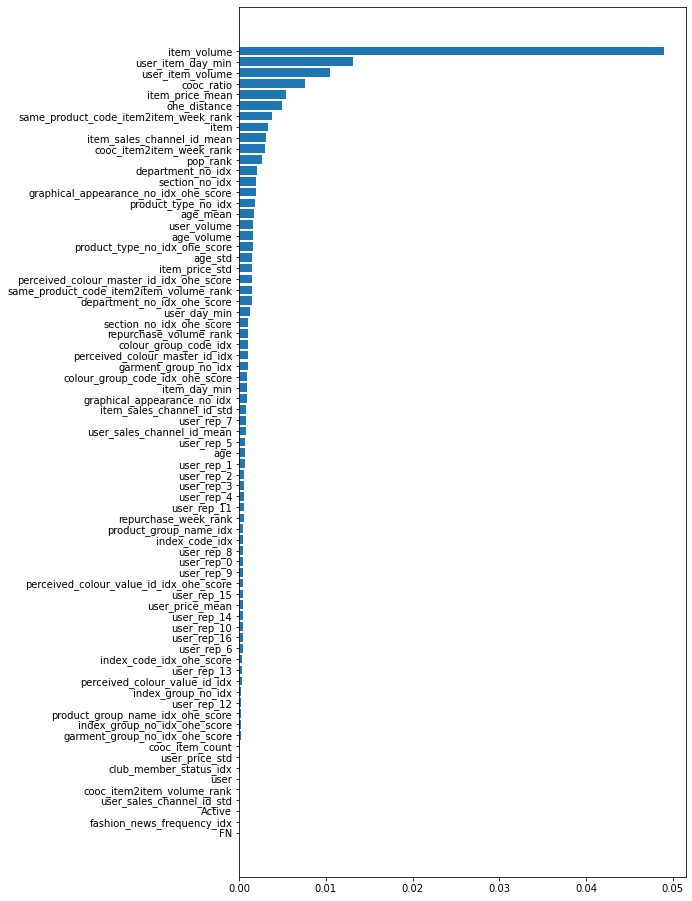

In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    # params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

12086

In [23]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [24]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 7.277 s


[popular] 1.316 s


[item2item] 6.922 s


[cooccurrence] 14.650 s


[same_product_code] 8.576 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 113.157 s


volume: 22238629


duplicates: 1.0390634377524084


            strategy   volume     ratio
0  same_product_code  9190204  0.413254
1                pop  4939128  0.222097
2       ohe_distance  4269040  0.191965
3         repurchase  2735882  0.123024
4               cooc  1104375  0.049660


attach features (week: 0)


[user static fetaures] 4.917 s


[item stacic features] 6.972 s


[user dynamic features (transactions)] 5.557 s


[item dynamic features (transactions)] 5.467 s


[item dynamic features (user features)] 6.774 s


[item freshness features] 9.807 s


[item volume features] 6.213 s


[user freshness features] 13.912 s


[user volume features] 8.801 s


[user-item freshness features] 34.220 s


[user-item volume features] 11.454 s


[item age volume features] 14.062 s


[ohe dot products] 157.064 s


[lfm features] 12.586 s


chunk: 137198
create candidates (week: 0)


[repurchase] 7.252 s


[popular] 1.341 s


[item2item] 6.974 s


[cooccurrence] 14.885 s


[same_product_code] 8.642 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 57.300 s


volume: 22270921


duplicates: 1.038941625837685


            strategy   volume     ratio
0  same_product_code  9210520  0.413567
1                pop  4939128  0.221775
2       ohe_distance  4267221  0.191605
3         repurchase  2752227  0.123579
4               cooc  1101825  0.049474


attach features (week: 0)


[user static fetaures] 5.035 s


[item stacic features] 6.885 s


[user dynamic features (transactions)] 5.479 s


[item dynamic features (transactions)] 4.910 s


[item dynamic features (user features)] 5.612 s


[item freshness features] 7.974 s


[item volume features] 5.093 s


[user freshness features] 10.218 s


[user volume features] 5.967 s


[user-item freshness features] 35.035 s


[user-item volume features] 10.404 s


[item age volume features] 8.871 s


[ohe dot products] 149.344 s


[lfm features] 14.917 s


chunk: 274396
create candidates (week: 0)


[repurchase] 7.183 s


[popular] 1.333 s


[item2item] 7.036 s


[cooccurrence] 15.105 s


[same_product_code] 8.767 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 58.030 s


volume: 22177932


duplicates: 1.03895731801467


            strategy   volume     ratio
0  same_product_code  9167920  0.413380
1                pop  4939128  0.222705
2       ohe_distance  4268900  0.192484
3         repurchase  2708651  0.122133
4               cooc  1093333  0.049298


attach features (week: 0)


[user static fetaures] 5.234 s


[item stacic features] 7.131 s


[user dynamic features (transactions)] 5.503 s


[item dynamic features (transactions)] 5.797 s


[item dynamic features (user features)] 5.572 s


[item freshness features] 8.055 s


[item volume features] 5.052 s


[user freshness features] 9.891 s


[user volume features] 5.944 s


[user-item freshness features] 30.497 s


[user-item volume features] 9.498 s


[item age volume features] 8.975 s


[ohe dot products] 149.644 s


[lfm features] 14.762 s


chunk: 411594
create candidates (week: 0)


[repurchase] 7.161 s


[popular] 1.365 s


[item2item] 6.916 s


[cooccurrence] 15.058 s


[same_product_code] 8.761 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 58.058 s


volume: 22253344


duplicates: 1.0390300979296292


            strategy   volume     ratio
0  same_product_code  9204223  0.413611
1                pop  4939128  0.221950
2       ohe_distance  4267930  0.191788
3         repurchase  2737078  0.122996
4               cooc  1104985  0.049655


attach features (week: 0)


[user static fetaures] 4.901 s


[item stacic features] 7.053 s


[user dynamic features (transactions)] 5.516 s


[item dynamic features (transactions)] 4.936 s


[item dynamic features (user features)] 5.574 s


[item freshness features] 8.066 s


[item volume features] 5.104 s


[user freshness features] 9.990 s


[user volume features] 6.013 s


[user-item freshness features] 30.490 s


[user-item volume features] 9.704 s


[item age volume features] 8.887 s


[ohe dot products] 148.328 s


[lfm features] 12.979 s


chunk: 548792
create candidates (week: 0)


[repurchase] 7.324 s


[popular] 1.378 s


[item2item] 7.092 s


[cooccurrence] 15.252 s


[same_product_code] 8.878 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 58.487 s


volume: 22243350


duplicates: 1.0390940427208877


            strategy   volume     ratio
0  same_product_code  9190841  0.413195
1                pop  4939128  0.222050
2       ohe_distance  4269208  0.191932
3         repurchase  2739307  0.123152
4               cooc  1104866  0.049672


attach features (week: 0)


[user static fetaures] 4.957 s


[item stacic features] 7.088 s


[user dynamic features (transactions)] 5.483 s


[item dynamic features (transactions)] 5.408 s


[item dynamic features (user features)] 5.607 s


[item freshness features] 8.299 s


[item volume features] 5.163 s


[user freshness features] 9.913 s


[user volume features] 6.012 s


[user-item freshness features] 31.041 s


[user-item volume features] 9.765 s


[item age volume features] 8.946 s


[ohe dot products] 151.681 s


[lfm features] 12.654 s


chunk: 685990
create candidates (week: 0)


[repurchase] 7.388 s


[popular] 1.321 s


[item2item] 7.086 s


[cooccurrence] 15.834 s


[same_product_code] 8.849 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 57.993 s


volume: 22305982


duplicates: 1.0391765592960278


            strategy   volume     ratio
0  same_product_code  9243785  0.414408
1                pop  4939128  0.221426
2       ohe_distance  4266329  0.191264
3         repurchase  2745003  0.123061
4               cooc  1111737  0.049840


attach features (week: 0)


[user static fetaures] 4.930 s


[item stacic features] 7.020 s


[user dynamic features (transactions)] 5.627 s


[item dynamic features (transactions)] 5.296 s


[item dynamic features (user features)] 5.591 s


[item freshness features] 8.281 s


[item volume features] 5.138 s


[user freshness features] 10.257 s


[user volume features] 9.477 s


[user-item freshness features] 34.537 s


[user-item volume features] 9.688 s


[item age volume features] 8.945 s


[ohe dot products] 149.928 s


[lfm features] 13.787 s


chunk: 823188
create candidates (week: 0)


[repurchase] 8.250 s


[popular] 1.563 s


[item2item] 7.063 s


[cooccurrence] 15.114 s


[same_product_code] 8.623 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 58.645 s


volume: 22197827


duplicates: 1.0393560250086047


            strategy   volume     ratio
0  same_product_code  9166138  0.412930
1                pop  4939128  0.222505
2       ohe_distance  4268217  0.192281
3         repurchase  2714357  0.122280
4               cooc  1109987  0.050004


attach features (week: 0)


[user static fetaures] 4.882 s


[item stacic features] 6.818 s


[user dynamic features (transactions)] 5.509 s


[item dynamic features (transactions)] 4.906 s


[item dynamic features (user features)] 5.533 s


[item freshness features] 8.138 s


[item volume features] 5.072 s


[user freshness features] 10.156 s


[user volume features] 6.017 s


[user-item freshness features] 30.188 s


[user-item volume features] 9.545 s


[item age volume features] 9.330 s


[ohe dot products] 146.509 s


[lfm features] 14.192 s


chunk: 960386
create candidates (week: 0)


[repurchase] 7.509 s


[popular] 1.368 s


[item2item] 7.068 s


[cooccurrence] 15.363 s


[same_product_code] 8.776 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 58.092 s


volume: 22217321


duplicates: 1.0391662786083484


            strategy   volume     ratio
0  same_product_code  9175200  0.412975
1                pop  4939128  0.222310
2       ohe_distance  4268309  0.192116
3         repurchase  2731902  0.122963
4               cooc  1102782  0.049636


attach features (week: 0)


[user static fetaures] 4.859 s


[item stacic features] 6.711 s


[user dynamic features (transactions)] 5.470 s


[item dynamic features (transactions)] 5.277 s


[item dynamic features (user features)] 5.547 s


[item freshness features] 7.975 s


[item volume features] 5.090 s


[user freshness features] 10.115 s


[user volume features] 6.055 s


[user-item freshness features] 30.776 s


[user-item volume features] 9.710 s


[item age volume features] 8.989 s


[ohe dot products] 149.155 s


[lfm features] 11.765 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 8.347 s


[popular] 1.315 s


[item2item] 6.892 s


[cooccurrence] 15.115 s


[same_product_code] 8.544 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 57.173 s


volume: 22144776


duplicates: 1.0387833901054095


            strategy   volume     ratio
0  same_product_code  9136160  0.412565
1                pop  4939128  0.223038
2       ohe_distance  4266203  0.192651
3         repurchase  2711285  0.122435
4               cooc  1092000  0.049312


attach features (week: 0)


[user static fetaures] 4.925 s


[item stacic features] 7.093 s


[user dynamic features (transactions)] 5.563 s


[item dynamic features (transactions)] 5.783 s


[item dynamic features (user features)] 6.437 s


[item freshness features] 9.417 s


[item volume features] 5.969 s


[user freshness features] 12.765 s


[user volume features] 9.616 s


[user-item freshness features] 40.662 s


[user-item volume features] 12.221 s


[item age volume features] 13.354 s


[ohe dot products] 179.633 s


[lfm features] 17.963 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 7.533 s


[popular] 1.403 s


[item2item] 7.058 s


[cooccurrence] 15.328 s


[same_product_code] 8.906 s


module 'faiss' has no attribute 'index_cpu_to_gpu'


[ohe distance] 57.764 s


volume: 22229952


duplicates: 1.039150245322727


            strategy   volume     ratio
0  same_product_code  9189583  0.413387
1                pop  4939128  0.222183
2       ohe_distance  4267877  0.191988
3         repurchase  2730747  0.122841
4               cooc  1102617  0.049601


attach features (week: 0)


[user static fetaures] 4.971 s


[item stacic features] 7.038 s


[user dynamic features (transactions)] 5.621 s


[item dynamic features (transactions)] 4.945 s


[item dynamic features (user features)] 5.612 s


[item freshness features] 8.064 s


[item volume features] 5.168 s


[user freshness features] 9.828 s


[user volume features] 6.012 s


[user-item freshness features] 30.069 s


[user-item volume features] 9.556 s


[item age volume features] 9.015 s


[ohe dot products] 149.461 s


[lfm features] 11.841 s


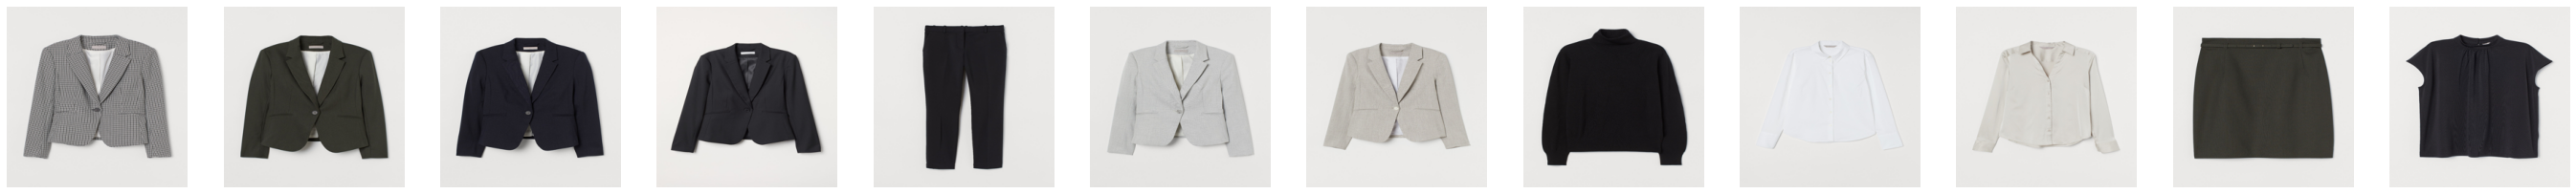

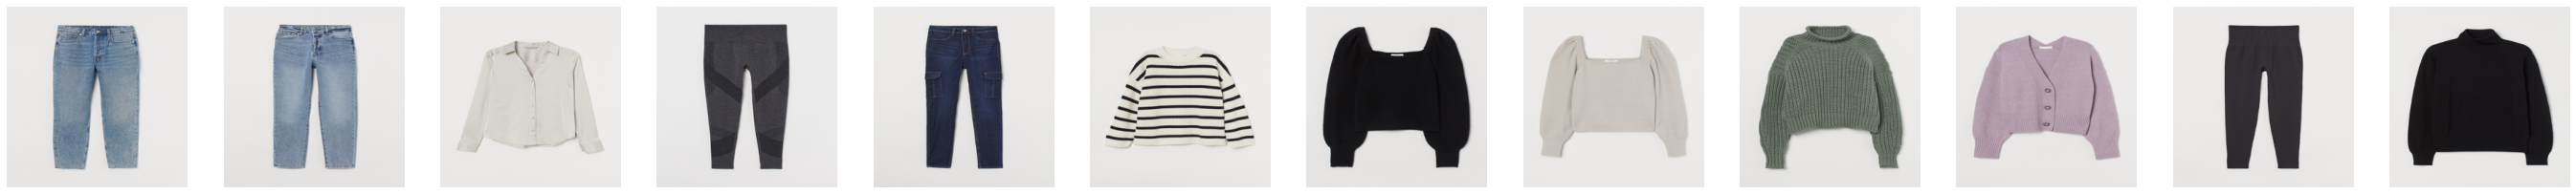

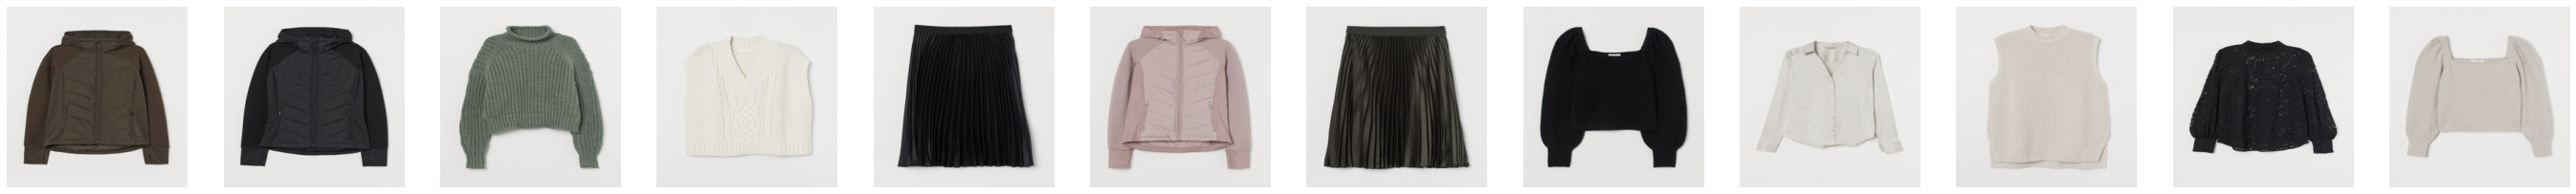

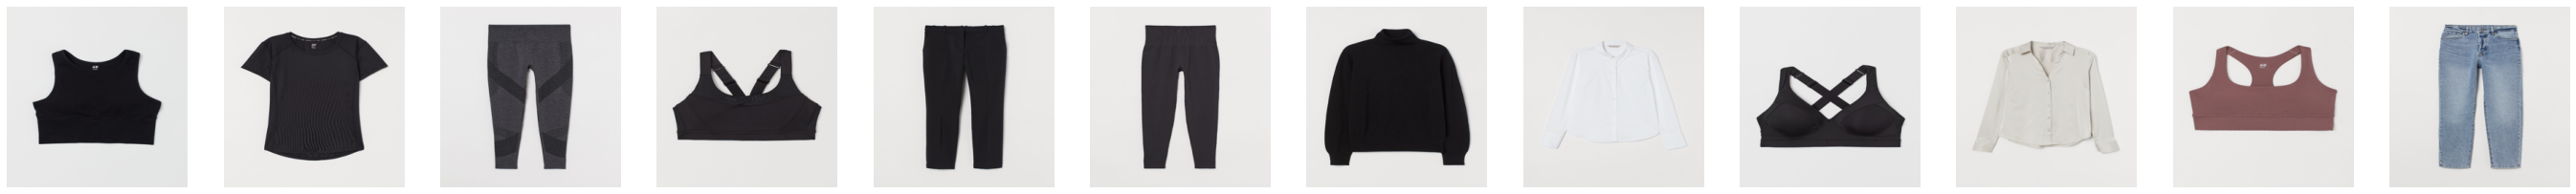

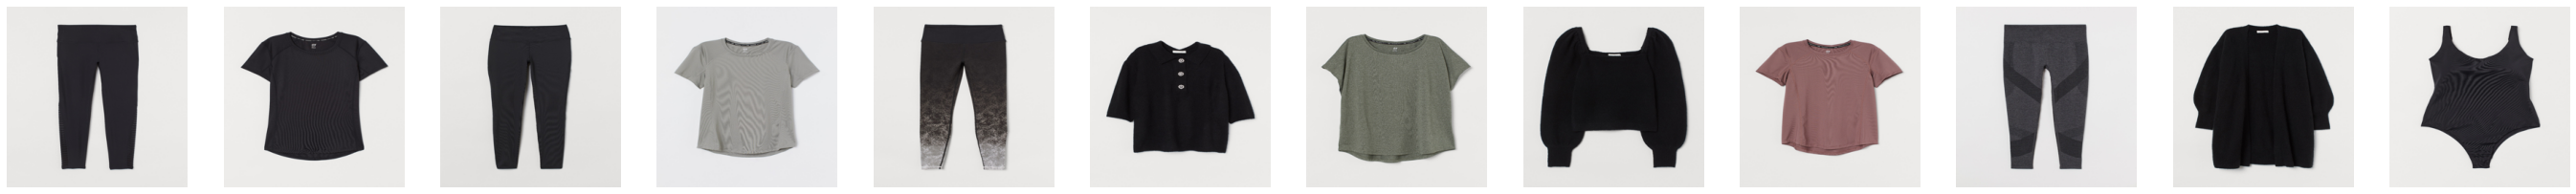

In [25]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [26]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601044 0568601043 0568601007 0568601006 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0714790020 0762846027 0918292001 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0873279005 0918522001 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0869331006 0791587001 0918292001 0910949002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587001 0852584001 0791587015 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0791587015 0804992014 0791587001 06...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846026 0762846006 0762846031 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846031 0762846026 0762846006 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0821395005 0714790028 07...


In [27]:
submission.to_csv('submission.csv', index=False)